# Bibliothèque

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import chi2_contingency, fisher_exact
from itertools import combinations


In [3]:
url = '/content/drive/MyDrive/Colab Notebooks/Data AI4CKD - Original (1).csv'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Fonction Réutilisables**

In [5]:
def convert_to_numeric(value):
    """Converts a single value to numeric. Used with apply() on a column"""
    try:
        return pd.to_numeric(value)
    except ValueError:
        return np.nan

# Fonction pour supprimer les lignes avec une valeur spécifique dans une colonne
def supprimer_lignes_avec_valeur(df, nom_colonne, valeur):
  """Supprime toutes les lignes du DataFrame où la colonne spécifiée a la valeur donnée."""
  print(f"\nSuppression des lignes avec la valeur '{valeur}' dans la colonne '{nom_colonne}'.\n")
  df_cleaned = df[df[nom_colonne] != valeur]
  return df_cleaned


#Fonction pour Affiche la distribution de la colonne spécifiée.
def distribution_colonne(df, nom_colonne):
  """Affiche la distribution de la colonne spécifiée."""
  print(f"\nDistribution de la colonne '{nom_colonne}':\n")
  print(df[nom_colonne].value_counts().to_markdown(numalign="left", stralign="left"))
  print("\n")
  print(df[nom_colonne].dtype)

# Fonction pour Tracé la distribution d'une variable catégorielle dans un DataFrame.
def plot_categorical_distribution(dataframe, column_name, title, xlabel, ylabel):
    """
    Trace la distribution d'une variable catégorielle dans un DataFrame.

    Paramètres :
    - dataframe : pd.DataFrame, le DataFrame contenant les données.
    - column_name : str, le nom de la colonne à tracer.
    - title : str, le titre du graphique.
    - xlabel : str, l'étiquette de l'axe des x.
    - ylabel : str, l'étiquette de l'axe des y.
    """
    plt.figure(figsize=(10, 6))
    dataframe[column_name].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def impute_by_mean(dataframe, column_name):
    """
    Impute les valeurs manquantes d'une colonne par la moyenne.

    Paramètres :
    - dataframe : pd.DataFrame, le DataFrame contenant les données.
    - column_name : str, le nom de la colonne à imputer.

    Retourne :
    - pd.DataFrame, le DataFrame avec les valeurs manquantes imputées par la moyenne.
    """
    # Créer un imputer avec la stratégie 'mean'
    imputer = SimpleImputer(strategy='mean')

    # Appliquer l'imputation à la colonne spécifiée
    dataframe[column_name] = imputer.fit_transform(dataframe[[column_name]])

    return dataframe

def plot_numeric_distribution(dataframe, column_name, title, xlabel, ylabel, bins=30):
    """
    Trace la distribution d'une variable numérique dans un DataFrame.

    Paramètres :
    - dataframe : pd.DataFrame, le DataFrame contenant les données.
    - column_name : str, le nom de la colonne à tracer.
    - title : str, le titre du graphique.
    - xlabel : str, l'étiquette de l'axe des x.
    - ylabel : str, l'étiquette de l'axe des y.
    - bins : int, le nombre de classes pour l'histogramme.
    """
    plt.figure(figsize=(10, 6))
    dataframe[column_name].plot(kind='hist', bins=bins, color='skyblue', edgecolor='black', density=True)
    dataframe[column_name].plot(kind='density', color='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Fonction pour afficher toutes les valeurs d'une colonne
def afficher_valeurs_colonne(df, nom_colonne):
  """Affiche toutes les valeurs uniques d'une colonne."""
  print(f"\nValeurs de la colonne '{nom_colonne}':")
  print(df[nom_colonne].unique())
  print("\n")
  print(df[nom_colonne].dtype)

def remove_missing_values(dataframe, column_name):
    """
    Supprime toutes les lignes avec des valeurs manquantes dans une colonne spécifique d'un DataFrame.

    Paramètres :
    - dataframe : pd.DataFrame, le DataFrame contenant les données.
    - column_name : str, le nom de la colonne à nettoyer.

    Retourne :
    - pd.DataFrame, le DataFrame sans les lignes contenant des valeurs manquantes dans la colonne spécifiée.
    """
    print(f"\nSuppression des lignes avec des valeurs manquantes dans la colonne '{column_name}'.\n")
    dataframe = dataframe.dropna(subset=[column_name])
    return dataframe


def analyse_sensibilite(df, feature, target):
    """
    Analyse l'impact de différentes méthodes de gestion des valeurs manquantes sur un modèle de régression linéaire.

    Paramètres :
        df (pd.DataFrame) : Le DataFrame contenant les données.
        feature (str) : Le nom de la variable explicative.
        target (str) : Le nom de la variable cible.

    Retourne :
        dict : Un dictionnaire contenant les coefficients obtenus avec chaque méthode.
    """
    results = {}

    # Exclusion des données manquantes
    df_excluded = df.dropna(subset=[feature])
    if not df_excluded.empty:
        model_excluded = LinearRegression().fit(df_excluded[[feature]], df_excluded[target])
        results['Exclusion'] = model_excluded.coef_[0]

    # Imputation par la médiane
    imputer_median = SimpleImputer(strategy='median')
    df_median_imputed = df[[feature]].copy()
    df_median_imputed[feature] = imputer_median.fit_transform(df_median_imputed)
    model_median = LinearRegression().fit(df_median_imputed, df[target])
    results['Médiane'] = model_median.coef_[0]

    # Imputation par la moyenne
    imputer_mean = SimpleImputer(strategy='mean')
    df_mean_imputed = df[[feature]].copy()
    df_mean_imputed[feature] = imputer_mean.fit_transform(df_mean_imputed)
    model_mean = LinearRegression().fit(df_mean_imputed, df[target])
    results['Moyenne'] = model_mean.coef_[0]

    return results

def box_plot(dataframe, column_name, title, xlabel, ylabel):
    """
    Trace un box plot pour une variable numérique dans un DataFrame.

    Paramètres :
    - dataframe : pd.DataFrame, le DataFrame
    - column_name : str, le nom de la colonne à tracer
    - title : str, le titre du graphique
    - xlabel : str, l'étiquette de l'axe des x
    - ylabel : str, l'étiquette de l'axe
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=dataframe[column_name])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()
import pandas as pd

def detect_outliers_iqr(df, column, threshold=1.5):
    """
    Détecte les valeurs aberrantes dans une colonne d'un DataFrame en utilisant l'IQR.

    Paramètres :
    - df : DataFrame Pandas
    - column : Nom de la colonne à analyser
    - threshold : Facteur d'écart interquartile (1.5 par défaut)

    Retourne :
    - DataFrame contenant uniquement les valeurs aberrantes
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"Nombre de valeurs aberrantes détectées dans '{column}' : {outliers.shape[0]}")
    return outliers


# **1. Chargement du dataset**

In [6]:
dataset = pd.read_csv(url)

In [7]:
dataset.head()

ID Sexe   Age Nationalité Profession (selon catégorie professionnelle)  \
0   1    F  50.0   Béninoise                                      Artisan   
1   2    M  28.0   Béninoise                                      Artisan   
2   3    F  69.0   Béninoise                                          NaN   
3   4    M  68.0   Béninoise                                 Entrepreneur   
4   5    F  68.0   Béninoise                                          NaN   

  Adresse (Département) Situation Matrimoniale  Motif(s) d'Admission/Asthénie  \
0              Littoral               Marié(e)                              1   
1                   Zou               Marié(e)                              1   
2            Atlantique               Marié(e)                              1   
3               Plateau               Marié(e)                              1   
4                   NaN               Marié(e)                              1   

   Motif(s) d'Admission/Altération de la fonction rénale  \
0                                                  0       
1                                                  1       
2                                                  1       
3                                                  0       
4                                                  1       

   Motif(s) d'Admission/HTA  ...  Pathologies/Rétinopathie diabétique  \
0                         0  ...                                    0   
1                         0  ...                                    0   
2                         0  ...                                    0   
3                         1  ...                                    0   
4                         0  ...                                    0   

   Pathologies/Artériosclérose  Pathologies/Glaucome Autres Pathologies  \
0                          NaN                     0                NaN   
1                          NaN                     0                NaN   
2                          NaN                     0                NaN   
3                          NaN                     0        Flou visuel   
4                          NaN                     1                NaN   

   Rythme Cardiaque/Sinusal  Rythme Cardiaque/Régulier  \
0                         0                        NaN   
1                         0                        NaN   
2                         0                        NaN   
3                         0                        NaN   
4                         0                        Non   

   Trouble de la Repolarisation  Stage de l'IRC  \
0                           NaN           CKD 5   
1                           NaN           CKD 5   
2                           NaN           CKD 5   
3                           Oui           CKD 5   
4                           Non           CKD 5   

   Causes Majeure après Diagnostic/HTA  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    1   

   Causes Majeure après Diagnostic/Diabète  
0                                        0  
1                                        0  
2                                        0  
3                                        0  
4                                        0  

[5 rows x 201 columns]

In [8]:
# Display the remaining columns
print(dataset.shape)

(306, 201)


Le dataset contiens **309 ligne** et **201 colonnes**

In [9]:
print(dataset.dtypes)


ID                                                int64
Sexe                                             object
Age                                             float64
Nationalité                                      object
Profession (selon catégorie professionnelle)     object
                                                 ...   
Rythme Cardiaque/Régulier                        object
Trouble de la Repolarisation                     object
Stage de l'IRC                                   object
Causes Majeure après Diagnostic/HTA               int64
Causes Majeure après Diagnostic/Diabète           int64
Length: 201, dtype: object


# **2. Sélectionner les colonnes pertinentes**

In [10]:
important_features = ['Age','BU/Albuminuerie','BU/Protéinurie','Créatinine (mg/L)','Durée Diabète 1 (mois)','Durée Diabète 2 (mois)','Durée HTA (mois)','Durée IRC (mois)','Glycémie à jeun (taux de Glucose)','Protéinurie','Urée (g/L)',"Stage de l'IRC"]

potentially_important_features = ["Etat Général (EG) à l'Admission",'BU/Glucosurie', 'BU/Hématurie', 'CCMH (%)','Hb (g/dL)','Na^+ (meq/L)','K^+ (meq/L)','Ca^2+ (meq/L)', 'Hématie (T/L)' ,'IMC', 'Pathologies/Rétinopathie diabétique' , 'Protéinurie à la bandellette urinaire (g/24h)','Sexe' ,'Symptômes/Anémie','Symptômes/Asthénie','Symptômes/HTA','Symptômes/OMI','Symptômes/Oligurie','TA (mmHg)/Diastole','TA (mmHg)/Systole']

# Combine the lists
selected_columns = important_features + potentially_important_features

df = dataset[selected_columns]


In [11]:
print("\nNombre de valeurs manquantes par colonne:\n")
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))



Nombre de valeurs manquantes par colonne:

|                                               | 0   |
|:----------------------------------------------|:----|
| Age                                           | 7   |
| BU/Albuminuerie                               | 225 |
| BU/Protéinurie                                | 225 |
| Créatinine (mg/L)                             | 0   |
| Durée Diabète 1 (mois)                        | 304 |
| Durée Diabète 2 (mois)                        | 222 |
| Durée HTA (mois)                              | 108 |
| Durée IRC (mois)                              | 288 |
| Glycémie à jeun (taux de Glucose)             | 87  |
| Protéinurie                                   | 245 |
| Urée (g/L)                                    | 23  |
| Stage de l'IRC                                | 0   |
| Etat Général (EG) à l'Admission               | 5   |
| BU/Glucosurie                                 | 225 |
| BU/Hématurie                                  | 225 |
| CC

In [12]:
  # surpression des ligne avec que des valeur manquant ou a plus de 70% de valeur manquante
min_non_missing_cols = int(0.3 * df.shape[1])  # 30% des colonnes doivent avoir des valeurs

df = df.dropna(thresh=min_non_missing_cols)

In [13]:
# Afficher la dernière ligne
derniere_ligne = df.tail(1)
print(derniere_ligne)

      Age BU/Albuminuerie BU/Protéinurie Créatinine (mg/L)  \
305  76.0             Non            Non                13   

    Durée Diabète 1 (mois) Durée Diabète 2 (mois) Durée HTA (mois)  \
305                    NaN                    NaN            >=120   

    Durée IRC (mois) Glycémie à jeun (taux de Glucose) Protéinurie  ...  \
305              NaN                              0,79         NaN  ...   

    Pathologies/Rétinopathie diabétique  \
305                                   1   

    Protéinurie à la bandellette urinaire (g/24h) Sexe Symptômes/Anémie  \
305                                           NaN    F                0   

    Symptômes/Asthénie Symptômes/HTA Symptômes/OMI Symptômes/Oligurie  \
305                  0             0           Oui                  0   

    TA (mmHg)/Diastole TA (mmHg)/Systole  
305               73.0             117.0  

[1 rows x 32 columns]


## Gestion des valeurs manquante et Colonnes

ces colonne on été supprimer car il n'etait pas si important du point de vue scientifique par rapport au facteur important determinant l'évolution de L'IRC de plus on note aussi  plus de 90% et pour d'autre plus de 75% des valeur manquante donc on les supprime

In [14]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['Durée Diabète 1 (mois)','Durée Diabète 2 (mois)', 'Durée HTA (mois)','Durée IRC (mois)','BU/Glucosurie','BU/Hématurie','BU/Protéinurie','Protéinurie','IMC','Protéinurie à la bandellette urinaire (g/24h)','CCMH (%)','Hématie (T/L)','BU/Albuminuerie']
# Suppression des colonnes avec plus de 50% de valeur manquantes
df = df.drop(columns=colonnes_a_supprimer)

In [15]:
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

|                                     | 0   |
|:------------------------------------|:----|
| Age                                 | 7   |
| Créatinine (mg/L)                   | 0   |
| Glycémie à jeun (taux de Glucose)   | 87  |
| Urée (g/L)                          | 23  |
| Stage de l'IRC                      | 0   |
| Etat Général (EG) à l'Admission     | 5   |
| Hb (g/dL)                           | 50  |
| Na^+ (meq/L)                        | 35  |
| K^+ (meq/L)                         | 30  |
| Ca^2+ (meq/L)                       | 91  |
| Pathologies/Rétinopathie diabétique | 0   |
| Sexe                                | 8   |
| Symptômes/Anémie                    | 0   |
| Symptômes/Asthénie                  | 0   |
| Symptômes/HTA                       | 0   |
| Symptômes/OMI                       | 0   |
| Symptômes/Oligurie                  | 0   |
| TA (mmHg)/Diastole                  | 61  |
| TA (mmHg)/Systole                   | 61  |


## Afficher dataset

In [16]:
df.shape

(306, 19)

In [17]:
df.head()

Age Créatinine (mg/L) Glycémie à jeun (taux de Glucose) Urée (g/L)  \
0  50.0               169                               NaN       1,29   
1  28.0                17                               NaN       0,66   
2  69.0                48                              2,87       0,79   
3  68.0                42                                 1       1,14   
4  68.0               500                               NaN        NaN   

  Stage de l'IRC Etat Général (EG) à l'Admission Hb (g/dL) Na^+ (meq/L)  \
0          CKD 5                          Altéré      11,4          131   
1          CKD 5                          Altéré       9,5          134   
2          CKD 5                          Altéré       9,6          139   
3          CKD 5                          Altéré       8,2          142   
4          CKD 5                       Aceptable         9          NaN   

  K^+ (meq/L) Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique Sexe  \
0         6,4            82                                    0    F   
1         5,3           NaN                                    0    M   
2         3,4            87                                    0    F   
3         5,7            88                                    0    M   
4         NaN           NaN                                    0    F   

   Symptômes/Anémie  Symptômes/Asthénie  Symptômes/HTA Symptômes/OMI  \
0                 1                   0              0           Non   
1                 1                   1              0           Oui   
2                 0                   1              0           Oui   
3                 0                   0              0           Oui   
4                 0                   1              1           Oui   

   Symptômes/Oligurie  TA (mmHg)/Diastole  TA (mmHg)/Systole  
0                   0                80.0              140.0  
1                   0                80.0              130.0  
2                   0                34.0               93.0  
3                   0                70.0              130.0  
4                   0               111.0              225.0

# **3. Exploration univariéé & Vérification des types des données**

In [18]:
df.dtypes

Age                                    float64
Créatinine (mg/L)                       object
Glycémie à jeun (taux de Glucose)       object
Urée (g/L)                              object
Stage de l'IRC                          object
Etat Général (EG) à l'Admission         object
Hb (g/dL)                               object
Na^+ (meq/L)                            object
K^+ (meq/L)                             object
Ca^2+ (meq/L)                           object
Pathologies/Rétinopathie diabétique      int64
Sexe                                    object
Symptômes/Anémie                         int64
Symptômes/Asthénie                       int64
Symptômes/HTA                            int64
Symptômes/OMI                           object
Symptômes/Oligurie                       int64
TA (mmHg)/Diastole                     float64
TA (mmHg)/Systole                      float64
dtype: object


## **3.1 Vérification des valeurs  catégorielles**

In [19]:
"""
| Stage de l'IRC                      | 2   |
| Etat Général (EG) à l'Admission     | 7   |
| Pathologies/Rétinopathie diabétique | 2   |
| Sexe                                | 10  |
| Symptômes/Anémie                    | 2   |
| Symptômes/HTA                       | 2   |
| Symptômes/OMI                       | 2   |
| Symptômes/Oligurie                  | 2   |
| Symptômes/Asthénie                  | 0   |
"""
categorical_columns = ['Sexe','Stage de l\'IRC',"Etat Général (EG) à l'Admission",'Symptômes/Anémie','Symptômes/HTA','Symptômes/OMI','Symptômes/Oligurie','Symptômes/Asthénie',"Pathologies/Rétinopathie diabétique"]

for col in categorical_columns:
    unique_values = df[col].unique()
    if len(unique_values) > 50:
        # If there are too many unique values, sample the top 50
        top_occurring_values = df[col].value_counts().head(50).index.tolist()
        print(f"\nColumn '{col}': Top 50 occurring values: \n{top_occurring_values}")
    else:
        # Otherwise print all unique valus in the column
        print(f"\nColumn '{col}': Unique values: \n{unique_values}")


Column 'Sexe': Unique values: 
['F' 'M' nan]

Column 'Stage de l'IRC': Unique values: 
['CKD 5' 'CKD 2' 'CKD 4' 'CKD 3a' 'CKD 1' 'CKD 3b']

Column 'Etat Général (EG) à l'Admission': Unique values: 
['Altéré' 'Aceptable' 'Bon' nan]

Column 'Symptômes/Anémie': Unique values: 
[1 0]

Column 'Symptômes/HTA': Unique values: 
[0 1]

Column 'Symptômes/OMI': Unique values: 
['Non' 'Oui']

Column 'Symptômes/Oligurie': Unique values: 
[0 1]

Column 'Symptômes/Asthénie': Unique values: 
[0 1]

Column 'Pathologies/Rétinopathie diabétique': Unique values: 
[0 1]


In [20]:
# suppression de la dernière ligne avec les pourcentage
df = supprimer_lignes_avec_valeur(df, 'Sexe', '3%')


Suppression des lignes avec la valeur '3%' dans la colonne 'Sexe'.




### **CORRECTION Variable ,type , valeur abbérant , incohérente , manquante**

#### **Stade de l'IRC**

In [21]:

df['Stage de l\'IRC'] = df['Stage de l\'IRC'].replace({
    'CKD 1': 1,
    'CKD 2': 2,
    'CKD 3a': 3,
    'CKD 3b': 3,
    'CKD 4': 4,
    'CKD 5': 5
})
df['Stage de l\'IRC'] = pd.to_numeric(df['Stage de l\'IRC'], errors='coerce')

<ipython-input-21-3b2471e16bde>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Stage de l\'IRC'] = df['Stage de l\'IRC'].replace({


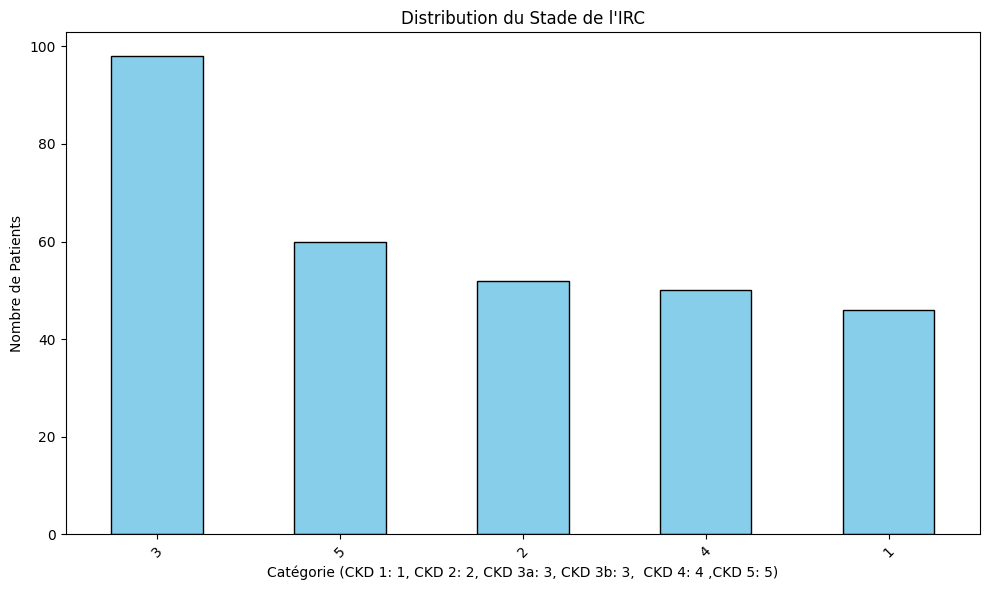


Distribution de la colonne 'Stage de l'IRC':

| Stage de l'IRC   | count   |
|:-----------------|:--------|
| 3                | 98      |
| 5                | 60      |
| 2                | 52      |
| 4                | 50      |
| 1                | 46      |


int64


In [22]:
# Tracer la distribution
plot_categorical_distribution(df, 'Stage de l\'IRC', 'Distribution du Stade de l\'IRC', 'Catégorie (CKD 1: 1, CKD 2: 2, CKD 3a: 3, CKD 3b: 3,  CKD 4: 4 ,CKD 5: 5)', 'Nombre de Patients')
distribution_colonne(df, 'Stage de l\'IRC')

In [23]:
# identification des valeur manquante
print(df['Stage de l\'IRC'].isnull().sum())

0


In [24]:
# vérification valeur abbérantes
print(df['Stage de l\'IRC'].unique())

[5 2 4 3 1]


#### **SEXE**

In [25]:
df['Sexe'] = df['Sexe'].replace({'M': 1, 'F': 0})
df['Sexe'] = pd.to_numeric(df['Sexe'], errors='coerce')

<ipython-input-25-1c25195e7ee9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sexe'] = df['Sexe'].replace({'M': 1, 'F': 0})


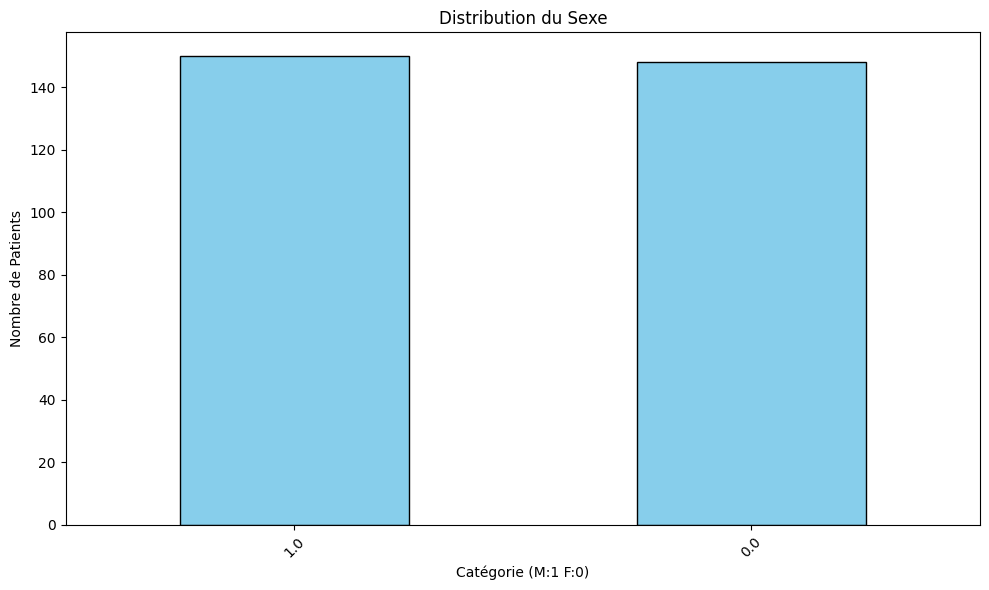


Distribution de la colonne 'Sexe':

| Sexe   | count   |
|:-------|:--------|
| 1      | 150     |
| 0      | 148     |


float64


In [26]:
# Tracer la distribution
plot_categorical_distribution(df, 'Sexe', 'Distribution du Sexe', 'Catégorie (M:1 F:0)', 'Nombre de Patients')
distribution_colonne(df, 'Sexe')

In [27]:
# vérification valeur manquantes
print(df['Sexe'].isnull().sum())

8


In [28]:
df[df['Sexe'].isnull()] # Afficher les valeurs manquante

Age Créatinine (mg/L) Glycémie à jeun (taux de Glucose) Urée (g/L)  \
57   46.0              17,6                              1,45       0,49   
82    NaN                15                              1,27       0,28   
84    NaN                22                              1,03        0,6   
95   41.0                11                              2,39       0,27   
97   64.0              16,5                              1,18       0,69   
99   72.0                22                              1,05       0,45   
119  73.0                14                               1,2        0,3   
126  70.0                20                              1,37       0,58   

     Stage de l'IRC Etat Général (EG) à l'Admission Hb (g/dL) Na^+ (meq/L)  \
57                3                             NaN       NaN          139   
82                3                             Bon        10          133   
84                3                       Aceptable      10,9          146   
95                2                       Aceptable      13,5          140   
97                3                             Bon      12,8          138   
99                3                             Bon      13,3          143   
119               2                             Bon      11,7          139   
126               3                             Bon       NaN          138   

    K^+ (meq/L) Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
57          2,8            97                                    0   NaN   
82          4,2            86                                    0   NaN   
84          4,7            83                                    0   NaN   
95          3,4           NaN                                    0   NaN   
97          4,1           NaN                                    0   NaN   
99          4,1            98                                    0   NaN   
119         3,9           NaN                                    0   NaN   
126         3,6           100                                    0   NaN   

     Symptômes/Anémie  Symptômes/Asthénie  Symptômes/HTA Symptômes/OMI  \
57                  0                   0              0           Non   
82                  0                   0              0           Non   
84                  0                   0              0           Non   
95                  0                   0              0           Oui   
97                  0                   0              0           Non   
99                  0                   0              0           Non   
119                 0                   0              0           Non   
126                 0                   0              0           Non   

     Symptômes/Oligurie  TA (mmHg)/Diastole  TA (mmHg)/Systole  
57                    0                84.0              145.0  
82                    0                78.0              112.0  
84                    0                79.0              128.0  
95                    0                 NaN                NaN  
97                    0                 NaN                NaN  
99                    0                 NaN                NaN  
119                   0                 NaN                NaN  
126                   1                80.0              120.0

In [29]:
# Etant données la distribution symetrique catégoriels binaires sans outlier on feras une imputation aléatoires des valeur
def impute_random_binary(series):
    probs = series.value_counts(normalize=True)  # Proba de chaque catégorie
    return series.fillna(np.random.choice(probs.index, p=probs.values))

df['Sexe'] = impute_random_binary(df['Sexe'])

# Vérification
print(df['Sexe'].isnull().sum())

0


In [30]:
# Vérification outliers
print(df['Sexe'].unique())

[0. 1.]


#### **Etat Général (EG) à l'Admission**

In [31]:
# Conversion de la variable 'Etat Général (EG) à l\'Admission'
df["Etat Général (EG) à l\'Admission"] = df["Etat Général (EG) à l\'Admission"].replace({
  'Altéré': 0, 'Aceptable': 0.5, 'Bon':1,
})
df["Etat Général (EG) à l\'Admission"] = pd.to_numeric(df["Etat Général (EG) à l\'Admission"], errors='coerce')


<ipython-input-31-78a331cc20f2>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Etat Général (EG) à l\'Admission"] = df["Etat Général (EG) à l\'Admission"].replace({


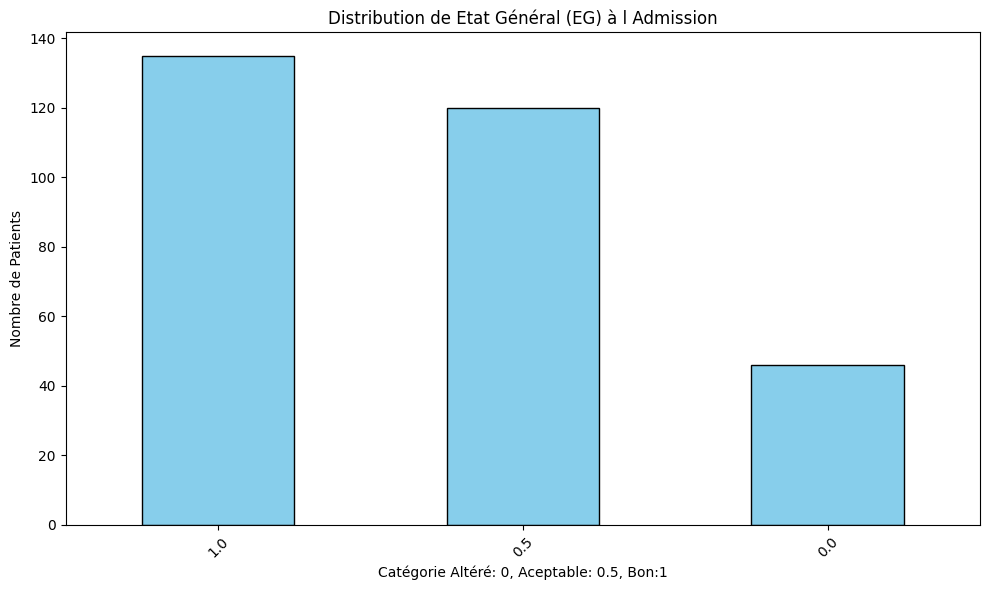


Distribution de la colonne 'Etat Général (EG) à l'Admission':

| Etat Général (EG) à l'Admission   | count   |
|:----------------------------------|:--------|
| 1                                 | 135     |
| 0.5                               | 120     |
| 0                                 | 46      |


float64


In [32]:
# distibution catégoriel
plot_categorical_distribution(df, "Etat Général (EG) à l\'Admission", 'Distribution de Etat Général (EG) à l Admission', 'Catégorie Altéré: 0, Aceptable: 0.5, Bon:1', 'Nombre de Patients')
distribution_colonne(df, "Etat Général (EG) à l\'Admission")

In [33]:
# valeurs manquante
print(df["Etat Général (EG) à l\'Admission"].isnull().sum())
# afficher table des valeur manquante
df[df["Etat Général (EG) à l\'Admission"].isnull()]

5


Age Créatinine (mg/L) Glycémie à jeun (taux de Glucose) Urée (g/L)  \
26   38.0                26                               NaN       0,94   
57   46.0              17,6                              1,45       0,49   
136  64.0                15                              0,78       0,69   
193  18.0                 5                              0,91        0,1   
282  68.0                19                              0,95       0,32   

     Stage de l'IRC  Etat Général (EG) à l'Admission Hb (g/dL) Na^+ (meq/L)  \
26                4                              NaN       7,1          141   
57                3                              NaN       NaN          139   
136               2                              NaN      12,5          141   
193               1                              NaN      11,8          139   
282               3                              NaN       NaN          142   

    K^+ (meq/L) Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
26          4,2            85                                    0   0.0   
57          2,8            97                                    0   1.0   
136         3,9            85                                    0   1.0   
193         3,9            89                                    0   0.0   
282         3,7            94                                    0   0.0   

     Symptômes/Anémie  Symptômes/Asthénie  Symptômes/HTA Symptômes/OMI  \
26                  1                   1              0           Oui   
57                  0                   0              0           Non   
136                 0                   0              0           Oui   
193                 0                   0              0           Oui   
282                 0                   1              0           Oui   

     Symptômes/Oligurie  TA (mmHg)/Diastole  TA (mmHg)/Systole  
26                    0               110.0              178.0  
57                    0                84.0              145.0  
136                   0               103.0              191.0  
193                   0                 NaN                NaN  
282                   0                66.0              123.0

In [34]:
# Etant donné cette variable catégorielle non binaire avec une distribrion asymetrique on va imputer par la categorie la plus fréquente
df["Etat Général (EG) à l\'Admission"].fillna(df["Etat Général (EG) à l\'Admission"].mode()[0], inplace=True)

# verification valeur null
print(df["Etat Général (EG) à l\'Admission"].isnull().sum())

0


<ipython-input-34-926b37f304cf>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Etat Général (EG) à l\'Admission"].fillna(df["Etat Général (EG) à l\'Admission"].mode()[0], inplace=True)


#### **Symptôme**

In [35]:
df['Symptômes/Anémie'] = df['Symptômes/Anémie'].apply(convert_to_numeric)

df['Symptômes/HTA'] = df['Symptômes/HTA'].apply(convert_to_numeric)
df['Symptômes/Oligurie'] = df['Symptômes/Oligurie'].apply(convert_to_numeric)
df['Symptômes/Asthénie'] = df['Symptômes/Asthénie'].apply(convert_to_numeric)

df['Symptômes/OMI'] = df['Symptômes/OMI'].replace({'Oui': 1, 'Non': 0})
df['Symptômes/OMI'] = pd.to_numeric(df['Symptômes/OMI'], errors='coerce')

<ipython-input-35-f5f7b47da77e>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Symptômes/OMI'] = df['Symptômes/OMI'].replace({'Oui': 1, 'Non': 0})


In [36]:
# vérification valeur manquantes
print(df['Symptômes/Anémie'].isnull().sum())
print(df['Symptômes/HTA'].isnull().sum())
print(df['Symptômes/OMI'].isnull().sum())
print(df['Symptômes/Oligurie'].isnull().sum())
print(df['Symptômes/Asthénie'].isnull().sum())

0
0
0
0
0


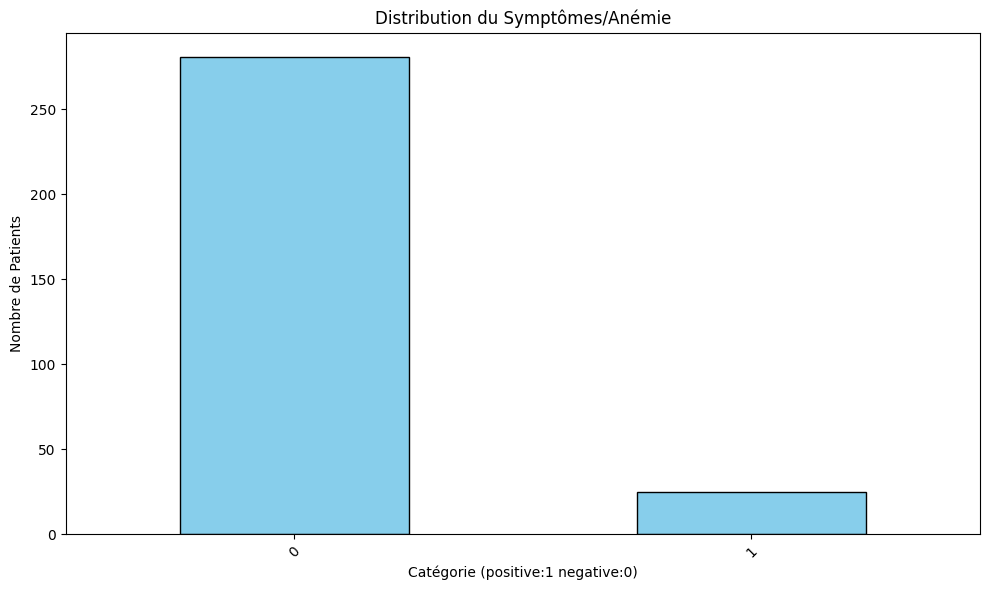


Distribution de la colonne 'Symptômes/Anémie':

| Symptômes/Anémie   | count   |
|:-------------------|:--------|
| 0                  | 281     |
| 1                  | 25      |


int64


In [37]:
# Tracer la distribution
plot_categorical_distribution(df, 'Symptômes/Anémie', 'Distribution du Symptômes/Anémie', 'Catégorie (positive:1 negative:0)', 'Nombre de Patients')
distribution_colonne(df, 'Symptômes/Anémie')

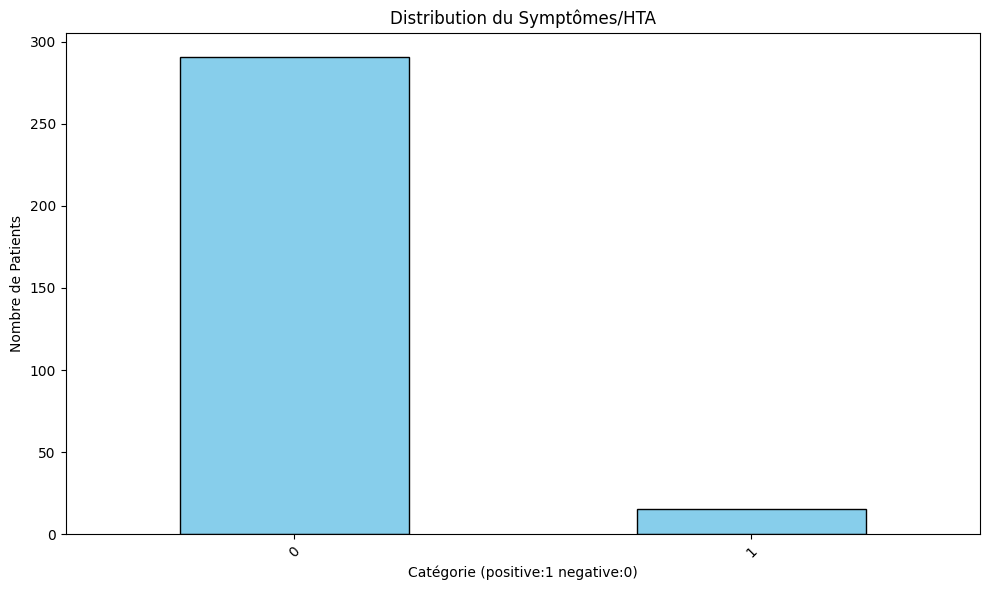


Distribution de la colonne 'Symptômes/HTA':

| Symptômes/HTA   | count   |
|:----------------|:--------|
| 0               | 291     |
| 1               | 15      |


int64


In [38]:
# Tracer la distribution
plot_categorical_distribution(df, 'Symptômes/HTA', 'Distribution du Symptômes/HTA', 'Catégorie (positive:1 negative:0)', 'Nombre de Patients')
distribution_colonne(df, 'Symptômes/HTA')

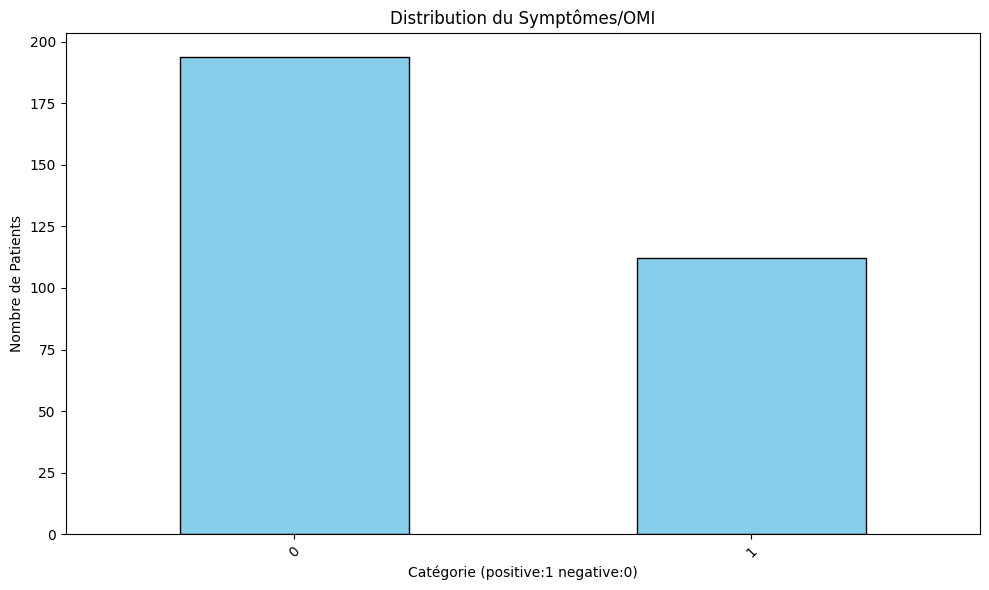


Distribution de la colonne 'Symptômes/OMI':

| Symptômes/OMI   | count   |
|:----------------|:--------|
| 0               | 194     |
| 1               | 112     |


int64


In [39]:
# Tracer la distribution
plot_categorical_distribution(df, 'Symptômes/OMI', 'Distribution du Symptômes/OMI', 'Catégorie (positive:1 negative:0)', 'Nombre de Patients')
distribution_colonne(df, 'Symptômes/OMI')

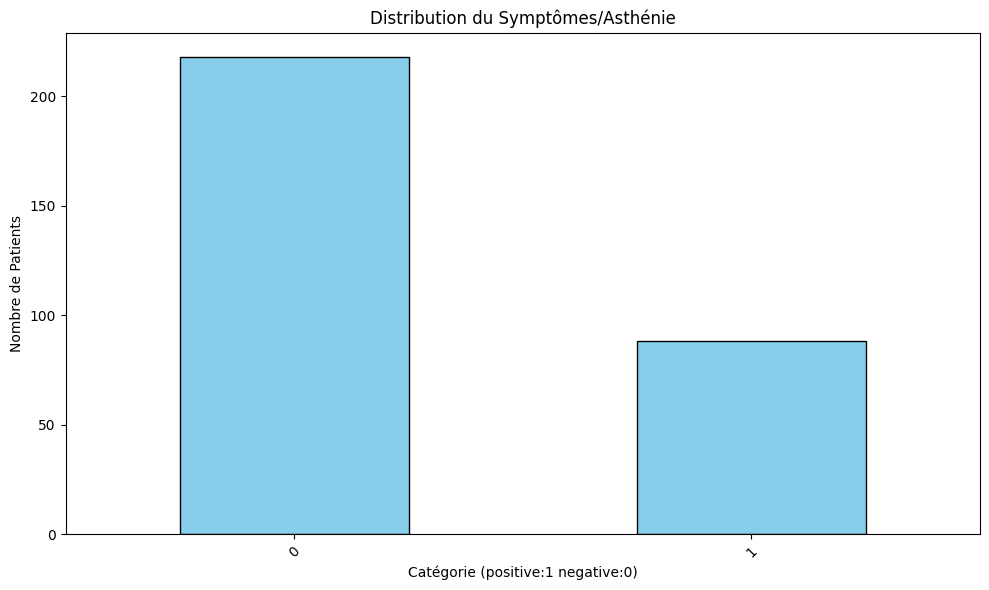


Distribution de la colonne 'Symptômes/Asthénie':

| Symptômes/Asthénie   | count   |
|:---------------------|:--------|
| 0                    | 218     |
| 1                    | 88      |


int64


In [40]:
# Tracer la distribution
plot_categorical_distribution(df, 'Symptômes/Asthénie', 'Distribution du Symptômes/Asthénie', 'Catégorie (positive:1 negative:0)', 'Nombre de Patients')
distribution_colonne(df, 'Symptômes/Asthénie')

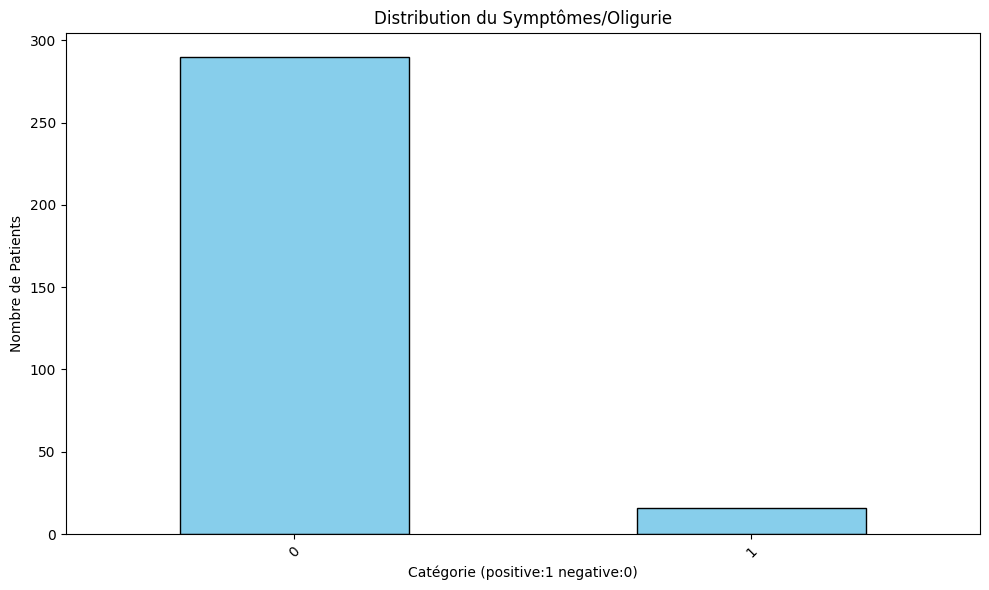


Distribution de la colonne 'Symptômes/Oligurie':

| Symptômes/Oligurie   | count   |
|:---------------------|:--------|
| 0                    | 290     |
| 1                    | 16      |


int64


In [41]:
# Tracer la distribution
plot_categorical_distribution(df, 'Symptômes/Oligurie', 'Distribution du Symptômes/Oligurie', 'Catégorie (positive:1 negative:0)', 'Nombre de Patients')
distribution_colonne(df, 'Symptômes/Oligurie')

#### **Pathologies/Rétinopathie diabétique**

In [42]:
df['Pathologies/Rétinopathie diabétique'] = df['Pathologies/Rétinopathie diabétique'].apply(convert_to_numeric)

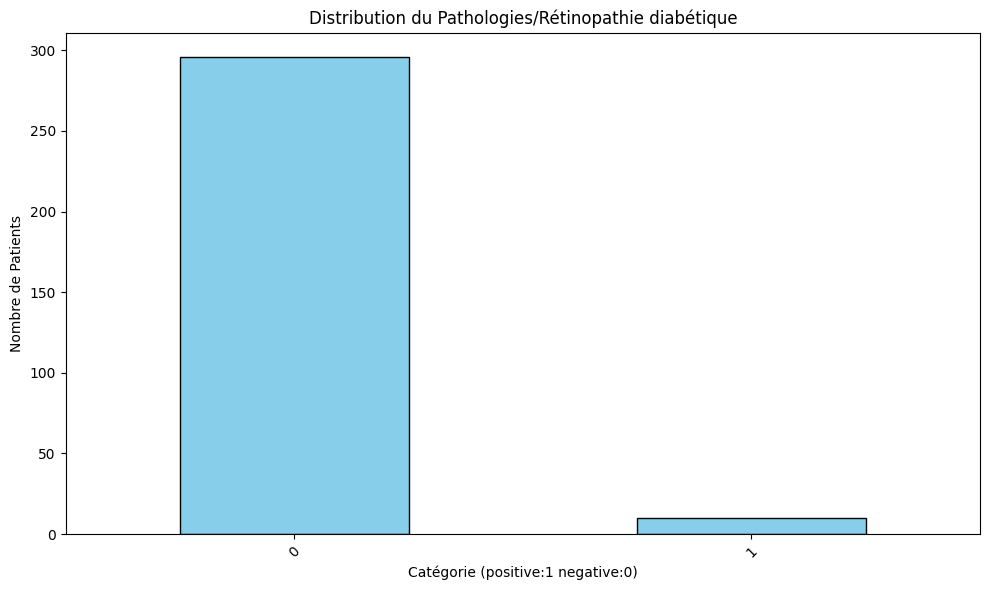


Distribution de la colonne 'Pathologies/Rétinopathie diabétique':

| Pathologies/Rétinopathie diabétique   | count   |
|:--------------------------------------|:--------|
| 0                                     | 296     |
| 1                                     | 10      |


int64


In [43]:
# Tracer la distribution
plot_categorical_distribution(df, 'Pathologies/Rétinopathie diabétique', 'Distribution du Pathologies/Rétinopathie diabétique', 'Catégorie (positive:1 negative:0)', 'Nombre de Patients')
distribution_colonne(df, 'Pathologies/Rétinopathie diabétique')

In [44]:
# afficher valeurs manquante
print(df['Pathologies/Rétinopathie diabétique'].isnull().sum())

0


## **3.2 Vérification des valeurs numériques**

In [45]:
"""
| Age                                 | 9   |
| Créatinine (mg/L)                   | 2   |
| Urée (g/L)                          | 25  |
| Hb (g/dL)                           | 52  |
| Na^+ (meq/L)                        | 37  |
| K^+ (meq/L)                         | 32  |
| Ca^2+ (meq/L)                       | 93  |
| TA (mmHg)/Diastole                  | 63  |
| TA (mmHg)/Systole                   | 63  |
| Glycémie à jeun (taux de Glucose)   | 87  |
"""
# Vérification des valeurs non numériques dans les colonnes numériques
numerical_columns = ['Age', 'Créatinine (mg/L)', 'Urée (g/L)','Hb (g/dL)','Na^+ (meq/L)','K^+ (meq/L)','Ca^2+ (meq/L)','TA (mmHg)/Systole','TA (mmHg)/Diastole','Glycémie à jeun (taux de Glucose)']


In [46]:
def is_numeric(value):
    try:
        pd.to_numeric(value)
        return True
    except ValueError:
        return False

for col in numerical_columns:
    non_numeric_values = df[col][df[col].apply(is_numeric) == False]
    if len(non_numeric_values) > 0:
        print(f"\nNon-numeric values found in column '{col}':\n{non_numeric_values}")
    else:
        print(f"\nColumn '{col}' is fully numeric.")


Column 'Age' is fully numeric.

Non-numeric values found in column 'Créatinine (mg/L)':
6      112,9
10     355,9
11     101,4
12      95,8
14     67,88
       ...  
285     17,4
286    11,92
292     17,5
297     17,4
298     14,7
Name: Créatinine (mg/L), Length: 77, dtype: object

Non-numeric values found in column 'Urée (g/L)':
0      1,29
1      0,66
2      0,79
3      1,14
5      1,58
       ... 
300    0,34
301    0,41
302    0,25
303     0,3
304    0,49
Name: Urée (g/L), Length: 282, dtype: object

Non-numeric values found in column 'Hb (g/dL)':
0      11,4
1       9,5
2       9,6
3       8,2
5       6,6
       ... 
300    14,8
301    12,8
302    10,2
304    12,2
305    11,9
Name: Hb (g/dL), Length: 231, dtype: object

Non-numeric values found in column 'Na^+ (meq/L)':
6      133,5
10     138,6
11     117,7
34     130,7
35     142,8
90     145,5
120    137,9
143    133,5
151    142,5
156    136,5
159    132,2
184    137,8
185    133,8
212    142,5
217    147,1
225    139,7
238  

### **CORRECTION Variable ,type , valeur abbérant , incohérente , manquante**

#### **Changer les virgule en points**

In [47]:
coma = ['Créatinine (mg/L)', 'Urée (g/L)', 'Hb (g/dL)', 'Na^+ (meq/L)',
        'K^+ (meq/L)', 'Ca^2+ (meq/L)', 'Glycémie à jeun (taux de Glucose)',
]

# Points à la place des virgules
for col in coma:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

df.head()


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
0  50.0              169.0                                NaN        1.29   
1  28.0               17.0                                NaN        0.66   
2  69.0               48.0                               2.87        0.79   
3  68.0               42.0                               1.00        1.14   
4  68.0              500.0                                NaN         NaN   

   Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
0               5                              0.0       11.4         131.0   
1               5                              0.0        9.5         134.0   
2               5                              0.0        9.6         139.0   
3               5                              0.0        8.2         142.0   
4               5                              0.5        9.0           NaN   

   K^+ (meq/L)  Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
0          6.4           82.0                                    0   0.0   
1          5.3            NaN                                    0   1.0   
2          3.4           87.0                                    0   0.0   
3          5.7           88.0                                    0   1.0   
4          NaN            NaN                                    0   0.0   

   Symptômes/Anémie  Symptômes/Asthénie  Symptômes/HTA  Symptômes/OMI  \
0                 1                   0              0              0   
1                 1                   1              0              1   
2                 0                   1              0              1   
3                 0                   0              0              1   
4                 0                   1              1              1   

   Symptômes/Oligurie  TA (mmHg)/Diastole  TA (mmHg)/Systole  
0                   0                80.0              140.0  
1                   0                80.0              130.0  
2                   0                34.0               93.0  
3                   0                70.0              130.0  
4                   0               111.0              225.0

#### **Traitement de la colonne Age**


In [48]:
df['Age'] = df['Age'].apply(convert_to_numeric)

Décidé d'affeter les valeurs manquante par la mediane pour évité la perte d'une partie des donné etant données aussi qu'il y ai que 7 valeurs manquante et on a 306 observation apres suppression des ligne pour la créatinines et aussi pour être moins affectée par les valeurs extrêmes.

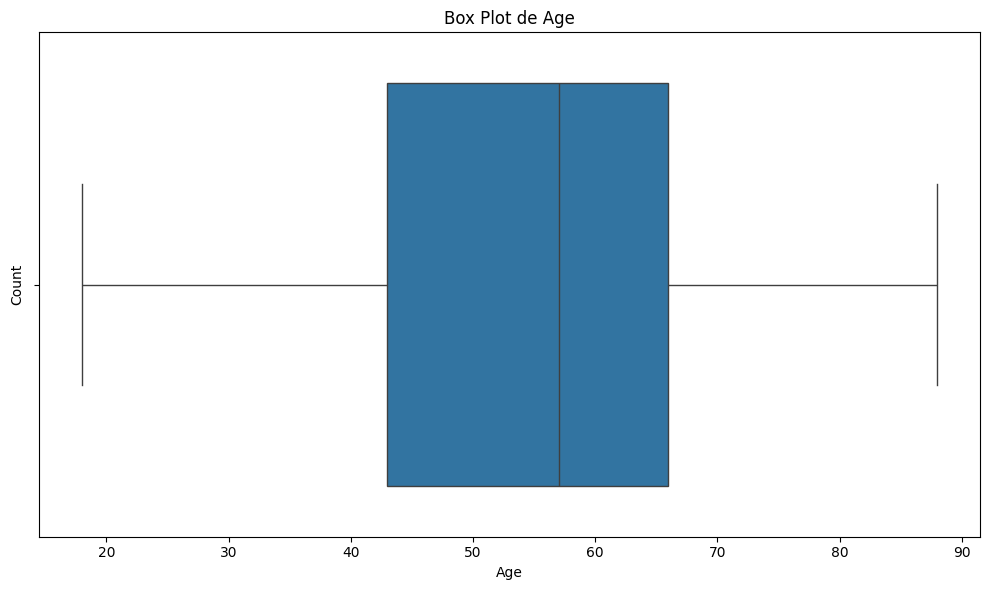

In [49]:
# vérifier valeur abbérante
box_plot(df, 'Age', 'Box Plot de Age', 'Age', 'Count')

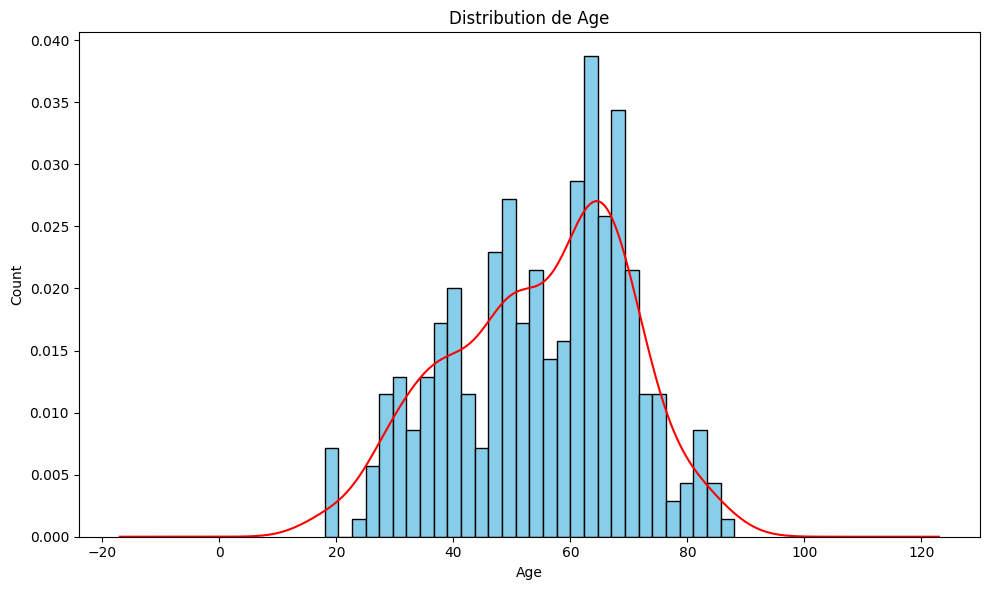

In [50]:
# Distribution de l'age
plot_numeric_distribution(df, 'Age', 'Distribution de Age', 'Age', 'Count')

In [51]:
df['Age'].describe()

count    299.000000
mean      54.685619
std       15.041826
min       18.000000
25%       43.000000
50%       57.000000
75%       66.000000
max       88.000000
Name: Age, dtype: float64

In [52]:
# Afficher nombre de valeurs manquante
print(df['Age'].isnull().sum())

7


In [53]:
# Distribution asymetrique sans outlier donc remplacer par la médiane
median_age = df['Age'].median()
df['Age'].fillna(median_age, inplace=True)

# Vérification
print(df['Age'].isnull().sum())

0


#### **Traitement Créatinine**

In [54]:
df['Créatinine (mg/L)'].describe()


count    306.000000
mean      43.532467
std       69.605698
min        0.000000
25%       12.000000
50%       17.380000
75%       31.750000
max      500.000000
Name: Créatinine (mg/L), dtype: float64

In [55]:
print(df['Créatinine (mg/L)'].isnull().sum())

0


In [56]:
df['Créatinine (mg/L)'].value_counts().sort_index()


Créatinine (mg/L)
0.000      1
0.245      1
2.180      1
4.000      1
5.000      2
          ..
319.000    1
321.000    1
355.900    1
379.000    1
500.000    1
Name: count, Length: 150, dtype: int64

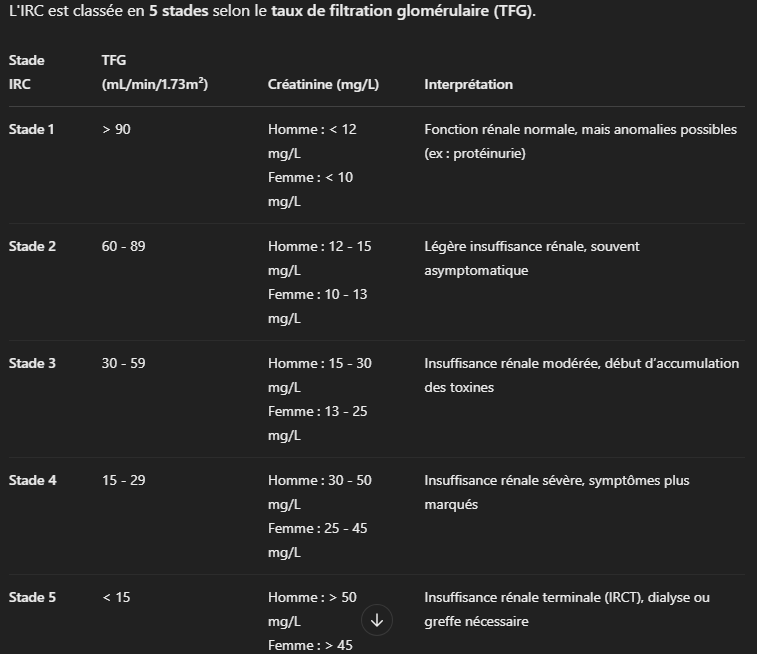

In [57]:
df[df['Créatinine (mg/L)'] < 10]


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
28   31.0              0.245                                NaN        2.03   
58   51.0              9.000                               1.25        0.19   
61   64.0              7.000                               2.40        0.22   
62   69.0              9.000                               1.07         NaN   
73   49.0              9.000                               0.98        0.17   
76   55.0              9.400                               1.02        0.40   
79   59.0              6.200                               0.90         NaN   
80   58.0              4.000                               1.13        0.27   
101  43.0              7.440                               0.98        0.19   
102  49.0              7.000                               1.09        0.21   
105  45.0              6.000                               0.80        0.10   
107  69.0              9.000                               0.93        0.29   
113  36.0              9.000                               1.04        0.20   
115  53.0              8.200                               1.16        0.27   
128  60.0              9.000                               0.93        0.35   
134  35.0              9.000                               0.86        0.17   
138  38.0              8.000                               0.88        0.19   
154  62.0              8.000                               2.33        0.28   
170  33.0              9.000                               0.93        0.24   
173  46.0              7.000                                NaN        0.23   
184  64.0              9.840                               1.04        0.99   
193  18.0              5.000                               0.91        0.10   
197  65.0              9.000                               1.12        0.24   
204  71.0              8.000                               2.37        0.27   
206  29.0              8.800                                NaN        0.15   
208  82.0              9.000                               2.28        0.18   
209  85.0              7.150                                NaN         NaN   
220  37.0              9.000                                NaN        0.11   
222  37.0              8.000                               0.91        0.17   
226  56.0              6.000                               0.77        0.18   
227  57.0              8.000                                NaN        0.24   
232  71.0              8.000                                NaN        0.10   
239  51.0              9.000                               0.74        0.16   
241  48.0              9.000                              18.00        0.24   
242  60.0              9.730                                NaN        0.26   
243  61.0              2.180                               0.76       27.70   
244  46.0              6.000                               0.85        0.22   
245  64.0              8.000                               1.10        0.30   
246  63.0              7.770                               1.07        0.12   
256  45.0              7.700                               1.05        0.22   
260  59.0              8.000                               1.12        0.21   
261  27.0              9.000                               0.96        0.28   
263  48.0              0.000                                NaN         NaN   
267  40.0              5.000                               0.78        0.16   
268  31.0              5.300                               1.61        0.06   
272  30.0              6.000                               1.39        0.15   
274  18.0              7.000                               0.76        0.20   
280  44.0              7.000                               1.04        0.36   
287  65.0              8.000                               1.02        0.21   
295  56.0              9.000                            

variable d'incohérence avec
0.00 de créatinine mg/L pout un stade 3
0.25 de créatinine mg/L pour un stade 5

In [58]:
df.drop(df[(df['Créatinine (mg/L)'] == 0.00) & (df["Stage de l\'IRC"] == 3)].index, inplace=True)
df.drop(df[(df['Créatinine (mg/L)'] == 0.245) & (df["Stage de l\'IRC"] == 5)].index, inplace=True)

In [59]:
df[df['Créatinine (mg/L)'] > 50]


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
0    50.0             169.00                                NaN        1.29   
4    68.0             500.00                                NaN         NaN   
5    58.0             156.00                               1.75        1.58   
6    48.0             112.90                               1.78      189.00   
7    41.0             171.00                               0.80        1.14   
8    42.0             379.00                               0.65        3.03   
9    55.0              93.00                               3.77        2.13   
10   38.0             355.90                                NaN        3.22   
11   57.0             101.40                                NaN        1.50   
12   56.0              95.80                               0.96        1.78   
13   31.0             245.00                               0.84        2.03   
14   18.0              67.88                               1.09        1.45   
15   65.0             149.00                                NaN        1.26   
16   59.0             112.00                               2.42        2.63   
17   70.0             115.00                               0.59        1.63   
18   30.0              74.93                                NaN         NaN   
19   45.0             201.00                               1.35        4.41   
20   31.0             128.00                                NaN        0.43   
22   29.0             296.00                                NaN        2.12   
23   42.0             187.00                                NaN        1.57   
24   32.0             215.00                               0.98        2.54   
25   64.0             186.30                               0.84        2.24   
27   39.0              71.00                                NaN        1.84   
29   37.0             186.00                                NaN        2.41   
30   47.0             321.00                               1.17        4.20   
31   28.0             187.00                               1.67        2.16   
33   34.0             132.00                                NaN        1.40   
34   74.0              79.80                               0.93        1.78   
36   35.0             186.00                                NaN        2.31   
37   35.0             107.00                               1.58        1.32   
38   54.0             154.00                               0.79        2.68   
39   29.0             246.00                                NaN        2.51   
40   36.0             193.00                                NaN        2.12   
41   24.0              69.00                               0.74        1.14   
42   48.0              97.00                                NaN        0.85   
43   38.0             126.00                                NaN         NaN   
44   75.0             146.00                               1.17        2.26   
45   62.0             319.00                                NaN        2.44   
46   54.0             109.00                                NaN        2.13   
47   50.0             169.00                               0.76        1.45   
48   40.0             309.00                               0.96        4.41   
49   47.0             156.00                                NaN        2.07   
50   20.0             155.00                                NaN        2.34   
51   39.0              87.00                                NaN        1.30   
52   50.0             170.00                               0.75        1.37   
53   19.0             149.00                               1.12        1.79   
64   57.0              69.00                                NaN        0.80   
65   36.0             236.00                                NaN        1.46   
66   32.0             122.00                                NaN        2.13   
71   57.0             297.00                            

In [60]:
# df.loc[df['Créatinine (mg/L)'] == 500.00, 'Créatinine (mg/L)'] = 50.00
df.drop(df[(df['Créatinine (mg/L)'] == 500.00) & (df["Stage de l\'IRC"] == 5)].index, inplace=True)


In [61]:
df[df['Créatinine (mg/L)'] > 350]

Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
8   42.0              379.0                               0.65        3.03   
10  38.0              355.9                                NaN        3.22   

    Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
8                5                              0.5        8.8         141.0   
10               5                              0.0        5.8         138.6   

    K^+ (meq/L)  Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
8           4.1           88.0                                    0   0.0   
10          6.6            NaN                                    0   1.0   

    Symptômes/Anémie  Symptômes/Asthénie  Symptômes/HTA  Symptômes/OMI  \
8                  1                   1              0              0   
10                 0                   1              0              1   

    Symptômes/Oligurie  TA (mmHg)/Diastole  TA (mmHg)/Systole  
8                    0               111.0              169.0  
10                   0               113.0              164.0

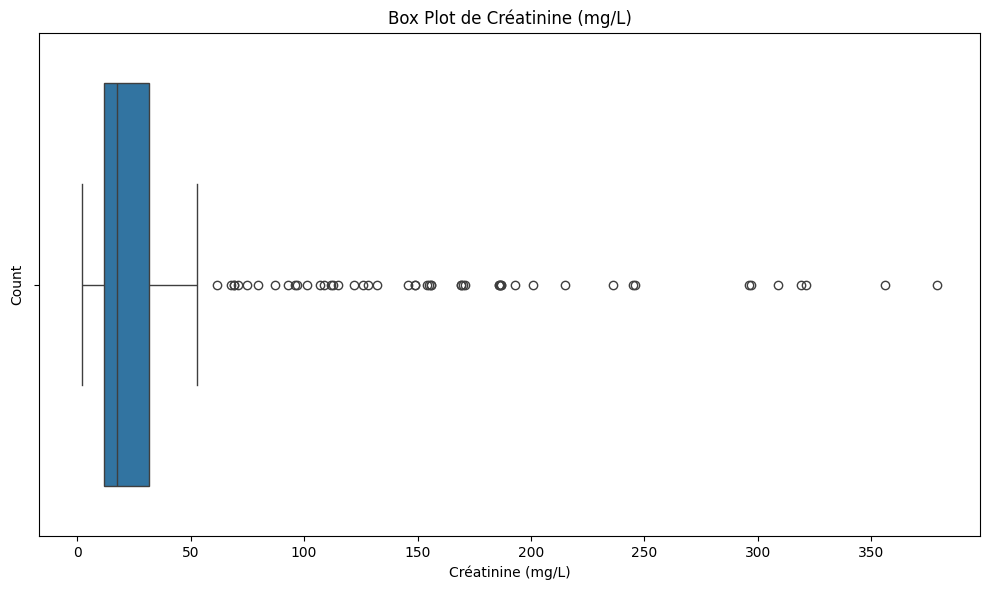

In [62]:
# afficher boxplot créatine
box_plot(df, 'Créatinine (mg/L)', 'Box Plot de Créatinine (mg/L)', 'Créatinine (mg/L)', 'Count')

In [63]:
# Afficher les valeurs aberrantes
outliers_Créat = detect_outliers_iqr(df, 'Créatinine (mg/L)')
outliers_Créat

Nombre de valeurs aberrantes détectées dans 'Créatinine (mg/L)' : 50


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
0    50.0             169.00                                NaN        1.29   
5    58.0             156.00                               1.75        1.58   
6    48.0             112.90                               1.78      189.00   
7    41.0             171.00                               0.80        1.14   
8    42.0             379.00                               0.65        3.03   
9    55.0              93.00                               3.77        2.13   
10   38.0             355.90                                NaN        3.22   
11   57.0             101.40                                NaN        1.50   
12   56.0              95.80                               0.96        1.78   
13   31.0             245.00                               0.84        2.03   
14   18.0              67.88                               1.09        1.45   
15   65.0             149.00                                NaN        1.26   
16   59.0             112.00                               2.42        2.63   
17   70.0             115.00                               0.59        1.63   
18   30.0              74.93                                NaN         NaN   
19   45.0             201.00                               1.35        4.41   
20   31.0             128.00                                NaN        0.43   
22   29.0             296.00                                NaN        2.12   
23   42.0             187.00                                NaN        1.57   
24   32.0             215.00                               0.98        2.54   
25   64.0             186.30                               0.84        2.24   
27   39.0              71.00                                NaN        1.84   
29   37.0             186.00                                NaN        2.41   
30   47.0             321.00                               1.17        4.20   
31   28.0             187.00                               1.67        2.16   
33   34.0             132.00                                NaN        1.40   
34   74.0              79.80                               0.93        1.78   
36   35.0             186.00                                NaN        2.31   
37   35.0             107.00                               1.58        1.32   
38   54.0             154.00                               0.79        2.68   
39   29.0             246.00                                NaN        2.51   
40   36.0             193.00                                NaN        2.12   
41   24.0              69.00                               0.74        1.14   
42   48.0              97.00                                NaN        0.85   
43   38.0             126.00                                NaN         NaN   
44   75.0             146.00                               1.17        2.26   
45   62.0             319.00                                NaN        2.44   
46   54.0             109.00                                NaN        2.13   
47   50.0             169.00                               0.76        1.45   
48   40.0             309.00                               0.96        4.41   
49   47.0             156.00                                NaN        2.07   
50   20.0             155.00                                NaN        2.34   
51   39.0              87.00                                NaN        1.30   
52   50.0             170.00                               0.75        1.37   
53   19.0             149.00                               1.12        1.79   
64   57.0              69.00                                NaN        0.80   
65   36.0             236.00                                NaN        1.46   
66   32.0             122.00                                NaN        2.13   
71   57.0             297.00                                NaN        2.13   
166  61.0              61.62                            

In [64]:
outliers_Créat['Stage de l\'IRC'].value_counts()

Stage de l'IRC
5    50
Name: count, dtype: int64

après compréhension de la variables créatinine et de comment elle interagit avec l'évalution du stade de l'IRC on peut considéré ces valeur manquante rencontre comme possible

choisie de surprprimer pour ne pas introduire des biais dans nos données

#### **Traitement Urée**

In [65]:
df['Urée (g/L)'].describe()

count    282.000000
mean       1.483826
std       11.343403
min        0.060000
25%        0.280000
50%        0.450000
75%        0.842500
max      189.000000
Name: Urée (g/L), dtype: float64

In [66]:
# afficher les valeur contenue dans cr
df['Urée (g/L)'].value_counts()

Urée (g/L)
0.30    11
0.28     8
0.22     8
0.41     7
0.19     7
        ..
0.63     1
0.06     1
0.76     1
0.90     1
1.16     1
Name: count, Length: 125, dtype: int64

In [67]:
print(df['Urée (g/L)'].isnull().sum())

21


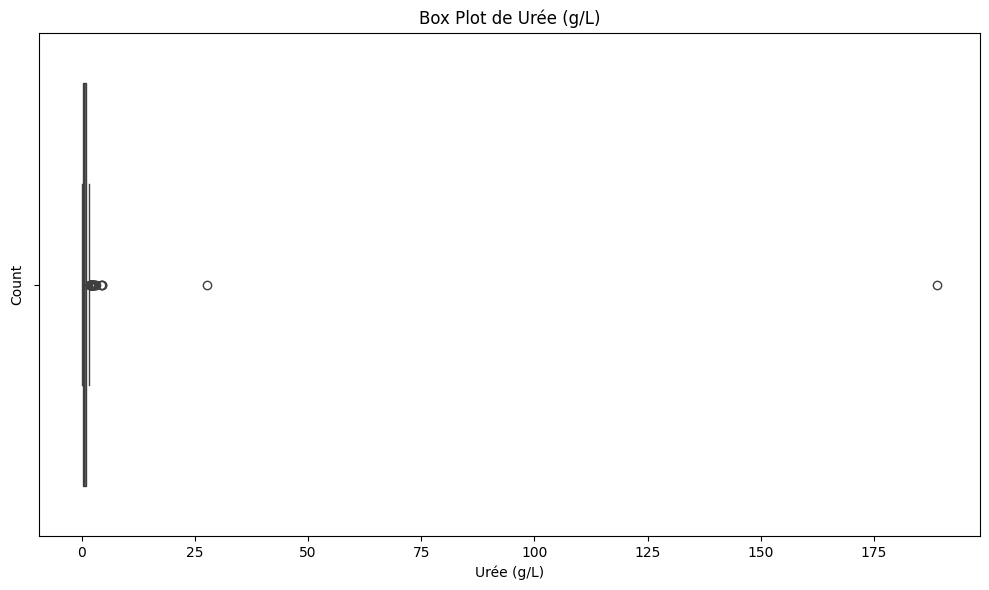

In [68]:
# afficher boxplot
box_plot(df, 'Urée (g/L)', 'Box Plot de Urée (g/L)', 'Urée (g/L)', 'Count')

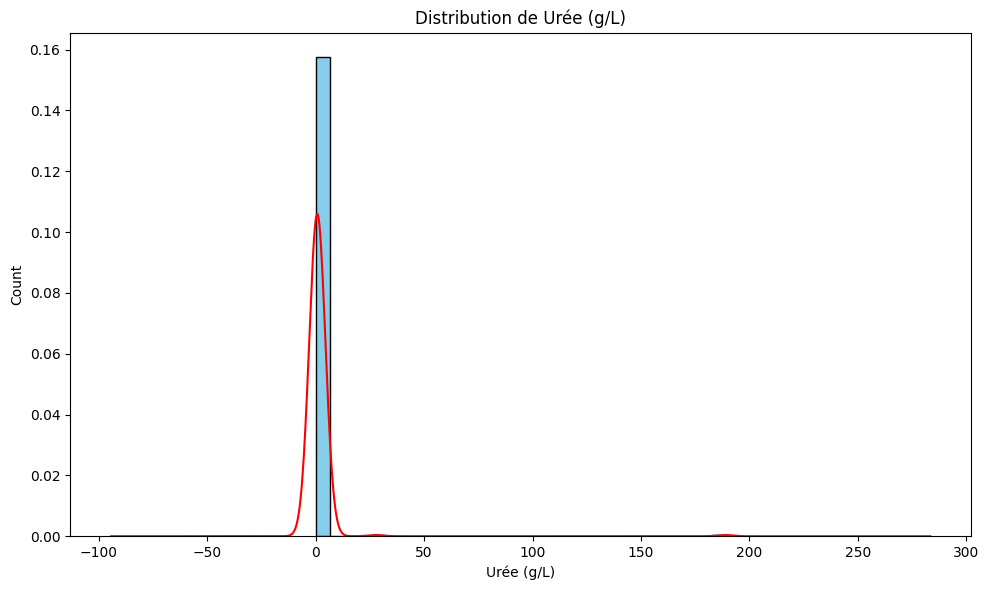

In [69]:
# distribution numérique de l'urée
plot_numeric_distribution(df, 'Urée (g/L)', 'Distribution de Urée (g/L)', 'Urée (g/L)', 'Count')

impution par la médiane car la distribution est normal et en plus on a des valeurs abérantes

In [70]:
# teste de sensibiliter avec stade de l'irc
results = analyse_sensibilite(df, 'Urée (g/L)', 'Stage de l\'IRC')
print(results)

{'Exclusion': np.float64(0.013611641050525007), 'Médiane': np.float64(0.013647353237872748), 'Moyenne': np.float64(0.013611641050524993)}


In [71]:
# imputer l'uree par la médianne
df['Urée (g/L)'] = df['Urée (g/L)'].fillna(df['Urée (g/L)'].median())

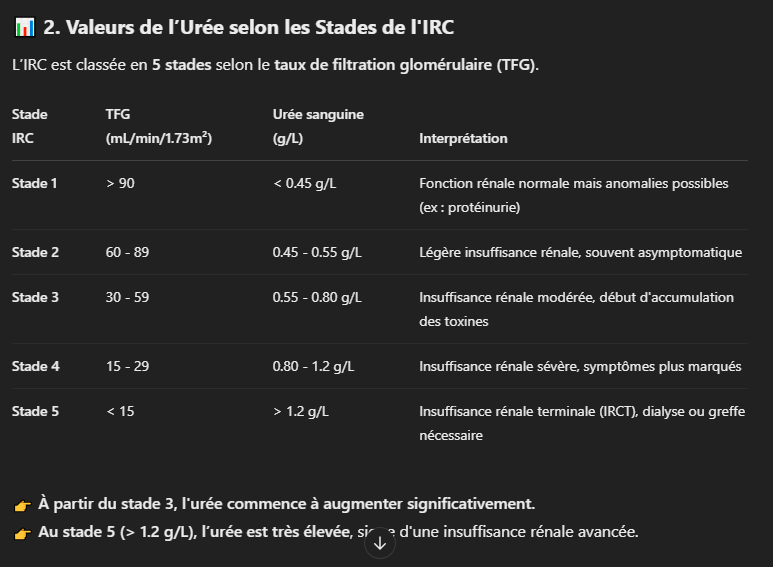

In [72]:
df[df['Urée (g/L)'] < 0 ]

Empty DataFrame
Columns: [Age, Créatinine (mg/L), Glycémie à jeun (taux de Glucose), Urée (g/L), Stage de l'IRC, Etat Général (EG) à l'Admission, Hb (g/dL), Na^+ (meq/L), K^+ (meq/L), Ca^2+ (meq/L), Pathologies/Rétinopathie diabétique, Sexe, Symptômes/Anémie, Symptômes/Asthénie, Symptômes/HTA, Symptômes/OMI, Symptômes/Oligurie, TA (mmHg)/Diastole, TA (mmHg)/Systole]
Index: []

In [73]:
df[df['Urée (g/L)'] > 1 ]

Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
0    50.0             169.00                                NaN        1.29   
3    68.0              42.00                               1.00        1.14   
5    58.0             156.00                               1.75        1.58   
6    48.0             112.90                               1.78      189.00   
7    41.0             171.00                               0.80        1.14   
8    42.0             379.00                               0.65        3.03   
9    55.0              93.00                               3.77        2.13   
10   38.0             355.90                                NaN        3.22   
11   57.0             101.40                                NaN        1.50   
12   56.0              95.80                               0.96        1.78   
13   31.0             245.00                               0.84        2.03   
14   18.0              67.88                               1.09        1.45   
15   65.0             149.00                                NaN        1.26   
16   59.0             112.00                               2.42        2.63   
17   70.0             115.00                               0.59        1.63   
19   45.0             201.00                               1.35        4.41   
22   29.0             296.00                                NaN        2.12   
23   42.0             187.00                                NaN        1.57   
24   32.0             215.00                               0.98        2.54   
25   64.0             186.30                               0.84        2.24   
27   39.0              71.00                                NaN        1.84   
29   37.0             186.00                                NaN        2.41   
30   47.0             321.00                               1.17        4.20   
31   28.0             187.00                               1.67        2.16   
33   34.0             132.00                                NaN        1.40   
34   74.0              79.80                               0.93        1.78   
35   48.0              47.52                               1.15        1.55   
36   35.0             186.00                                NaN        2.31   
37   35.0             107.00                               1.58        1.32   
38   54.0             154.00                               0.79        2.68   
39   29.0             246.00                                NaN        2.51   
40   36.0             193.00                                NaN        2.12   
41   24.0              69.00                               0.74        1.14   
44   75.0             146.00                               1.17        2.26   
45   62.0             319.00                                NaN        2.44   
46   54.0             109.00                                NaN        2.13   
47   50.0             169.00                               0.76        1.45   
48   40.0             309.00                               0.96        4.41   
49   47.0             156.00                                NaN        2.07   
50   20.0             155.00                                NaN        2.34   
51   39.0              87.00                                NaN        1.30   
52   50.0             170.00                               0.75        1.37   
53   19.0             149.00                               1.12        1.79   
65   36.0             236.00                                NaN        1.46   
66   32.0             122.00                                NaN        2.13   
71   57.0             297.00                                NaN        2.13   
75   41.0              53.00                               0.98        1.05   
164  37.0              35.00                                NaN        1.41   
183  62.0              23.00                               0.92        1.17   
202  60.0              34.68                            

* on remarque 189.0	 d'Urée pour un stade de 5 ce qui pourrait etre considéré comme un erreur de saisie
* 27.7 Urée pour une stade de 1 peut relever d'une incohérence dans les données car pour ce même patien on a une créatinine a 2.18 relativement faible ce qui devrais etre le cas aussi de l'Uréé  

In [74]:
# Remplacer la valeur 189.0 par 1.89 dans la colonne 'Urée (g/L)'
df.loc[df['Urée (g/L)'] == 189.0, 'Urée (g/L)'] = 1.89
# df.loc[df['Urée (g/L)'] == 27.7, 'Urée (g/L)'] = 0.27
df.drop(df[(df['Urée (g/L)'] == 27.7) & (df["Stage de l\'IRC"] == 1)].index, inplace=True)

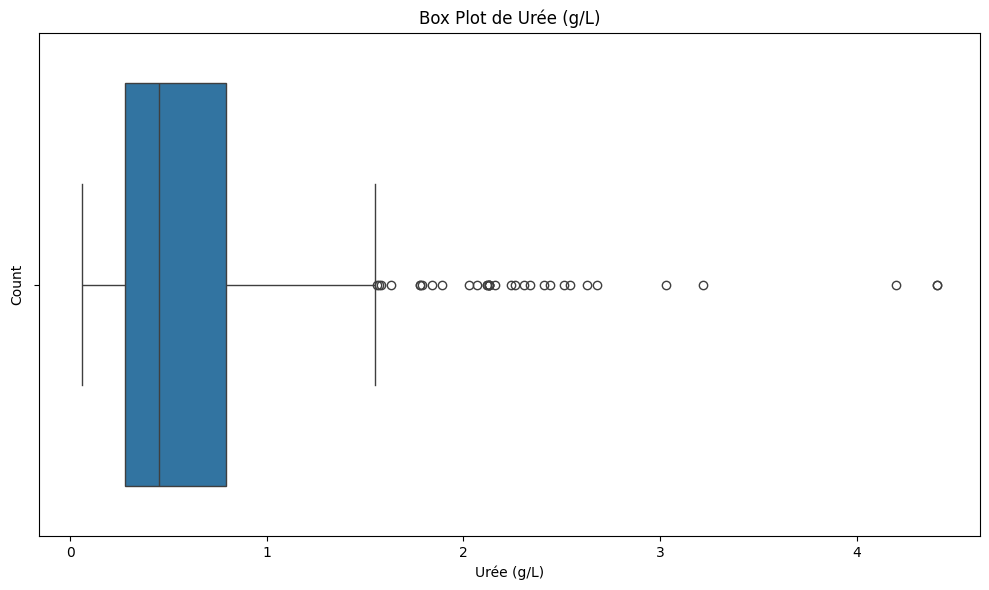

In [75]:
# afficher boxplot
box_plot(df, 'Urée (g/L)', 'Box Plot de Urée (g/L)', 'Urée (g/L)', 'Count')

In [76]:
Q1 = df['Urée (g/L)'].quantile(0.25)
Q3 = df['Urée (g/L)'].quantile(0.75)
IQR = Q3 - Q1

# Définir les limites pour les valeurs aberrantes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifier les valeurs aberrantes
outliers = df[(df['Urée (g/L)'] < lower_bound) | (df['Urée (g/L)'] > upper_bound)]

# Afficher les valeurs aberrantes
print(outliers.shape)

(33, 19)


In [77]:
outliers

Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
5    58.0             156.00                               1.75        1.58   
6    48.0             112.90                               1.78        1.89   
8    42.0             379.00                               0.65        3.03   
9    55.0              93.00                               3.77        2.13   
10   38.0             355.90                                NaN        3.22   
12   56.0              95.80                               0.96        1.78   
13   31.0             245.00                               0.84        2.03   
16   59.0             112.00                               2.42        2.63   
17   70.0             115.00                               0.59        1.63   
19   45.0             201.00                               1.35        4.41   
22   29.0             296.00                                NaN        2.12   
23   42.0             187.00                                NaN        1.57   
24   32.0             215.00                               0.98        2.54   
25   64.0             186.30                               0.84        2.24   
27   39.0              71.00                                NaN        1.84   
29   37.0             186.00                                NaN        2.41   
30   47.0             321.00                               1.17        4.20   
31   28.0             187.00                               1.67        2.16   
34   74.0              79.80                               0.93        1.78   
36   35.0             186.00                                NaN        2.31   
38   54.0             154.00                               0.79        2.68   
39   29.0             246.00                                NaN        2.51   
40   36.0             193.00                                NaN        2.12   
44   75.0             146.00                               1.17        2.26   
45   62.0             319.00                                NaN        2.44   
46   54.0             109.00                                NaN        2.13   
48   40.0             309.00                               0.96        4.41   
49   47.0             156.00                                NaN        2.07   
50   20.0             155.00                                NaN        2.34   
53   19.0             149.00                               1.12        1.79   
66   32.0             122.00                                NaN        2.13   
71   57.0             297.00                                NaN        2.13   
202  60.0              34.68                               1.22        1.56   

     Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
5                 5                              0.5       6.60         130.0   
6                 5                              0.5      12.40         133.5   
8                 5                              0.5       8.80         141.0   
9                 5                              0.5       8.60         123.0   
10                5                              0.0       5.80         138.6   
12                5                              1.0       9.00         136.0   
13                5                              0.5       5.90         139.0   
16                5                              0.5       6.80         135.0   
17                5                              0.0       6.20         129.0   
19                5                              0.0       6.90         129.0   
22                5                              0.0       5.40         125.0   
23                5                              1.0      13.20         139.0   
24                5                              1.0       7.10         116.0   
25                5                              0.5       6.40         135.0   
27                5                              0.5       4.30         137.0   
29                5    

In [78]:
outliers['Stage de l\'IRC'].value_counts()

Stage de l'IRC
5    32
4     1
Name: count, dtype: int64

Il n'y a pas de valeur abbérante apres compréhention de la variable Uréé et son influence sur le stade de l'IRC et des valeur possible pour chaque stade de l'IRC

#### **Traitement des valeurs non numériques dans la colonne TA**

In [79]:
df['TA (mmHg)/Systole'] = df['TA (mmHg)/Systole'].apply(convert_to_numeric)
# df = df.dropna(subset=['TA (mmHg)/Systole'])

df['TA (mmHg)/Diastole'] = df['TA (mmHg)/Diastole'].apply(convert_to_numeric)
# df = df.dropna(subset=['TA (mmHg)/Diastole'])

In [80]:
# vérification valeur manquante
print(df['TA (mmHg)/Systole'].isnull().sum())
print(df['TA (mmHg)/Diastole'].isnull().sum())

61
61


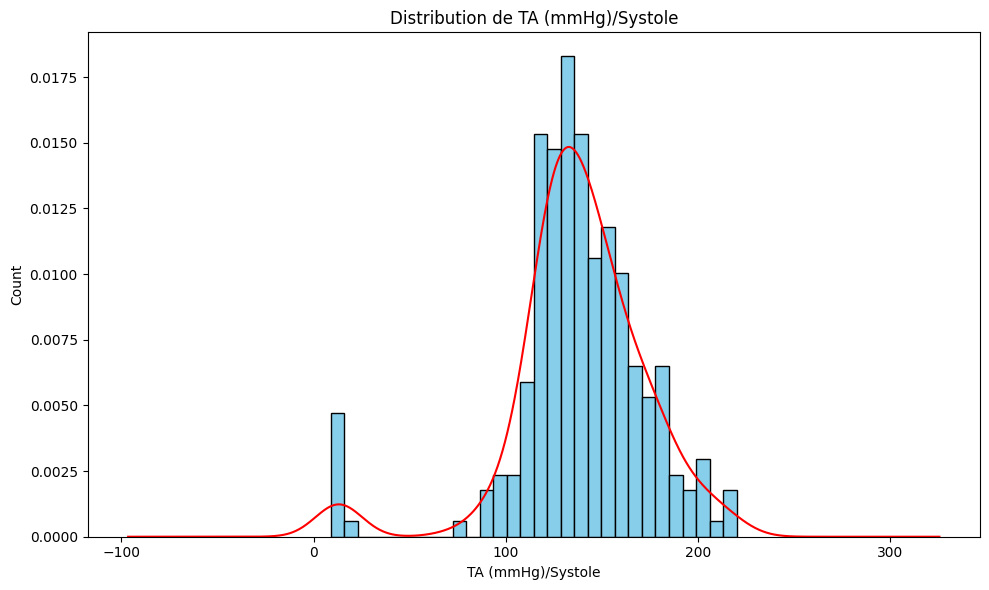

In [81]:
# distribution des variable
plot_numeric_distribution(df, 'TA (mmHg)/Systole', 'Distribution de TA (mmHg)/Systole', 'TA (mmHg)/Systole', 'Count')

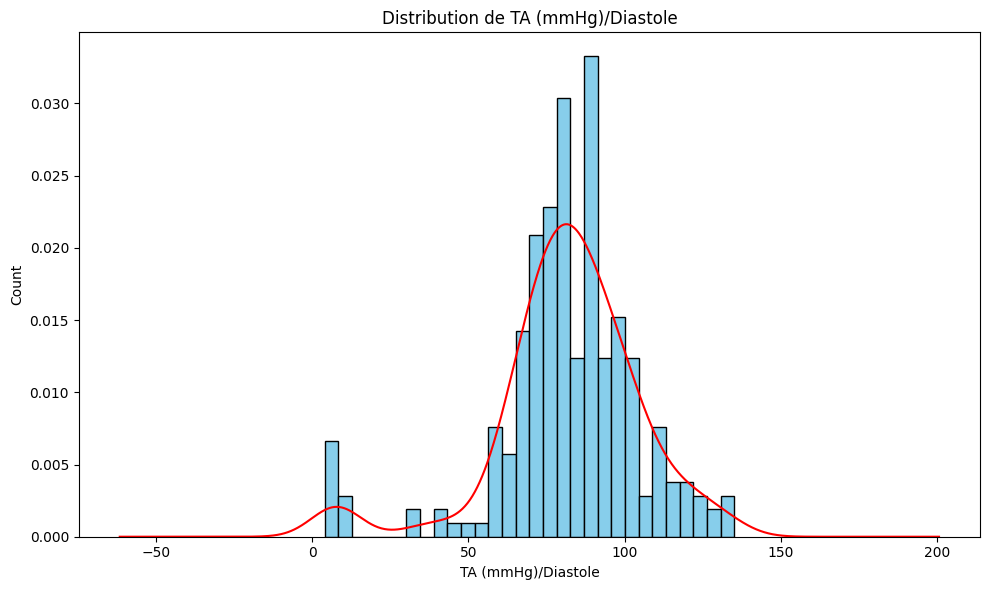

In [82]:
# distribution des variable
plot_numeric_distribution(df, 'TA (mmHg)/Diastole', 'Distribution de TA (mmHg)/Diastole', 'TA (mmHg)/Diastole', 'Count')

In [83]:
# Imputation par la médiane pour toutes les colonnes choisies
cols_to_impute = ['TA (mmHg)/Diastole', 'TA (mmHg)/Systole']  # à adapter à ton cas

def robust_median_impute(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Exclure les outliers pour calculer la médiane
    clean_values = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)][col]
    median = clean_values.median()

    df[col].fillna(median, inplace=True)
    return df

# Application
for col in cols_to_impute:
    df = robust_median_impute(df, col)


utillisation l'imputation par la régression car les variables TA (mmHg)/Diastole & TA (mmHg)/Systole sont corrélé avec l'Anémie , la Créatinine et le stage de l'IRC  

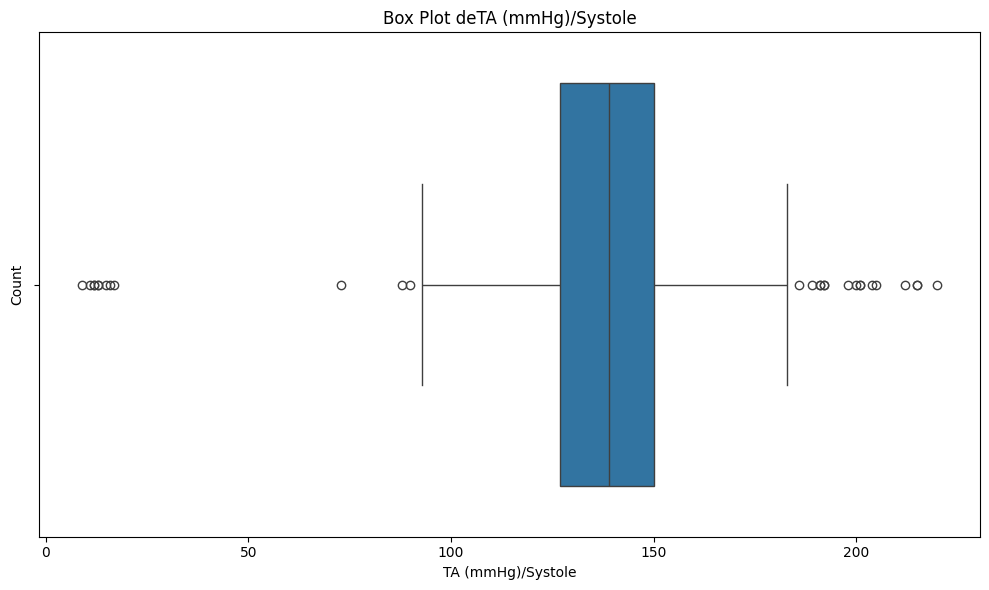

In [84]:
# afficher box plot des TA
# afficher boxplot
box_plot(df, 'TA (mmHg)/Systole', 'Box Plot deTA (mmHg)/Systole', 'TA (mmHg)/Systole', 'Count')

In [85]:
# Afficher les valeurs aberrantes
outliers_TAS = detect_outliers_iqr(df, 'TA (mmHg)/Systole')
outliers_TAS

Nombre de valeurs aberrantes détectées dans 'TA (mmHg)/Systole' : 28


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
7    41.0             171.00                               0.80       1.140   
16   59.0             112.00                               2.42       2.630   
22   29.0             296.00                                NaN       2.120   
23   42.0             187.00                                NaN       1.570   
29   37.0             186.00                                NaN       2.410   
30   47.0             321.00                               1.17       4.200   
41   24.0              69.00                               0.74       1.140   
43   38.0             126.00                                NaN       0.450   
56   88.0              29.00                               0.95       0.410   
65   36.0             236.00                                NaN       1.460   
81   71.0              24.00                               2.20       0.460   
90   66.0              17.40                               0.92       0.320   
136  64.0              15.00                               0.78       0.690   
167  68.0              12.20                               1.28       0.169   
170  33.0               9.00                               0.93       0.240   
171  37.0              20.00                                NaN       0.480   
178  40.0              27.00                               0.81       0.410   
204  71.0               8.00                               2.37       0.270   
215  48.0              27.00                                NaN       0.650   
224  37.0              19.00                                NaN       1.230   
229  27.0              28.86                               0.86       0.710   
230  47.0              23.80                                NaN       0.780   
234  59.0              10.00                               0.82       0.230   
255  50.0              10.52                               1.29       0.450   
258  56.0              13.00                               2.37       0.230   
270  47.0              38.00                               1.36       0.760   
271  42.0              25.00                               0.91       0.820   
304  65.0              12.00                               0.99       0.490   

     Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
7                 5                              0.5        NaN         140.0   
16                5                              0.5        6.8         135.0   
22                5                              0.0        5.4         125.0   
23                5                              1.0       13.2         139.0   
29                5                              0.5       10.0         132.0   
30                5                              0.0        4.3         139.0   
41                5                              1.0        8.3         138.0   
43                5                              0.5        9.1         133.0   
56                4                              1.0        9.9         143.0   
65                5                              0.5        6.9         120.0   
81                3                              1.0       15.6         140.0   
90                3                              1.0       14.9         145.5   
136               2                              1.0       12.5         141.0   
167               2                              0.5       17.0           NaN   
170               1                              1.0       14.1         138.0   
171               3                              0.0        NaN         140.0   
178               4                              0.5        9.2         139.0   
204               2                              0.5       13.1         142.0   
215               4                              0.5        8.3         143.0   
224               3                              0.5        NaN           NaN   
229          

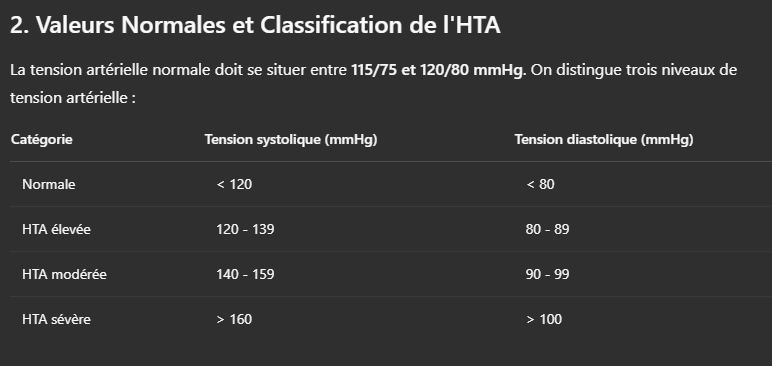

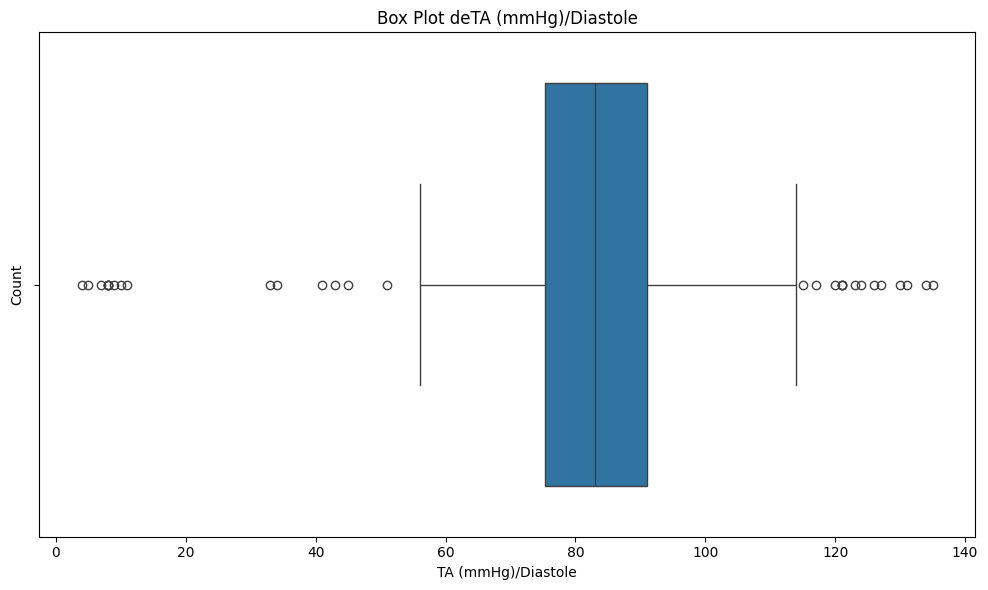

In [86]:
box_plot(df, 'TA (mmHg)/Diastole', 'Box Plot deTA (mmHg)/Diastole', 'TA (mmHg)/Diastole', 'Count')

In [87]:
# Afficher les valeurs aberrantes
outliers_TAD = detect_outliers_iqr(df, 'TA (mmHg)/Diastole')
outliers_TAD

Nombre de valeurs aberrantes détectées dans 'TA (mmHg)/Diastole' : 30


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
2    69.0              48.00                               2.87       0.790   
7    41.0             171.00                               0.80       1.140   
16   59.0             112.00                               2.42       2.630   
22   29.0             296.00                                NaN       2.120   
23   42.0             187.00                                NaN       1.570   
30   47.0             321.00                               1.17       4.200   
33   34.0             132.00                                NaN       1.400   
34   74.0              79.80                               0.93       1.780   
36   35.0             186.00                                NaN       2.310   
37   35.0             107.00                               1.58       1.320   
43   38.0             126.00                                NaN       0.450   
61   64.0               7.00                               2.40       0.220   
65   36.0             236.00                                NaN       1.460   
81   71.0              24.00                               2.20       0.460   
83   57.0              35.00                                NaN       0.770   
167  68.0              12.20                               1.28       0.169   
170  33.0               9.00                               0.93       0.240   
171  37.0              20.00                                NaN       0.480   
172  63.0              20.10                                NaN       0.950   
178  40.0              27.00                               0.81       0.410   
188  64.0              32.00                                NaN       0.750   
215  48.0              27.00                                NaN       0.650   
224  37.0              19.00                                NaN       1.230   
229  27.0              28.86                               0.86       0.710   
230  47.0              23.80                                NaN       0.780   
234  59.0              10.00                               0.82       0.230   
255  50.0              10.52                               1.29       0.450   
258  56.0              13.00                               2.37       0.230   
271  42.0              25.00                               0.91       0.820   
277  28.0              24.50                               0.71       0.290   

     Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
2                 5                              0.0        9.6         139.0   
7                 5                              0.5        NaN         140.0   
16                5                              0.5        6.8         135.0   
22                5                              0.0        5.4         125.0   
23                5                              1.0       13.2         139.0   
30                5                              0.0        4.3         139.0   
33                5                              1.0        8.0         139.0   
34                5                              0.0        6.5         130.7   
36                5                              1.0        3.4         132.0   
37                5                              0.5       10.9         137.0   
43                5                              0.5        9.1         133.0   
61                1                              1.0       14.3         142.0   
65                5                              0.5        6.9         120.0   
81                3                              1.0       15.6         140.0   
83                3                              0.5        7.7         139.0   
167               2                              0.5       17.0           NaN   
170               1                              1.0       14.1         138.0   
171               3                              0.0        NaN         140.0   
172              

 il n'y a pas de valeurs abbérante a proprement parlé d'apres la compréhension du dataset

#### **Traitement Hb**

 Seuils d'hémoglobine recommandés chez les patients IRC :

🔴 Anémie sévère : Hb < 9 g/dL

🟡 Anémie modérée : Hb entre 9 et 11 g/dL

🟢 Normal : Hb ≥ 11 g/dL

les valeurs normales d’hémoglobine sont généralement exprimées en g/dL et se situent dans les plages suivantes :

Hommes : 13 à 17 g/dL

Femmes : 12 à 16 g/dL

Enfants : 11 à 14 g/dL

In [88]:
# valeur manquante
print(df['Hb (g/dL)'].isnull().sum())

49


In [89]:
df['Hb (g/dL)'].unique()

array([ 11.4 ,   9.5 ,   9.6 ,   8.2 ,   6.6 ,  12.4 ,    nan,   8.8 ,
         8.6 ,   5.8 ,   8.1 ,   9.  ,   5.9 ,   5.4 ,   6.8 ,   6.2 ,
         6.4 ,   6.9 ,   6.7 ,  14.7 ,  13.2 ,   7.1 ,   4.3 ,  10.  ,
         6.1 ,  10.7 ,   8.  ,   6.5 ,   3.4 ,  10.9 ,   8.3 ,   3.2 ,
         9.1 ,   7.5 ,   9.3 ,  10.68,   7.3 ,   9.9 ,  13.7 ,  14.3 ,
        12.9 ,  12.7 ,  14.1 ,  15.3 ,   9.4 ,  12.6 ,   8.7 ,  11.3 ,
         9.2 ,  15.9 ,  12.3 ,  15.6 ,   7.7 ,  11.5 ,  10.4 ,  13.5 ,
        14.9 ,  11.8 ,  10.6 , 111.  ,  11.1 ,  12.8 ,  13.3 ,  10.2 ,
        17.3 ,  16.  ,  16.9 ,   9.7 ,  15.2 ,  12.1 ,  11.7 ,  14.5 ,
        13.1 ,  11.9 ,  13.4 ,  15.8 ,  13.8 ,  12.5 ,  15.5 ,  10.1 ,
        11.  ,  13.  ,  15.  ,  10.8 ,  14.8 ,  11.2 ,   8.5 ,   7.  ,
        17.  ,  11.21,  85.  ,  13.9 ,   4.7 ,   9.98,  12.2 ,  10.5 ,
        15.1 ,  14.4 ,  12.  ,  10.3 ,   9.8 ,  92.26,  11.98, 118.  ,
         8.9 ,  11.6 ])

En général, les taux d'hémoglobine normaux sont les suivants: Pour les hommes adultes: 13,8 à 17,2 grammes par décilitre (g/dL) Pour les femmes adultes: 12,1 à 15,1 g/dL.

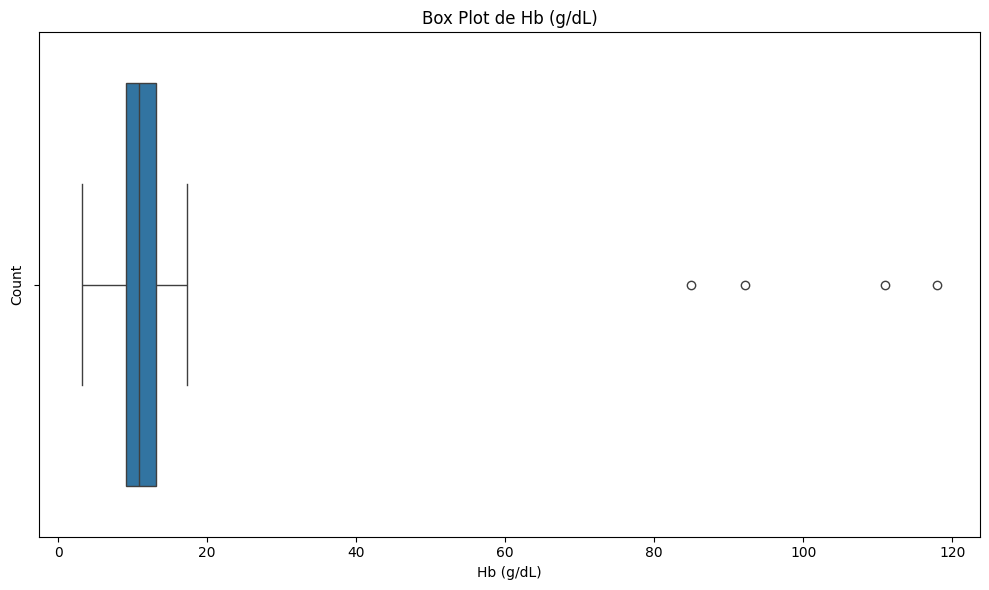

In [90]:
# afficher boxplot
box_plot(df, 'Hb (g/dL)', 'Box Plot de Hb (g/dL)', 'Hb (g/dL)', 'Count')

In [91]:
# Afficher les valeurs aberrantes
outliers_h = detect_outliers_iqr(df, 'Hb (g/dL)')

outliers_h

Nombre de valeurs aberrantes détectées dans 'Hb (g/dL)' : 4


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
93   42.0               29.0                                NaN        0.32   
183  62.0               23.0                               0.92        1.17   
268  31.0                5.3                               1.61        0.06   
278  81.0               24.0                               0.79        1.16   

     Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
93                3                              0.5     111.00         130.0   
183               4                              0.0      85.00         146.0   
268               1                              1.0      92.26         133.0   
278               4                              0.5     118.00         143.0   

     K^+ (meq/L)  Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
93          4.07            NaN                                    0   1.0   
183         4.50            NaN                                    0   1.0   
268         3.60           91.9                                    0   0.0   
278         4.90           96.0                                    0   0.0   

     Symptômes/Anémie  Symptômes/Asthénie  Symptômes/HTA  Symptômes/OMI  \
93                  0                   0              0              0   
183                 0                   1              0              1   
268                 0                   0              0              0   
278                 0                   1              0              1   

     Symptômes/Oligurie  TA (mmHg)/Diastole  TA (mmHg)/Systole  
93                    0               114.0              174.0  
183                   0                68.0              144.0  
268                   0                69.0              114.0  
278                   0                69.0              130.0

on observe des valeurs qui ne reste pas dans la marge des variable et trop grandre par rapport au seuil pouvant atteindre le taux hémoglobine comme **111.00** , **85.00**,  **118.00** il peux s'agire d'erreur de saisie et que les virgule on été mal placée . Quand au autre valeur abbérante il reflète juste un stade de L'IRC évolué notamment de stade 5 avec des taux hémoglobine anormalement bas ce qui est normal

In [92]:
# Remplacer les valeur considérée comme mal saisie dans la colonne 'Hb (g/dL)'
df.loc[df['Hb (g/dL)'] == 118.00	, 'Hb (g/dL)'] = 11.80
df.loc[df['Hb (g/dL)'] == 85.00	, 'Hb (g/dL)'] = 8.50
df.loc[df['Hb (g/dL)'] == 111.00	, 'Hb (g/dL)'] = 11.10

# surprimer ligne ou hb = **92.26**
df.drop(df[df['Hb (g/dL)'] == 92.26].index, inplace=True)

#### **Traitements K**

Norme : 3.5 - 5.0 mEq/L

Hyperkaliémie (taux élevé) : > 5.0 mEq/L

Hypokaliémie (taux bas) : < 3.5 mEq/L

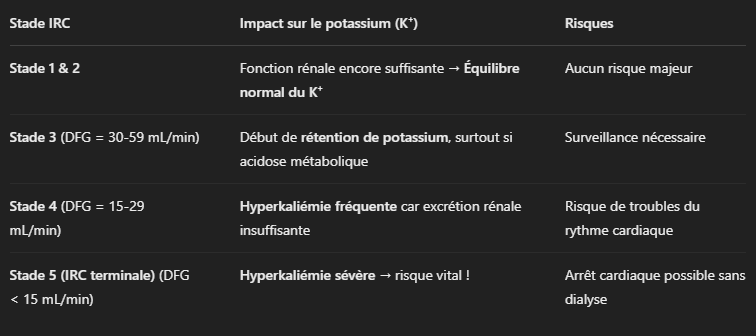

In [93]:
df['K^+ (meq/L)'].unique()

array([ 6.4 ,  5.3 ,  3.4 ,  5.7 ,  5.1 ,  4.01,  3.8 ,  4.1 ,  6.6 ,
        4.78,  5.6 ,  4.8 ,  1.6 ,  5.2 ,  4.5 ,  4.57,  5.33,  3.77,
        5.9 ,  4.  ,  3.5 ,  4.2 ,  5.  ,  4.82,  6.01,  3.9 ,  4.9 ,
        4.6 ,  3.7 ,  5.5 , 36.  ,   nan,  4.3 ,  2.8 ,  4.4 ,  3.3 ,
        1.8 , 43.  ,  2.9 ,  3.  ,  5.4 ,  4.7 ,  3.2 ,  4.07,  3.59,
        4.29,  3.6 ,  4.12,  3.57,  2.1 ,  4.17,  3.61,  4.04,  3.03,
        3.93,  3.74,  4.21,  4.14,  4.45,  5.64,  3.24, 41.  ,  3.39,
        3.99,  3.79,  4.85,  4.56,  9.17,  3.88,  5.47,  3.71,  5.24,
        6.1 ])

In [94]:
# valeur manquant
print(df['K^+ (meq/L)'].isnull().sum())

27


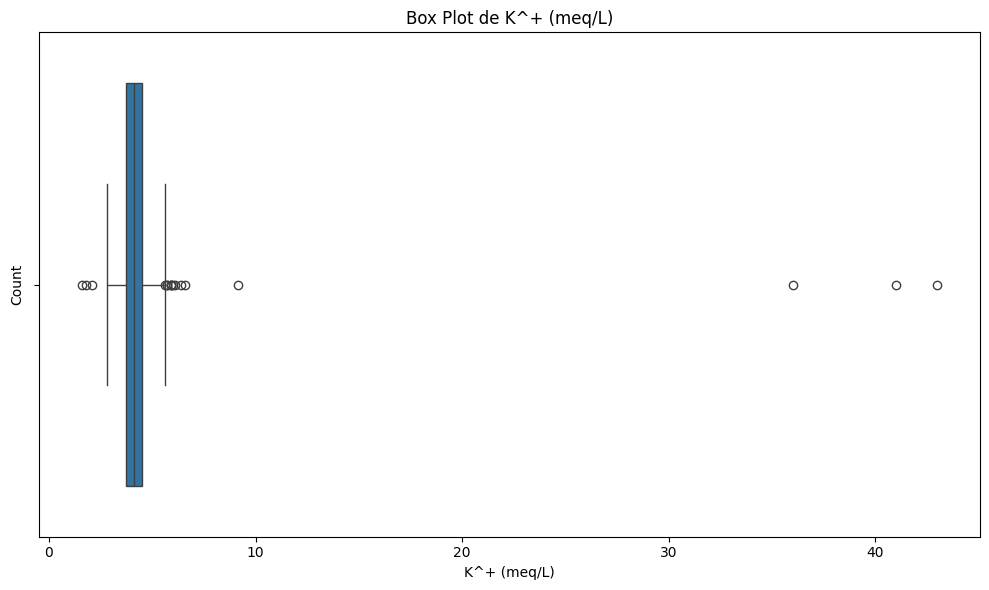

In [95]:
# Afficher boxplot
box_plot(df, 'K^+ (meq/L)', 'Box Plot de K^+ (meq/L)', 'K^+ (meq/L)', 'Count')

In [96]:
# Afficher les valeurs aberrantes
outliers_k = detect_outliers_iqr(df, 'K^+ (meq/L)')
outliers_k

Nombre de valeurs aberrantes détectées dans 'K^+ (meq/L)' : 17


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
0    50.0             169.00                                NaN        1.29   
3    68.0              42.00                               1.00        1.14   
10   38.0             355.90                                NaN        3.22   
15   65.0             149.00                                NaN        1.26   
22   29.0             296.00                                NaN        2.12   
27   39.0              71.00                                NaN        1.84   
35   48.0              47.52                               1.15        1.55   
47   50.0             169.00                               0.76        1.45   
49   47.0             156.00                                NaN        2.07   
64   57.0              69.00                                NaN        0.80   
65   36.0             236.00                                NaN        1.46   
122  57.0              11.00                               1.08        0.22   
217  48.0              14.44                                NaN        0.22   
233  61.0              33.00                                NaN        0.91   
257  79.0              16.72                                NaN        0.42   
275  60.0              30.00                               1.55        0.90   
305  76.0              13.00                               0.79        0.45   

     Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
0                 5                              0.0       11.4         131.0   
3                 5                              0.0        8.2         142.0   
10                5                              0.0        5.8         138.6   
15                5                              0.0        6.6         114.0   
22                5                              0.0        5.4         125.0   
27                5                              0.5        4.3         137.0   
35                5                              0.0        6.8         142.8   
47                5                              0.5        9.3         140.0   
49                5                              0.0        6.2         138.0   
64                5                              0.5        7.3         138.0   
65                5                              0.5        6.9         120.0   
122               1                              1.0       15.2         138.0   
217               3                              1.0       11.5         147.1   
233               4                              0.0       10.4         141.0   
257               3                              1.0       10.4         142.0   
275               4                              1.0        9.8         135.0   
305               3                              1.0       11.9         140.0   

     K^+ (meq/L)  Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
0           6.40          82.00                                    0   0.0   
3           5.70          88.00                                    0   1.0   
10          6.60            NaN                                    0   1.0   
15          1.60          70.00                                    0   1.0   
22          5.90            NaN                                    0   1.0   
27          5.90            NaN                                    0   1.0   
35          6.01          79.50                                    0   1.0   
47         36.00          96.00                                    0   1.0   
49          5.70            NaN                                    0   1.0   
64          1.80            NaN                                    0   0.0   
65         43.00            NaN                                    0   0.0   
122         2.10          88.00                                    0   1.0   
217         5.64         100.00                                    0   0.0   
233        41.00         101.57 

On observe quelque valeur énorme qu'on peut considéré comme des erreur de saisi et a la fois des valeurs possible mais juste qu'il traduise un stade avancé de la maladie et donc soir un hypokaliémie ou une hyperkaliémie

In [97]:
# Remplacer les valeur considérée comme mal saisie dans la colonne 'K^+ (meq/L)'
df.loc[df['K^+ (meq/L)'] == 41.00		, 'K^+ (meq/L)'] = 4.10
df.loc[df['K^+ (meq/L)'] == 43.00		, 'K^+ (meq/L)'] = 4.30
df.loc[df['K^+ (meq/L)'] == 36.00		, 'K^+ (meq/L)'] = 3.60

#supprimer colonne avec 9.17	pour K+
df.drop(df[df['K^+ (meq/L)'] == 9.17].index, inplace=True)


#### **Traitement Na**

🔹 Valeurs normales du sodium sanguin
✅ Norme : 135 - 145 mEq/L

🔻 Hyponatrémie : < 135 mEq/L

🔺 Hypernatrémie : > 145 mEq/L

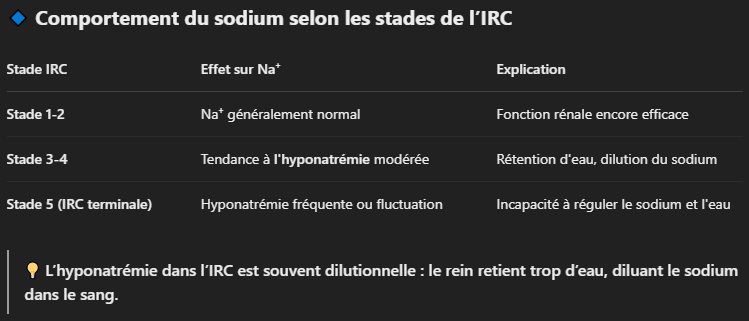

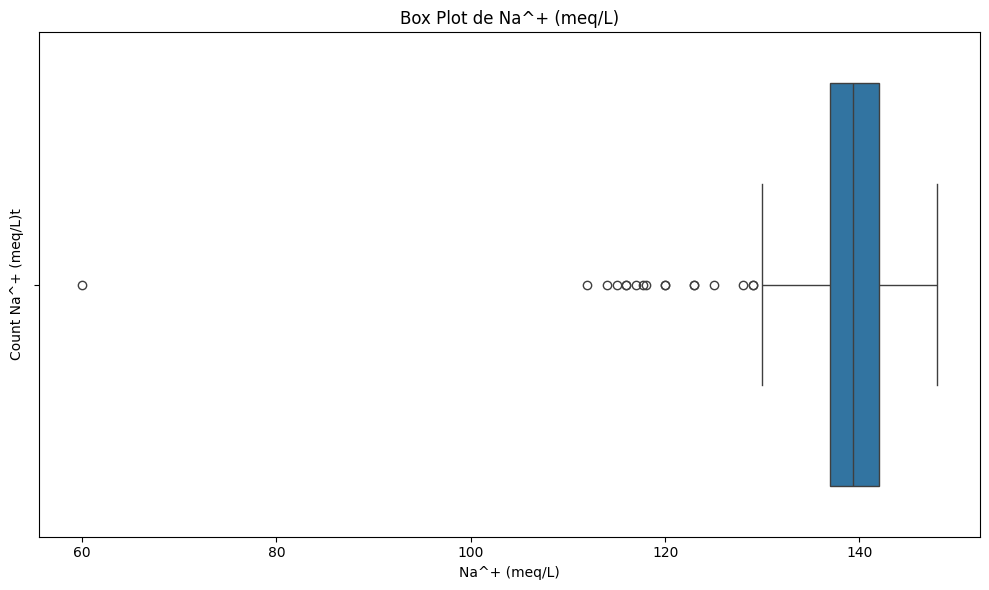

In [98]:
# Afficher box plot
box_plot(df, 'Na^+ (meq/L)', 'Box Plot de Na^+ (meq/L)', 'Na^+ (meq/L)', 'Count Na^+ (meq/L)t')

In [99]:
# Afficher les valeurs aberrantes
outliers_k = detect_outliers_iqr(df, 'Na^+ (meq/L)')
outliers_k

Nombre de valeurs aberrantes détectées dans 'Na^+ (meq/L)' : 17


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
9    55.0              93.00                               3.77        2.13   
11   57.0             101.40                                NaN        1.50   
15   65.0             149.00                                NaN        1.26   
17   70.0             115.00                               0.59        1.63   
19   45.0             201.00                               1.35        4.41   
20   31.0             128.00                                NaN        0.43   
22   29.0             296.00                                NaN        2.12   
24   32.0             215.00                               0.98        2.54   
38   54.0             154.00                               0.79        2.68   
46   54.0             109.00                                NaN        2.13   
65   36.0             236.00                                NaN        1.46   
106  72.0              14.30                               0.86        0.81   
147  63.0              28.30                               1.41        0.78   
177  49.0              13.00                               2.39        0.32   
209  85.0               7.15                                NaN        0.45   
283  66.0              17.84                                NaN        0.81   
284  63.0              28.00                                NaN        0.67   

     Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
9                 5                              0.5        8.6         123.0   
11                5                              1.0        8.1         117.7   
15                5                              0.0        6.6         114.0   
17                5                              0.0        6.2         129.0   
19                5                              0.0        6.9         129.0   
20                5                              0.5        6.7          60.0   
22                5                              0.0        5.4         125.0   
24                5                              1.0        7.1         116.0   
38                5                              0.0        8.3         112.0   
46                5                              0.0        9.5         120.0   
65                5                              0.5        6.9         120.0   
106               3                              0.5        9.9         123.0   
147               4                              1.0       14.3         117.0   
177               3                              1.0       10.4         116.0   
209               2                              0.0        NaN         128.0   
283               3                              0.0        9.6         118.0   
284               4                              0.0       12.2         115.0   

     K^+ (meq/L)  Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
9           4.10          85.00                                    0   0.0   
11          4.78            NaN                                    0   0.0   
15          1.60          70.00                                    0   1.0   
17          4.50          81.00                                    0   0.0   
19          5.33          94.15                                    0   1.0   
20          3.77          84.00                                    0   1.0   
22          5.90            NaN                                    0   1.0   
24          3.50          95.00                                    0   1.0   
38          3.90          86.00                                    0   1.0   
46          3.50          81.00                                    0   1.0   
65          4.30            NaN                                    0   0.0   
106         4.70          85.00                                    0   1.0   
147         4.20          94.00                                    0   1.0   
177         4.10          97.00 

### **Traitement Glycémie à jeun (taux de Glucose)**

Quelle est le taux de glycémie à jeun normal ? La glycémie normale se situe entre 0,70 et 1,10 g par litre de sang à jeun. Pour la glycémie postprandiale, c'est-à-dire 2h après un repas, le taux de sucre doit être inférieur à 1,40 g par litre. Lorsque la glycémie est basse, celle-ci est inférieure à 0,70 g par litre.

Quel taux de glycémie dangereux ? Quel taux pour être diabétique ? Un taux de glycémie trop bas (hypoglycémie) c'est à dire qui est inférieur à 0,70g par litre à jeun peut être dangereux pour la santé; tout comme un taux de sucre trop élevé (hyperglycémie), c'est à dire supérieur à 1,26g par litre à jeun.

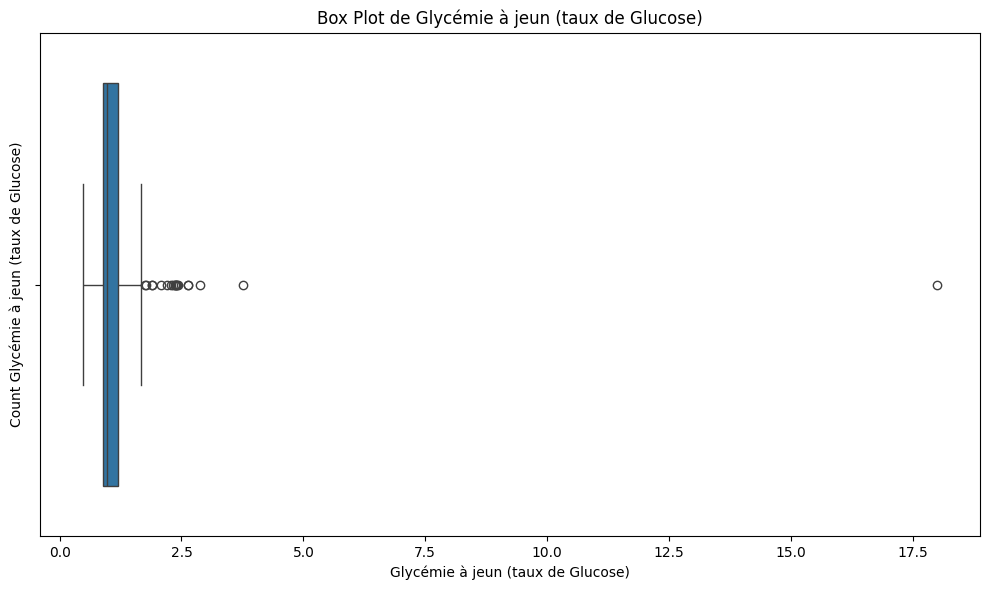

In [100]:
# box plot Glycemie a jeun
box_plot(df, 'Glycémie à jeun (taux de Glucose)', 'Box Plot de Glycémie à jeun (taux de Glucose)', 'Glycémie à jeun (taux de Glucose)', 'Count Glycémie à jeun (taux de Glucose)')

In [101]:
# outliers
outliers_G = detect_outliers_iqr(df, 'Glycémie à jeun (taux de Glucose)')
outliers_G

Nombre de valeurs aberrantes détectées dans 'Glycémie à jeun (taux de Glucose)' : 19


Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
2    69.0              48.00                               2.87        0.79   
5    58.0             156.00                               1.75        1.58   
6    48.0             112.90                               1.78        1.89   
9    55.0              93.00                               3.77        2.13   
16   59.0             112.00                               2.42        2.63   
54   25.0              10.00                               1.90        0.30   
61   64.0               7.00                               2.40        0.22   
81   71.0              24.00                               2.20        0.46   
95   41.0              11.00                               2.39        0.27   
127  68.0              16.00                               2.08        0.50   
154  62.0               8.00                               2.33        0.28   
165  69.0              25.00                               2.64        0.89   
177  49.0              13.00                               2.39        0.32   
204  71.0               8.00                               2.37        0.27   
208  82.0               9.00                               2.28        0.18   
241  48.0               9.00                              18.00        0.24   
258  56.0              13.00                               2.37        0.23   
262  63.0              12.00                               1.90        0.37   
286  76.0              11.92                               2.64        0.28   

     Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
2                 5                              0.0        9.6         139.0   
5                 5                              0.5        6.6         130.0   
6                 5                              0.5       12.4         133.5   
9                 5                              0.5        8.6         123.0   
16                5                              0.5        6.8         135.0   
54                5                              0.0        9.5         133.0   
61                1                              1.0       14.3         142.0   
81                3                              1.0       15.6         140.0   
95                2                              0.5       13.5         140.0   
127               3                              1.0        NaN           NaN   
154               2                              0.5        NaN         140.0   
165               4                              0.0        7.0         137.0   
177               3                              1.0       10.4         116.0   
204               2                              0.5       13.1         142.0   
208               1                              1.0        NaN         140.0   
241               2                              1.0       12.5         141.0   
258               3                              1.0       11.0         144.0   
262               3                              1.0       10.4         146.0   
286               3                              0.0        8.9           NaN   

     K^+ (meq/L)  Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
2           3.40           87.0                                    0   0.0   
5           5.10            NaN                                    0   1.0   
6           4.01           72.4                                    0   1.0   
9           4.10           85.0                                    0   0.0   
16          5.20            NaN                                    0   1.0   
54          4.00           90.0                                    1   0.0   
61          4.10          101.0                                    0   1.0   
81          2.80           96.0                                    0   1.0   
95          3.40            NaN                                    0   1.0   
127          NaN        

In [102]:
# modifier colonne ou glycemie = 18.00
df.loc[df['Glycémie à jeun (taux de Glucose)'] == 18.00, 'Glycémie à jeun (taux de Glucose)'] = 1.80

#### géré valeur manquante 'Hb (g/dL)', 'K^+ (meq/L)', 'Na^+ (meq/L)','Ca^2+ (meq/L)','Glycémie à jeun (taux de Glucose)'

In [103]:
# Variables asymétriques avec outliers
medians = ['Hb (g/dL)', 'K^+ (meq/L)', 'Na^+ (meq/L)','Ca^2+ (meq/L)','Glycémie à jeun (taux de Glucose)']

# Remplacement par la médiane
for col in medians:
    df.fillna({col: df[col].median()}, inplace=True)

### **Distribution des valeurs**

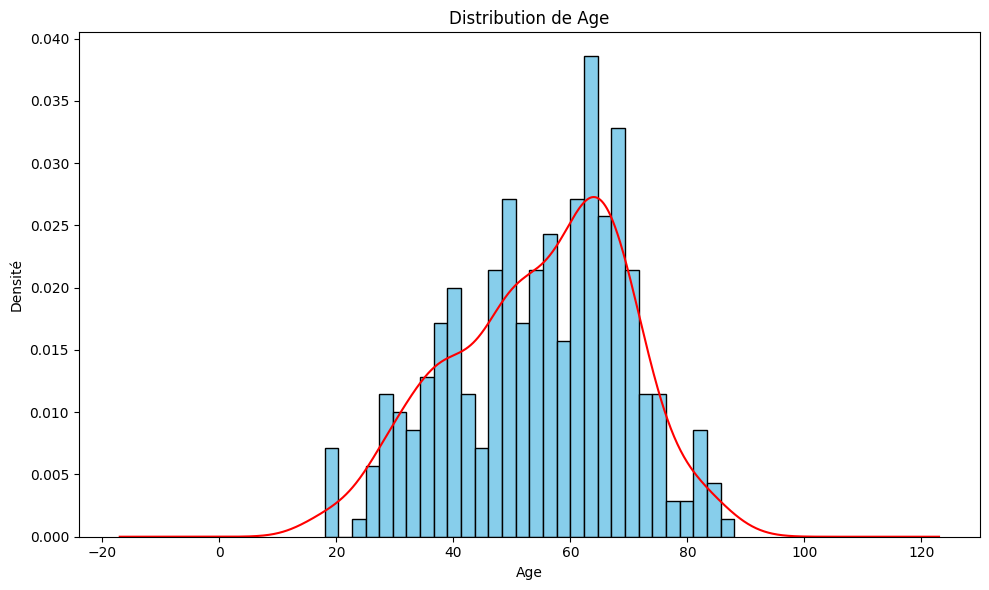

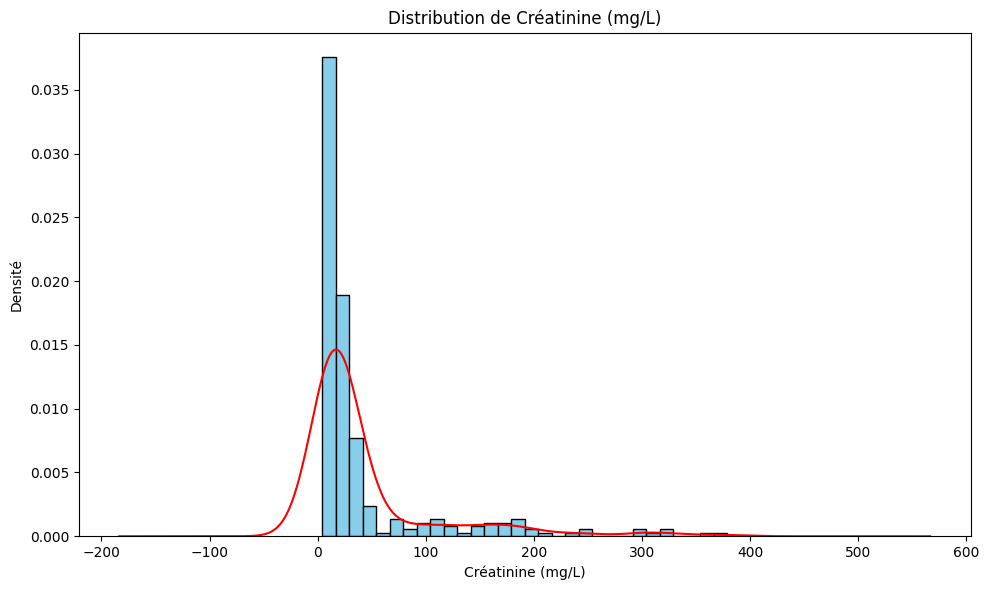

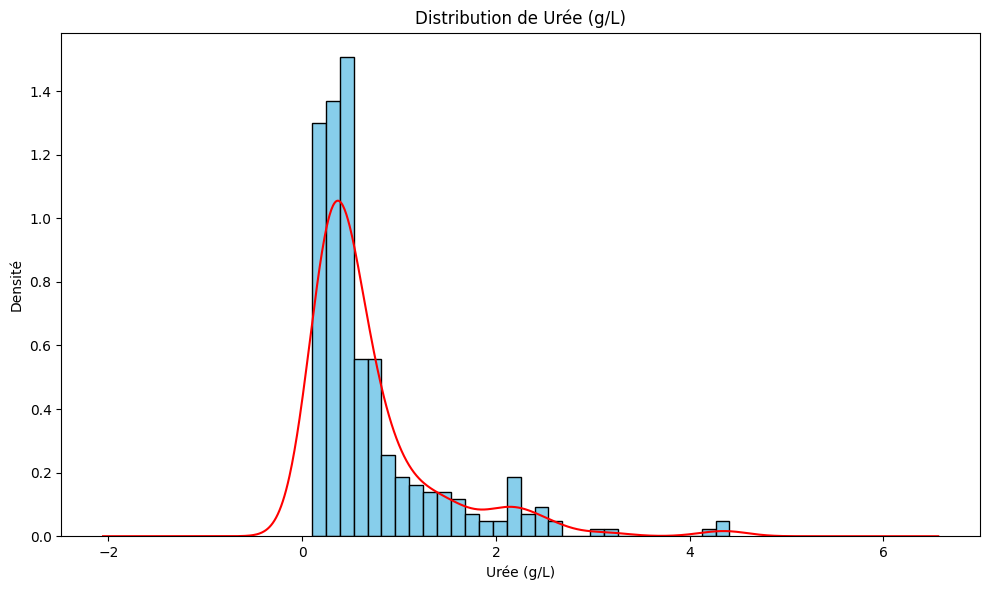

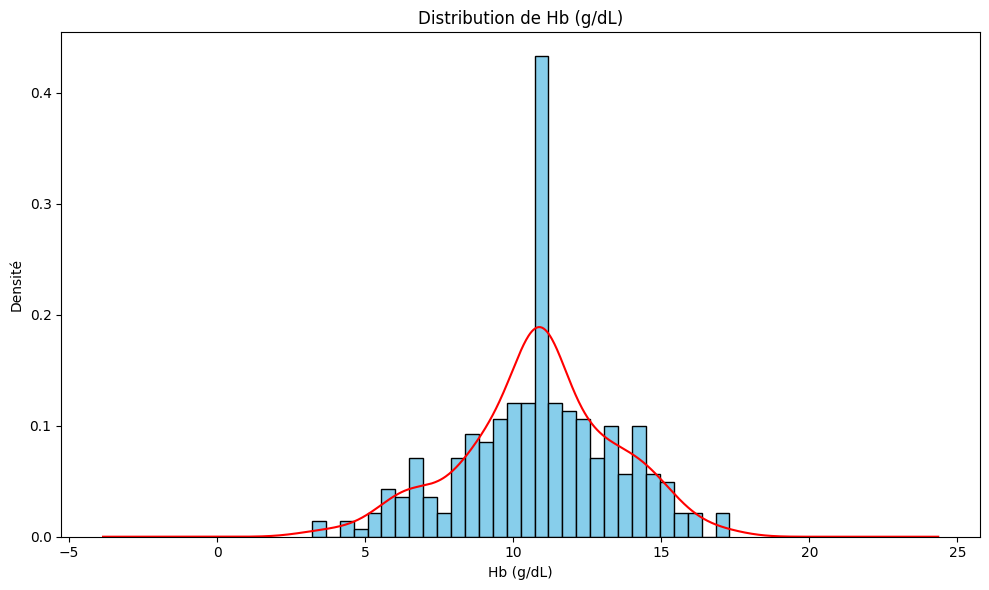

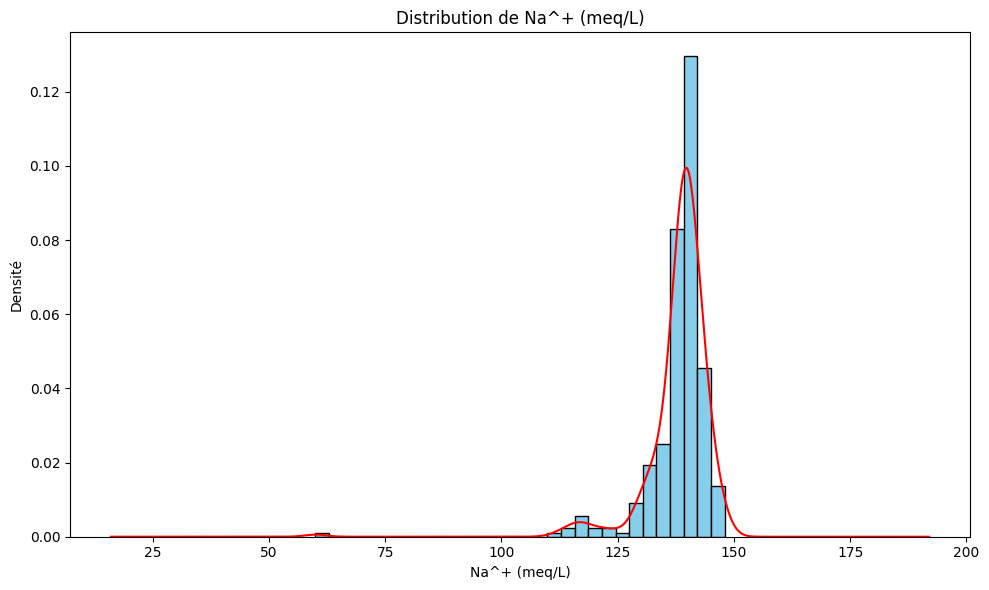

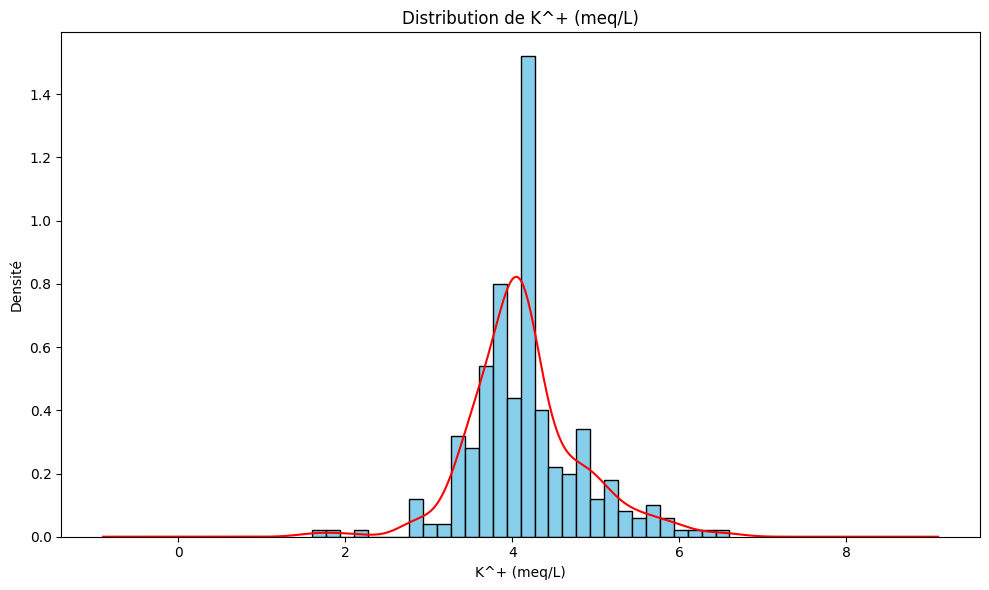

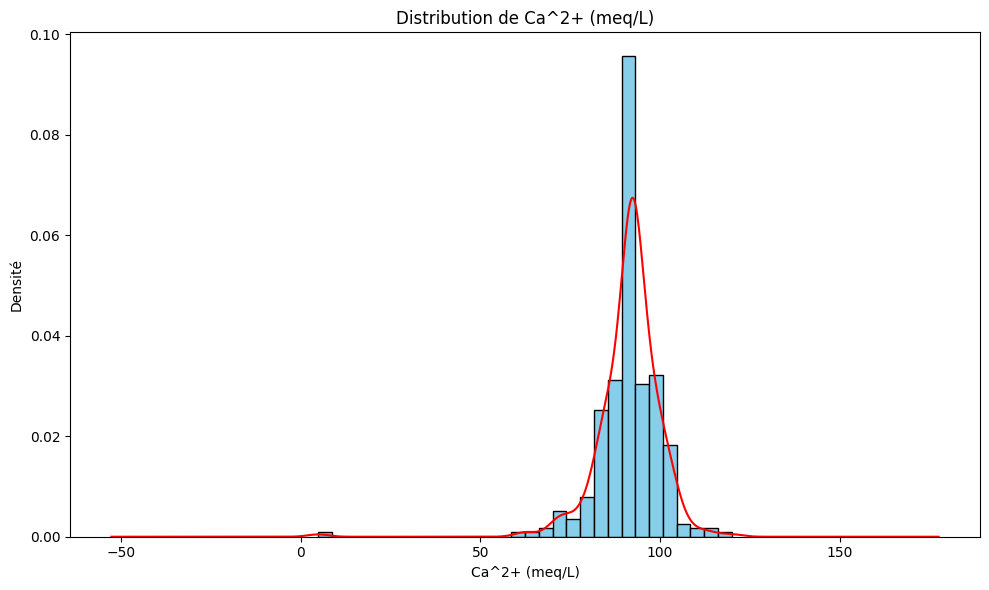

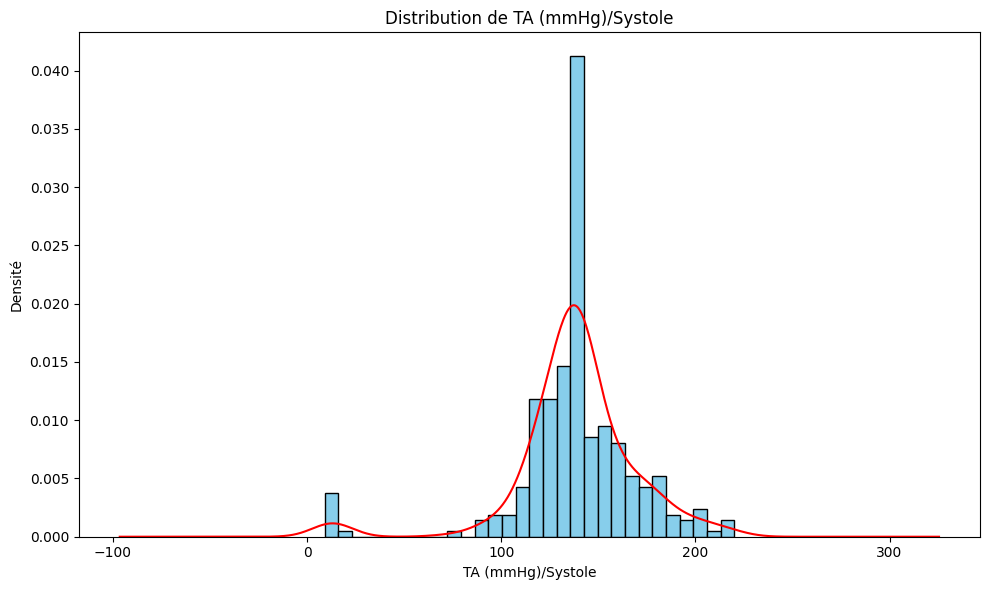

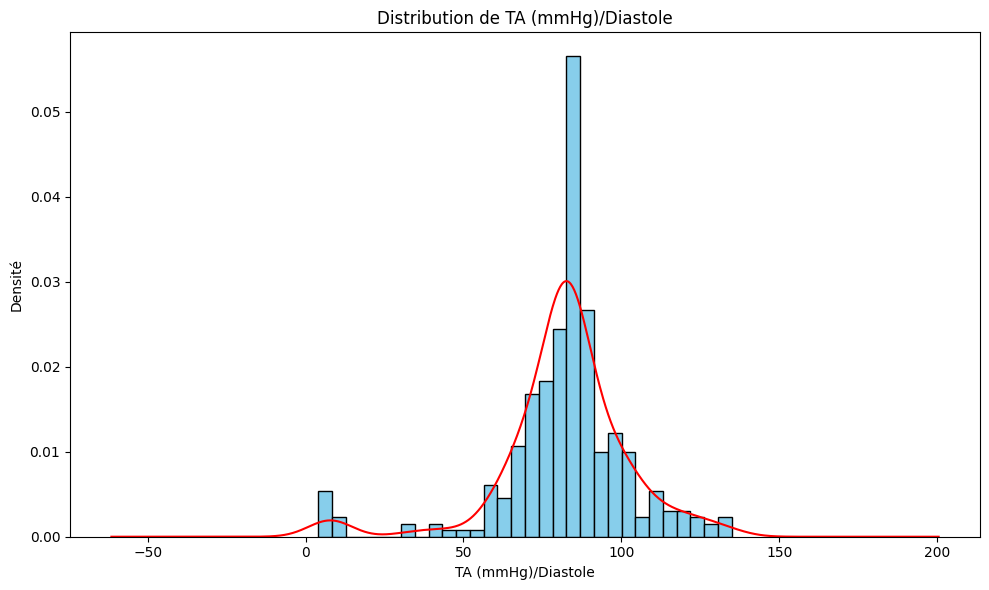

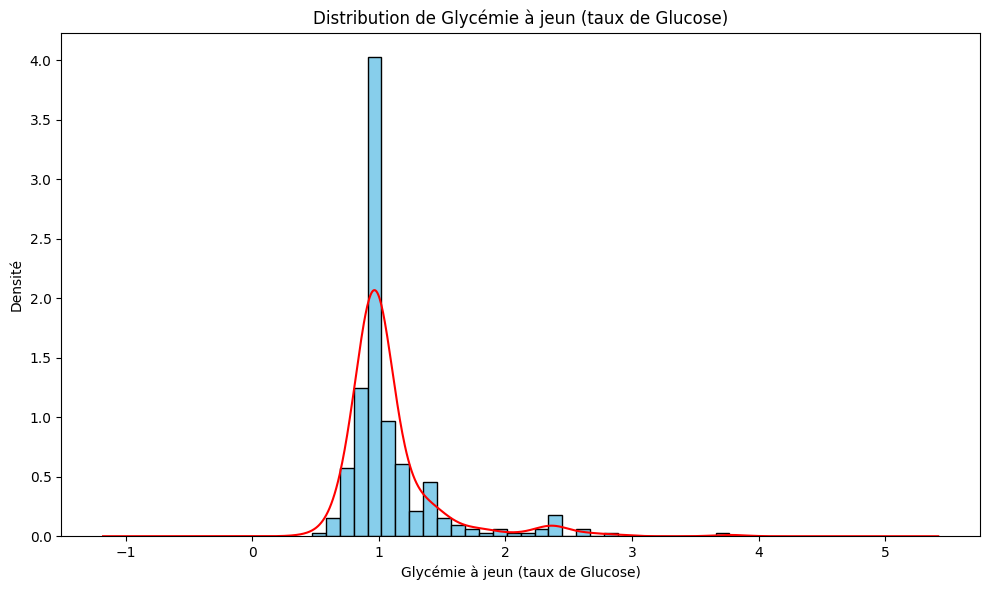

In [104]:
# Supposons que 'df' est votre DataFrame
for column in numerical_columns:
    plot_numeric_distribution(df, column, f'Distribution de {column}', column, 'Densité')

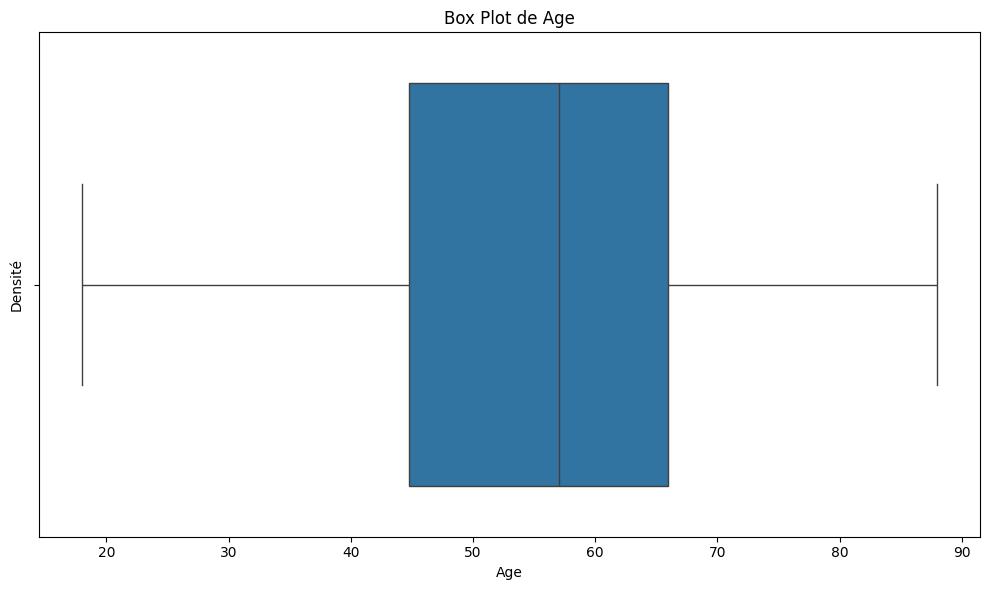

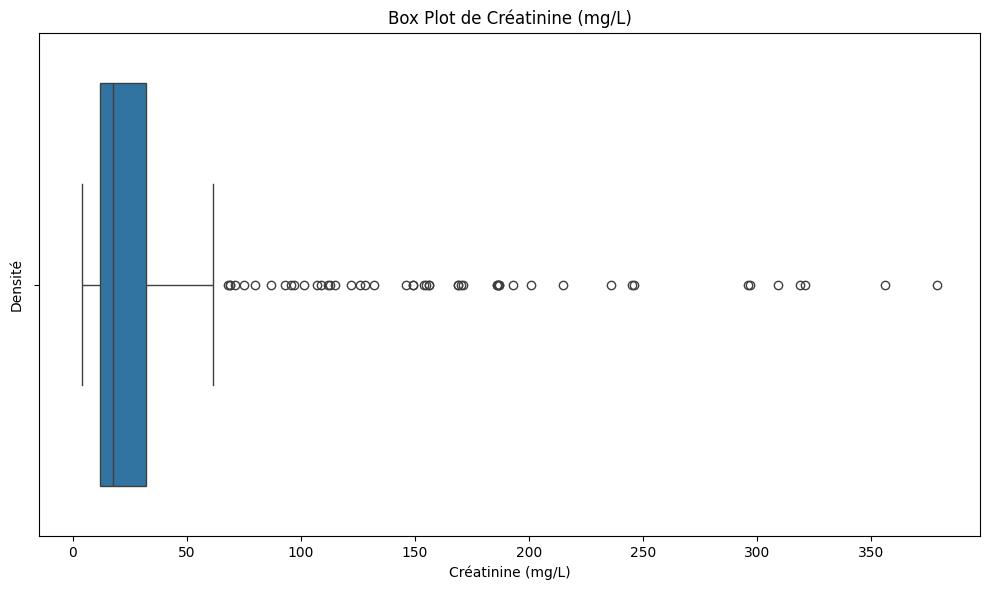

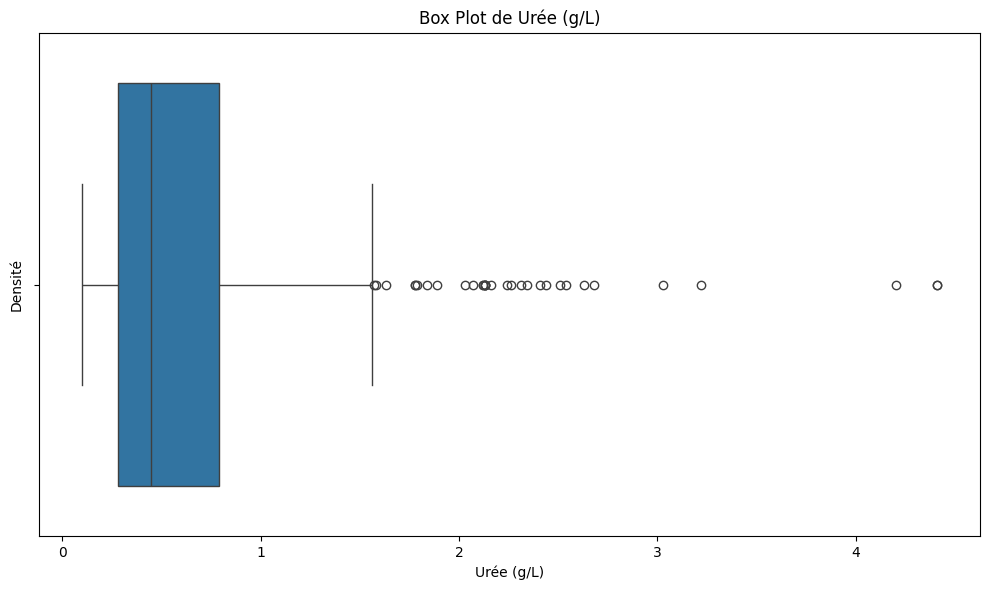

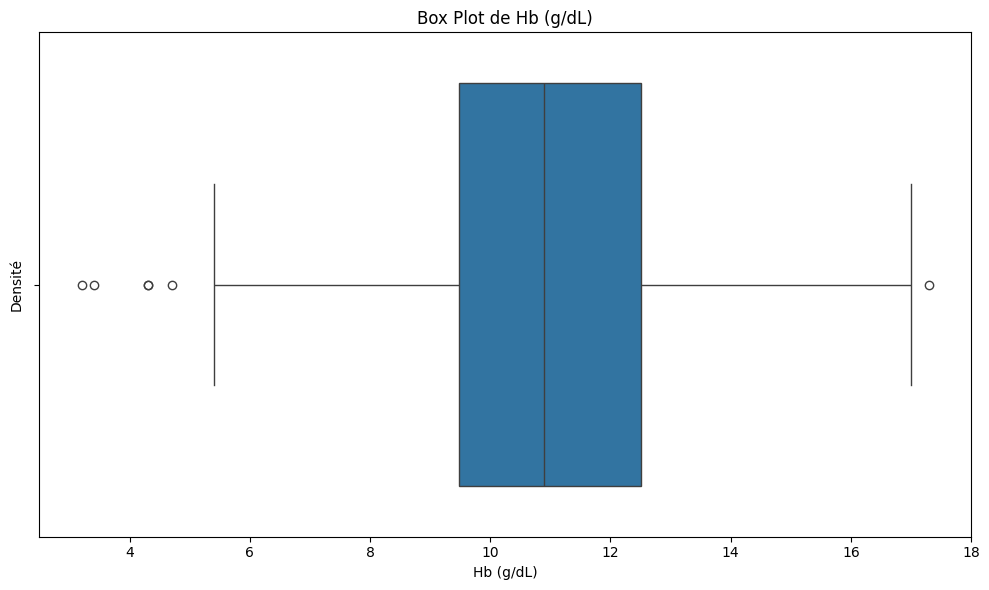

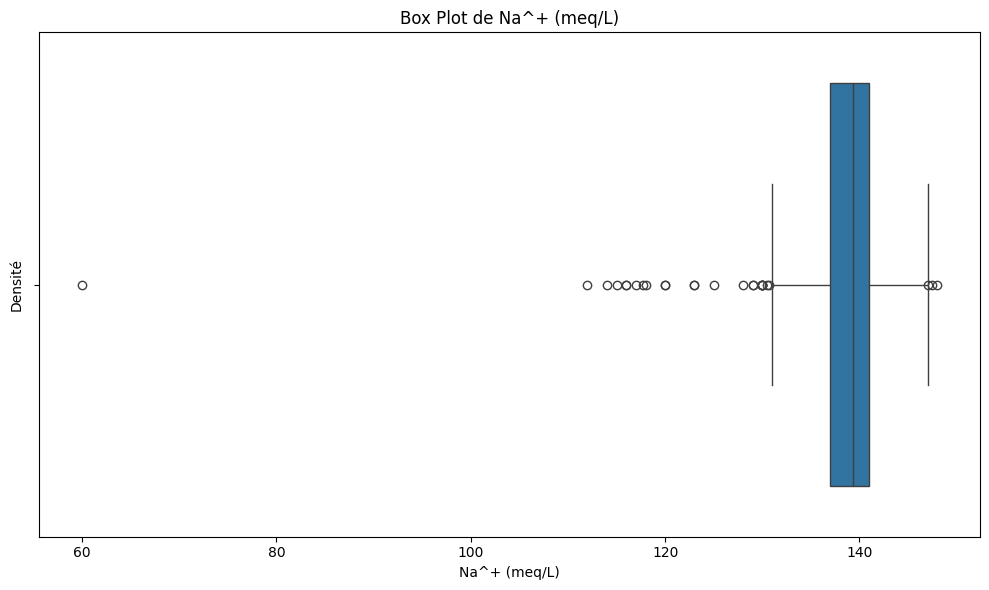

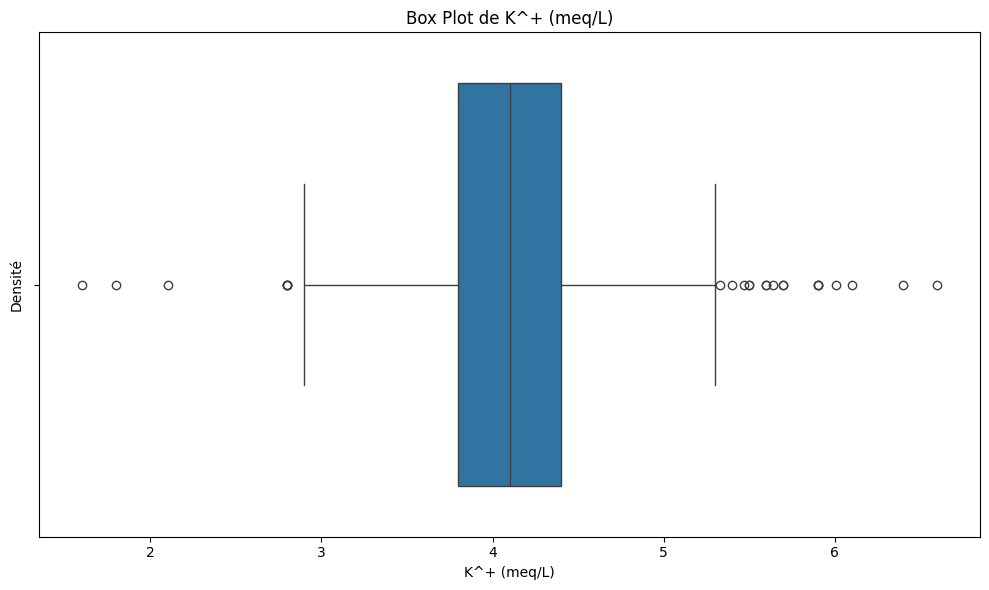

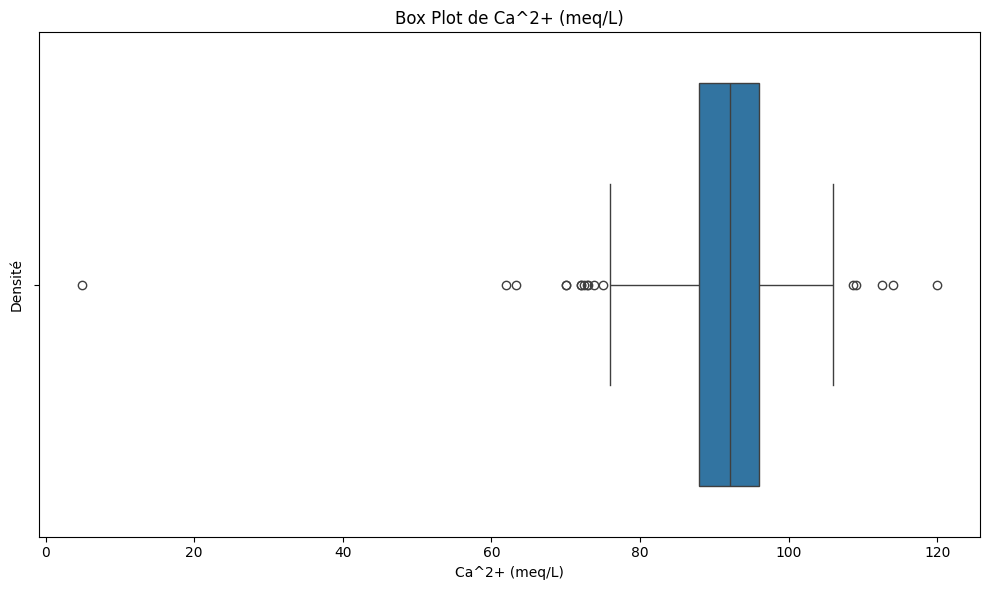

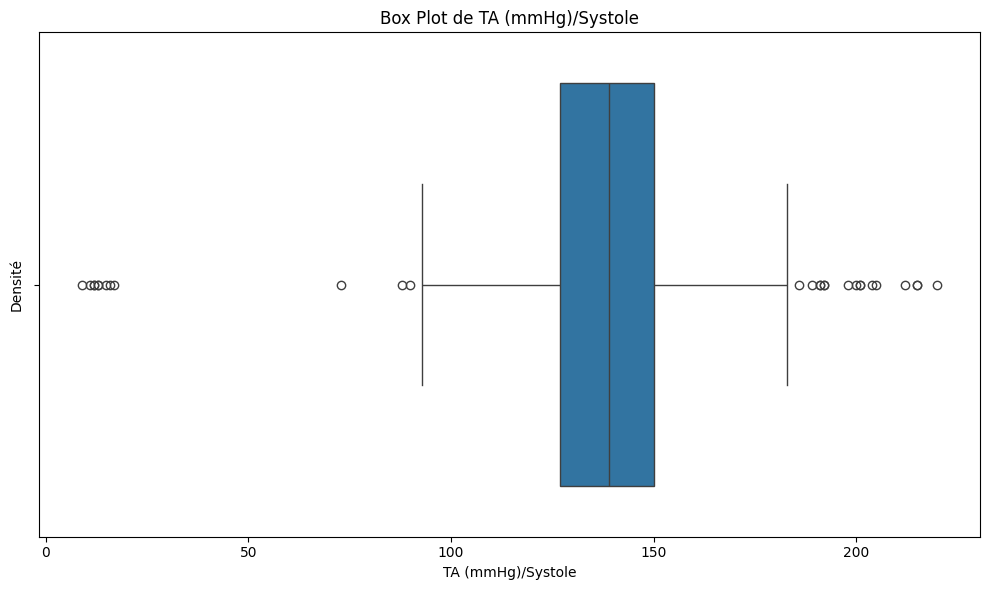

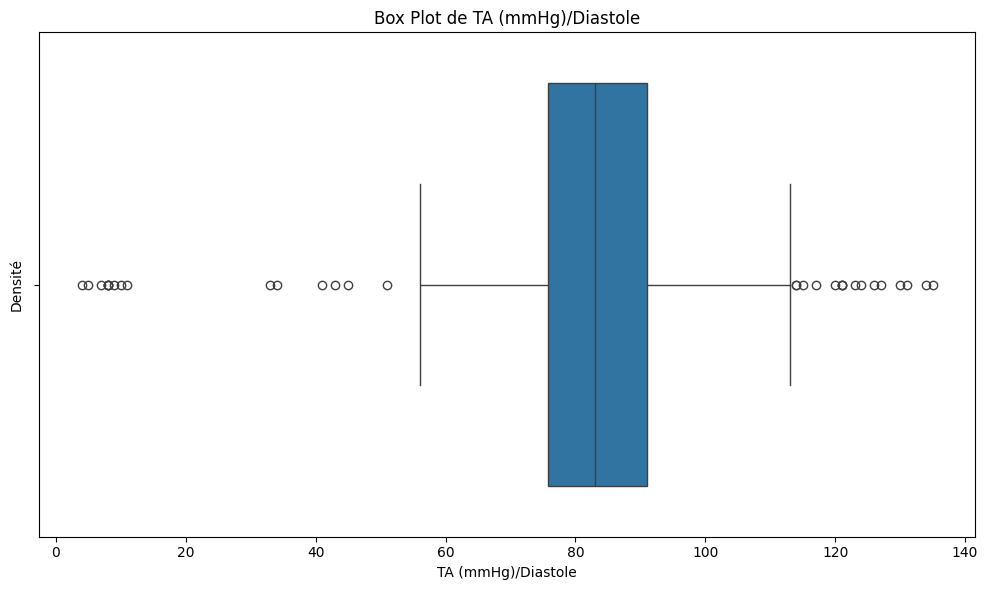

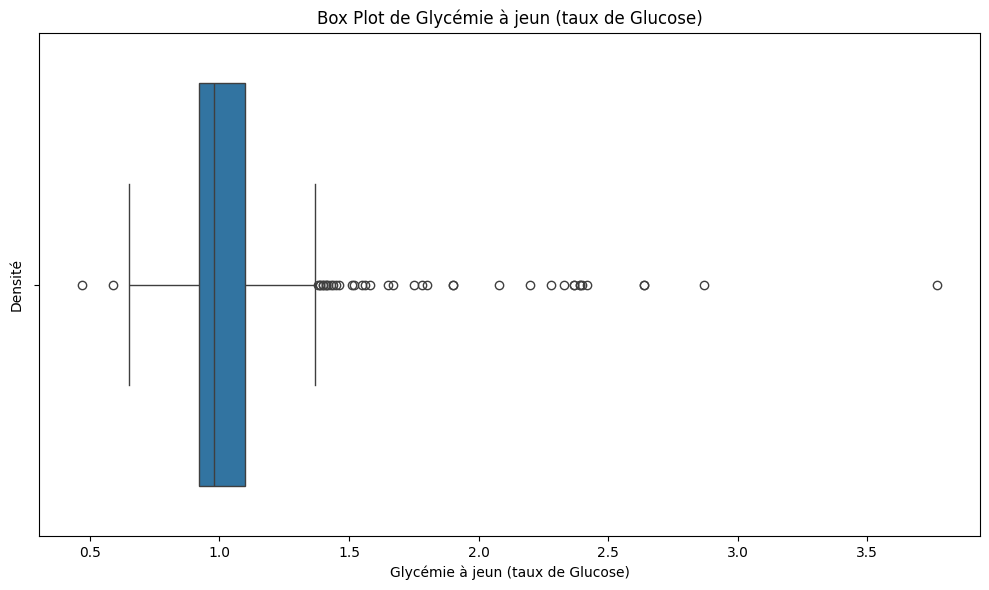

In [105]:
# Box plot
for column in numerical_columns:
    box_plot(df, column, f'Box Plot de {column}', column, 'Densité')

# 4. **Afficher Dataset**

In [106]:
df

Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  Urée (g/L)  \
0    50.0              169.0                               0.98        1.29   
1    28.0               17.0                               0.98        0.66   
2    69.0               48.0                               2.87        0.79   
3    68.0               42.0                               1.00        1.14   
5    58.0              156.0                               1.75        1.58   
..    ...                ...                                ...         ...   
301  64.0               13.0                               0.91        0.41   
302  34.0               15.0                               0.87        0.25   
303  43.0               16.0                               1.05        0.30   
304  65.0               12.0                               0.99        0.49   
305  76.0               13.0                               0.79        0.45   

     Stage de l'IRC  Etat Général (EG) à l'Admission  Hb (g/dL)  Na^+ (meq/L)  \
0                 5                              0.0       11.4         131.0   
1                 5                              0.0        9.5         134.0   
2                 5                              0.0        9.6         139.0   
3                 5                              0.0        8.2         142.0   
5                 5                              0.5        6.6         130.0   
..              ...                              ...        ...           ...   
301               3                              1.0       12.8         145.0   
302               3                              1.0       10.2         136.0   
303               3                              1.0       10.9         140.0   
304               3                              1.0       12.2         140.0   
305               3                              1.0       11.9         140.0   

     K^+ (meq/L)  Ca^2+ (meq/L)  Pathologies/Rétinopathie diabétique  Sexe  \
0            6.4          82.00                                    0   0.0   
1            5.3          92.15                                    0   1.0   
2            3.4          87.00                                    0   0.0   
3            5.7          88.00                                    0   1.0   
5            5.1          92.15                                    0   1.0   
..           ...            ...                                  ...   ...   
301          3.6          96.00                                    0   0.0   
302          4.1          92.15                                    0   0.0   
303          4.2          95.00                                    0   0.0   
304          3.7          93.00                                    0   0.0   
305          6.1         106.00                                    1   0.0   

     Symptômes/Anémie  Symptômes/Asthénie  Symptômes/HTA  Symptômes/OMI  \
0                   1                   0              0              0   
1                   1                   1              0              1   
2                   0                   1              0              1   
3                   0                   0              0              1   
5                   0                   1              0              1   
..                ...                 ...            ...            ...   
301                 0                   1              0              1   
302                 0                   0              0              0   
303                 0                   0              1              0   
304                 0                   0              0              1   
305                 0                   0              0              1   

     Symptômes/Oligurie  TA (mmHg)/Diastole  TA (mmHg)/Systole  
0                     0                80.0              140.0  
1                     0                80.0              130.0  
2                     0                34.0        

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 305
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age                                  300 non-null    float64
 1   Créatinine (mg/L)                    300 non-null    float64
 2   Glycémie à jeun (taux de Glucose)    300 non-null    float64
 3   Urée (g/L)                           300 non-null    float64
 4   Stage de l'IRC                       300 non-null    int64  
 5   Etat Général (EG) à l'Admission      300 non-null    float64
 6   Hb (g/dL)                            300 non-null    float64
 7   Na^+ (meq/L)                         300 non-null    float64
 8   K^+ (meq/L)                          300 non-null    float64
 9   Ca^2+ (meq/L)                        300 non-null    float64
 10  Pathologies/Rétinopathie diabétique  300 non-null    int64  
 11  Sexe                                 

In [108]:
df.describe()

Age  Créatinine (mg/L)  Glycémie à jeun (taux de Glucose)  \
count  300.000000         300.000000                         300.000000   
mean    54.773333          42.654967                           1.089000   
std     14.799054          64.953227                           0.385796   
min     18.000000           4.000000                           0.470000   
25%     44.750000          12.000000                           0.920000   
50%     57.000000          17.400000                           0.980000   
75%     66.000000          32.000000                           1.100000   
max     88.000000         379.000000                           3.770000   

       Urée (g/L)  Stage de l'IRC  Etat Général (EG) à l'Admission  \
count  300.000000      300.000000                       300.000000   
mean     0.708663        3.086667                         0.651667   
std      0.700303        1.303131                         0.360458   
min      0.100000        1.000000                         0.000000   
25%      0.280000        2.000000                         0.500000   
50%      0.450000        3.000000                         0.500000   
75%      0.792500        4.000000                         1.000000   
max      4.410000        5.000000                         1.000000   

        Hb (g/dL)  Na^+ (meq/L)  K^+ (meq/L)  Ca^2+ (meq/L)  \
count  300.000000    300.000000   300.000000     300.000000   
mean    10.838500    138.151333     4.144033      91.470133   
std      2.573022      7.253533     0.668346       9.032134   
min      3.200000     60.000000     1.600000       4.910000   
25%      9.475000    137.000000     3.800000      88.000000   
50%     10.900000    139.350000     4.100000      92.150000   
75%     12.500000    141.000000     4.400000      96.000000   
max     17.300000    148.000000     6.600000     120.000000   

       Pathologies/Rétinopathie diabétique        Sexe  Symptômes/Anémie  \
count                           300.000000  300.000000        300.000000   
mean                              0.033333    0.523333          0.083333   
std                               0.179805    0.500290          0.276847   
min                               0.000000    0.000000          0.000000   
25%                               0.000000    0.000000          0.000000   
50%                               0.000000    1.000000          0.000000   
75%                               0.000000    1.000000          0.000000   
max                               1.000000    1.000000          1.000000   

       Symptômes/Asthénie  Symptômes/HTA  Symptômes/OMI  Symptômes/Oligurie  \
count           300.00000     300.000000     300.000000          300.000000   
mean              0.29000       0.043333       0.363333            0.050000   
std               0.45452       0.203947       0.481763            0.218309   
min               0.00000       0.000000       0.000000            0.000000   
25%               0.00000       0.000000       0.000000            0.000000   
50%               0.00000       0.000000       0.000000            0.000000   
75%               1.00000       0.000000       1.000000            0.000000   
max               1.00000       1.000000       1.000000            1.000000   

       TA (mmHg)/Diastole  TA (mmHg)/Systole  
count          300.000000         300.000000  
mean            82.060000         138.363333  
std             20.748447          31.752565  
min              4.000000           9.000000  
25%             75.750000         127.000000  
50%             83.000000         139.000000  
75%             91.000000         150.000000  
max            135.000000         220.000000

In [109]:
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

|                                     | 0   |
|:------------------------------------|:----|
| Age                                 | 0   |
| Créatinine (mg/L)                   | 0   |
| Glycémie à jeun (taux de Glucose)   | 0   |
| Urée (g/L)                          | 0   |
| Stage de l'IRC                      | 0   |
| Etat Général (EG) à l'Admission     | 0   |
| Hb (g/dL)                           | 0   |
| Na^+ (meq/L)                        | 0   |
| K^+ (meq/L)                         | 0   |
| Ca^2+ (meq/L)                       | 0   |
| Pathologies/Rétinopathie diabétique | 0   |
| Sexe                                | 0   |
| Symptômes/Anémie                    | 0   |
| Symptômes/Asthénie                  | 0   |
| Symptômes/HTA                       | 0   |
| Symptômes/OMI                       | 0   |
| Symptômes/Oligurie                  | 0   |
| TA (mmHg)/Diastole                  | 0   |
| TA (mmHg)/Systole                   | 0   |


# **Enregistrer le dataset**

In [110]:
df.to_csv("Data_AI4CKD_cleaned.csv", index=False)

# **5. Analyse bivariée des données**

## **Relation entre les variable et la variable cibre (test statistique)**

In [111]:
import scipy.stats as stats

# 🔹 Détection des types de variables
variables_binaires = [col for col in df.columns if df[col].nunique() == 2]  # 0/1
variables_ordinales = [col for col in df.columns if df[col].nunique() > 2 and df[col].nunique() <= 5]  # Échelle 1-5
variables_numeriques = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_numeriques = [col for col in variables_numeriques if col not in variables_binaires and col not in variables_ordinales + ["Stage de l'IRC"]]

# 🔹 Test Khi² pour les variables binaires
print("\n🔹 Test Khi² pour les variables binaires et Stade de l'IRC :")
for var in variables_binaires:
    tableau_contingence = pd.crosstab(df["Stage de l'IRC"], df[var])
    chi2, p, _, _ = stats.chi2_contingency(tableau_contingence)
    print(f"   - {var}: p-valeur = {p}")
    print("       ✅ Association significative" if p < 0.05 else "    ❌ Pas d'association")

# 🔹 Test Kruskal-Wallis pour les variables ordinales
print("\n🔹 Test de Kruskal-Wallis pour les variables ordinales et Stade de l'IRC:")
for var in variables_ordinales:
    groupes = [df[df["Stage de l'IRC"] == valeur][var] for valeur in df["Stage de l'IRC"].unique()]
    kruskal_stat, p_kruskal = stats.kruskal(*groupes)
    print(f"   - {var}: p-valeur = {p_kruskal}")
    print("       ✅ Association significative entre les groupes" if p_kruskal < 0.05 else "    ❌ Pas de Association significative")

# 🔹 Test ANOVA pour chaque variable numérique
print("\n🔹 Test ANOVA pour les variables numériques et Stade de l'IRC:")
for var in variables_numeriques:
    groupes = [df[df["Stage de l'IRC"] == valeur][var] for valeur in df["Stage de l'IRC"].unique()]  # Séparer les groupes
    anova_stat, p_anova = stats.f_oneway(*groupes)  # Test ANOVA
    print(f"   - {var}: Statistique = {anova_stat}, p-valeur = {p_anova}")
    print("       ✅ Association significative entre les groupes" if p_anova < 0.05 else "    ❌ Pas de Association significative")



🔹 Test Khi² pour les variables binaires et Stade de l'IRC :
   - Pathologies/Rétinopathie diabétique: p-valeur = 0.2634702383172531
    ❌ Pas d'association
   - Sexe: p-valeur = 0.9963363757765018
    ❌ Pas d'association
   - Symptômes/Anémie: p-valeur = 6.229329954275932e-08
       ✅ Association significative
   - Symptômes/Asthénie: p-valeur = 3.571004164787383e-18
       ✅ Association significative
   - Symptômes/HTA: p-valeur = 0.20413292984595807
    ❌ Pas d'association
   - Symptômes/OMI: p-valeur = 0.00021784292131217932
       ✅ Association significative
   - Symptômes/Oligurie: p-valeur = 5.1115765907767134e-06
       ✅ Association significative

🔹 Test de Kruskal-Wallis pour les variables ordinales et Stade de l'IRC:
   - Stage de l'IRC: p-valeur = 1.780374869215726e-63
       ✅ Association significative entre les groupes
   - Etat Général (EG) à l'Admission: p-valeur = 1.328344148182615e-09
       ✅ Association significative entre les groupes

🔹 Test ANOVA pour les variable

## **Correlation entre les variable numériques**

In [112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['Créatinine (mg/L)', 'Urée (g/L)']])

import pandas as pd
df_scaled = pd.DataFrame(data_scaled, columns=['Créatinine', 'Urée'])

# Corrélation après standardisation
correlation = df_scaled.corr()
print(correlation)


            Créatinine     Urée
Créatinine     1.00000  0.86489
Urée           0.86489  1.00000


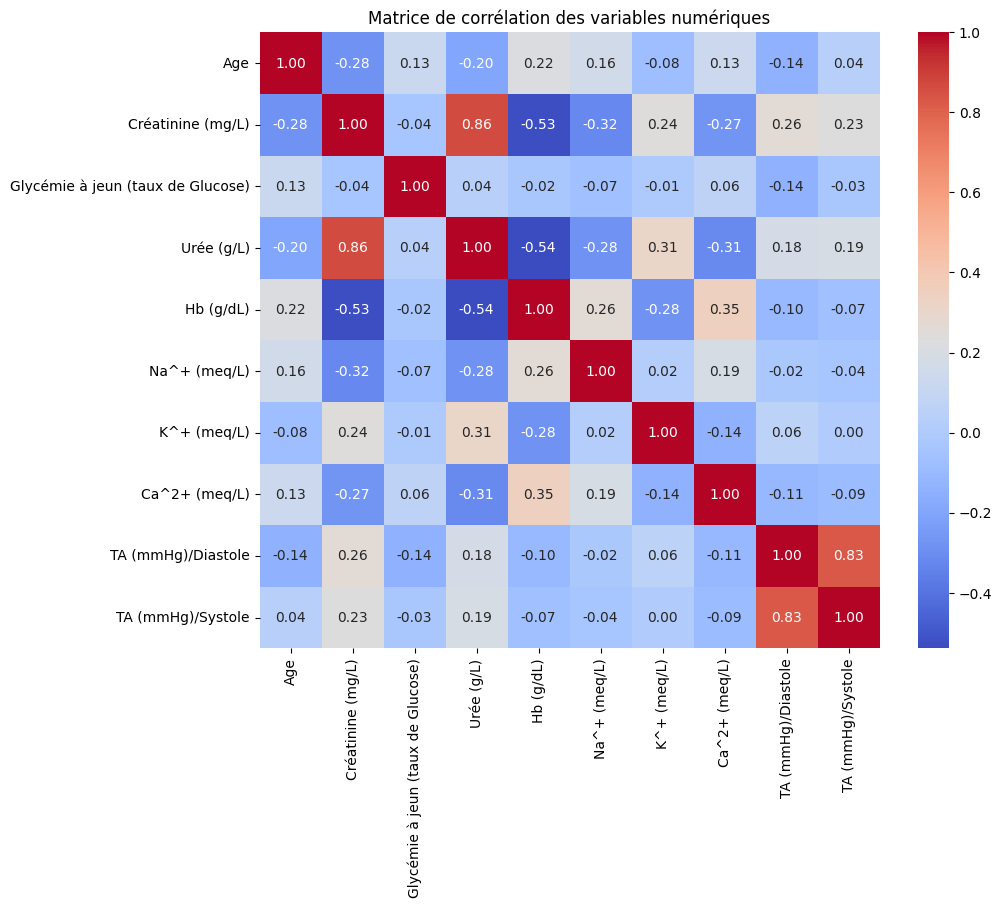

In [113]:
# correlation entre les variable numérique
correlation_matrix = df[variables_numeriques].corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des variables numériques')
plt.show()

In [114]:
# Affichage de la matrice de corrélation
df.corr()


Age  Créatinine (mg/L)  \
Age                                  1.000000          -0.277968   
Créatinine (mg/L)                   -0.277968           1.000000   
Glycémie à jeun (taux de Glucose)    0.127192          -0.038353   
Urée (g/L)                          -0.201458           0.864890   
Stage de l'IRC                      -0.065919           0.643425   
Etat Général (EG) à l'Admission      0.117124          -0.345519   
Hb (g/dL)                            0.215052          -0.528068   
Na^+ (meq/L)                         0.163818          -0.320268   
K^+ (meq/L)                         -0.080661           0.241135   
Ca^2+ (meq/L)                        0.132301          -0.269881   
Pathologies/Rétinopathie diabétique -0.041142          -0.080742   
Sexe                                 0.122682           0.043358   
Symptômes/Anémie                    -0.045985           0.322008   
Symptômes/Asthénie                  -0.183610           0.455221   
Symptômes/HTA                       -0.076518           0.108814   
Symptômes/OMI                       -0.058305           0.165842   
Symptômes/Oligurie                  -0.202485           0.306993   
TA (mmHg)/Diastole                  -0.140016           0.263463   
TA (mmHg)/Systole                    0.035456           0.232398   

                                     Glycémie à jeun (taux de Glucose)  \
Age                                                           0.127192   
Créatinine (mg/L)                                            -0.038353   
Glycémie à jeun (taux de Glucose)                             1.000000   
Urée (g/L)                                                    0.037798   
Stage de l'IRC                                                0.048071   
Etat Général (EG) à l'Admission                              -0.062999   
Hb (g/dL)                                                    -0.024373   
Na^+ (meq/L)                                                 -0.067760   
K^+ (meq/L)                                                  -0.010159   
Ca^2+ (meq/L)                                                 0.064615   
Pathologies/Rétinopathie diabétique                           0.034714   
Sexe                                                         -0.011488   
Symptômes/Anémie                                             -0.045248   
Symptômes/Asthénie                                            0.012912   
Symptômes/HTA                                                 0.060912   
Symptômes/OMI                                                 0.017617   
Symptômes/Oligurie                                           -0.002184   
TA (mmHg)/Diastole                                           -0.143859   
TA (mmHg)/Systole                                            -0.033743   

                                     Urée (g/L)  Stage de l'IRC  \
Age                                   -0.201458       -0.065919   
Créatinine (mg/L)                      0.864890        0.643425   
Glycémie à jeun (taux de Glucose)      0.037798        0.048071   
Urée (g/L)                             1.000000        0.687801   
Stage de l'IRC                         0.687801        1.000000   
Etat Général (EG) à l'Admission       -0.384346       -0.348481   
Hb (g/dL)                             -0.539467       -0.594789   
Na^+ (meq/L)                          -0.275084       -0.303242   
K^+ (meq/L)                            0.310401        0.247167   
Ca^2+ (meq/L)                         -0.312576       -0.342617   
Pathologies/Rétinopathie diabétique   -0.061266       -0.055192   
Sexe                                   0.087908       -0.003112   
Symptômes/Anémie                       0.317641        0.322921   
Symptômes/Asthénie                     0.488864        0.443033   
Symptômes/HTA                          0.087985        0.061327   
Symptômes/OMI                          0.226263        0.248004   
Symptômes/Oligurie                     0.306048        0.2315

## **Correlation entre les variables catégoriels**


🔍 Variables catégorielles détectées :
["Etat Général (EG) à l'Admission", 'Pathologies/Rétinopathie diabétique', 'Sexe', 'Symptômes/Anémie', 'Symptômes/Asthénie', 'Symptômes/HTA', 'Symptômes/OMI', 'Symptômes/Oligurie']

--- Etat Général (EG) à l'Admission vs Pathologies/Rétinopathie diabétique ---
Test utilisé : Chi²
p-value = 0.6466 → ❌ Pas d'association significative (p ≥ 0.05)

--- Etat Général (EG) à l'Admission vs Sexe ---
Test utilisé : Chi²
p-value = 0.3516 → ❌ Pas d'association significative (p ≥ 0.05)

--- Etat Général (EG) à l'Admission vs Symptômes/Anémie ---
Test utilisé : Chi²
p-value = 0.0002 → ✅ Association significative (p < 0.05)


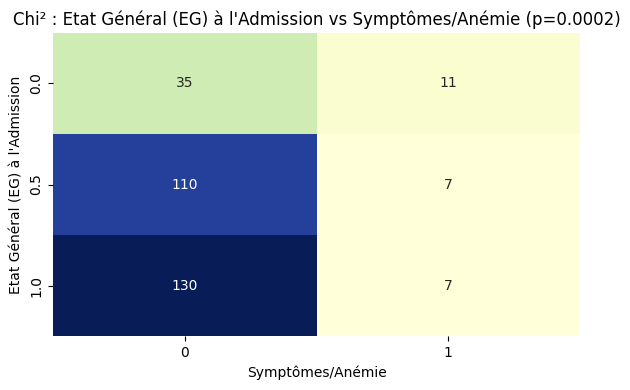


--- Etat Général (EG) à l'Admission vs Symptômes/Asthénie ---
Test utilisé : Chi²
p-value = 0.0000 → ✅ Association significative (p < 0.05)


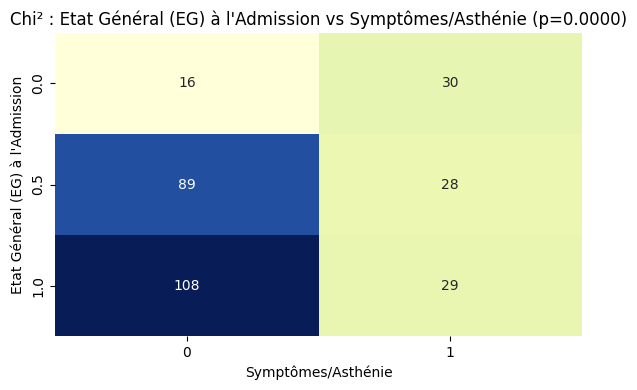


--- Etat Général (EG) à l'Admission vs Symptômes/HTA ---
Test utilisé : Chi²
p-value = 0.0597 → ❌ Pas d'association significative (p ≥ 0.05)

--- Etat Général (EG) à l'Admission vs Symptômes/OMI ---
Test utilisé : Chi²
p-value = 0.0000 → ✅ Association significative (p < 0.05)


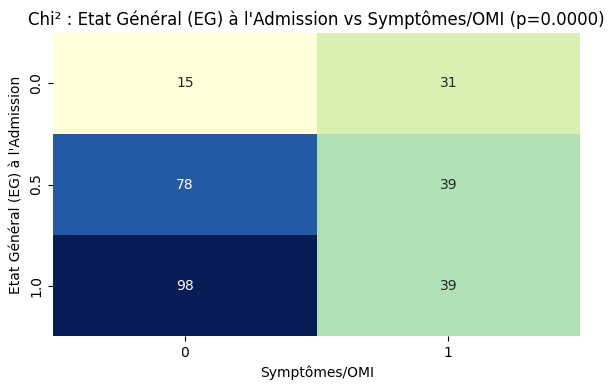


--- Etat Général (EG) à l'Admission vs Symptômes/Oligurie ---
Test utilisé : Chi²
p-value = 0.0246 → ✅ Association significative (p < 0.05)


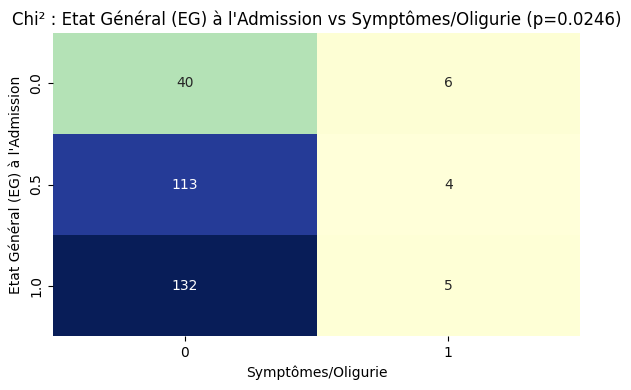


--- Pathologies/Rétinopathie diabétique vs Sexe ---
Test utilisé : Fisher (2x2)
p-value = 0.5269 → ❌ Pas d'association significative (p ≥ 0.05)

--- Pathologies/Rétinopathie diabétique vs Symptômes/Anémie ---
Test utilisé : Fisher (2x2)
p-value = 1.0000 → ❌ Pas d'association significative (p ≥ 0.05)

--- Pathologies/Rétinopathie diabétique vs Symptômes/Asthénie ---
Test utilisé : Fisher (2x2)
p-value = 0.2908 → ❌ Pas d'association significative (p ≥ 0.05)

--- Pathologies/Rétinopathie diabétique vs Symptômes/HTA ---
Test utilisé : Fisher (2x2)
p-value = 1.0000 → ❌ Pas d'association significative (p ≥ 0.05)

--- Pathologies/Rétinopathie diabétique vs Symptômes/OMI ---
Test utilisé : Fisher (2x2)
p-value = 0.5050 → ❌ Pas d'association significative (p ≥ 0.05)

--- Pathologies/Rétinopathie diabétique vs Symptômes/Oligurie ---
Test utilisé : Fisher (2x2)
p-value = 1.0000 → ❌ Pas d'association significative (p ≥ 0.05)

--- Sexe vs Symptômes/Anémie ---
Test utilisé : Fisher (2x2)
p-value = 

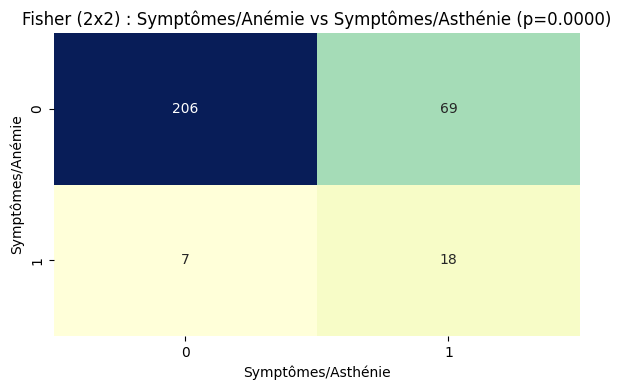


--- Symptômes/Anémie vs Symptômes/HTA ---
Test utilisé : Fisher (2x2)
p-value = 1.0000 → ❌ Pas d'association significative (p ≥ 0.05)

--- Symptômes/Anémie vs Symptômes/OMI ---
Test utilisé : Fisher (2x2)
p-value = 0.0041 → ✅ Association significative (p < 0.05)


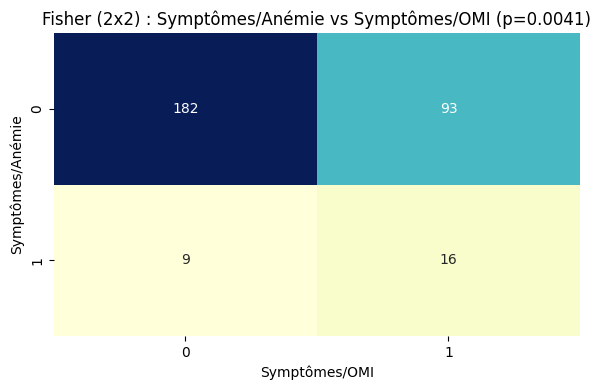


--- Symptômes/Anémie vs Symptômes/Oligurie ---
Test utilisé : Fisher (2x2)
p-value = 0.1190 → ❌ Pas d'association significative (p ≥ 0.05)

--- Symptômes/Asthénie vs Symptômes/HTA ---
Test utilisé : Fisher (2x2)
p-value = 0.7629 → ❌ Pas d'association significative (p ≥ 0.05)

--- Symptômes/Asthénie vs Symptômes/OMI ---
Test utilisé : Fisher (2x2)
p-value = 0.0002 → ✅ Association significative (p < 0.05)


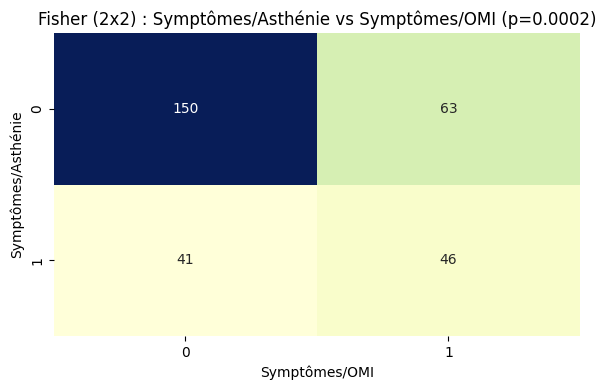


--- Symptômes/Asthénie vs Symptômes/Oligurie ---
Test utilisé : Fisher (2x2)
p-value = 0.0153 → ✅ Association significative (p < 0.05)


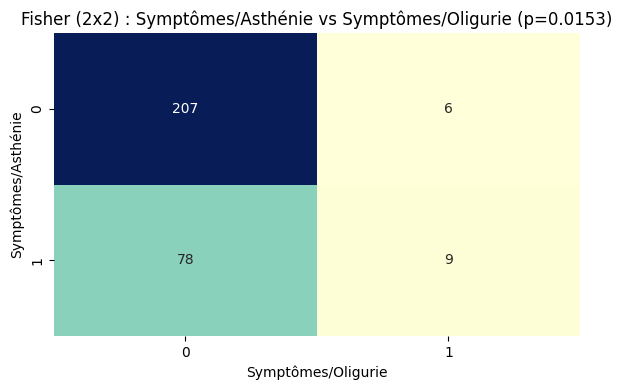


--- Symptômes/HTA vs Symptômes/OMI ---
Test utilisé : Fisher (2x2)
p-value = 1.0000 → ❌ Pas d'association significative (p ≥ 0.05)

--- Symptômes/HTA vs Symptômes/Oligurie ---
Test utilisé : Fisher (2x2)
p-value = 1.0000 → ❌ Pas d'association significative (p ≥ 0.05)

--- Symptômes/OMI vs Symptômes/Oligurie ---
Test utilisé : Fisher (2x2)
p-value = 0.0239 → ✅ Association significative (p < 0.05)


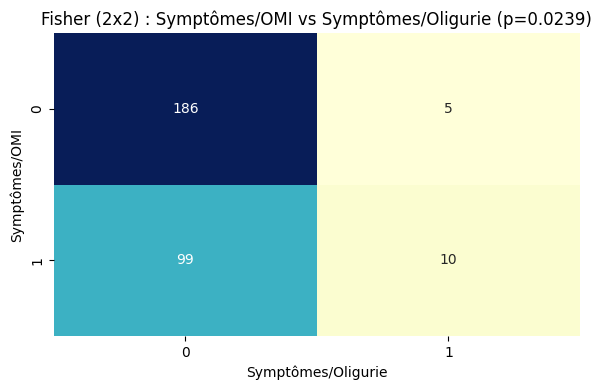


🟢 PAIRES D'ASSOCIÉES  (p < 0.05) :
                           var1               var2      p_value         test
Etat Général (EG) à l'Admission Symptômes/Asthénie 2.712203e-08         Chi²
               Symptômes/Anémie Symptômes/Asthénie 3.996591e-06 Fisher (2x2)
Etat Général (EG) à l'Admission      Symptômes/OMI 8.712402e-06         Chi²
Etat Général (EG) à l'Admission   Symptômes/Anémie 1.728025e-04         Chi²
             Symptômes/Asthénie      Symptômes/OMI 1.989295e-04 Fisher (2x2)
               Symptômes/Anémie      Symptômes/OMI 4.124870e-03 Fisher (2x2)
             Symptômes/Asthénie Symptômes/Oligurie 1.527837e-02 Fisher (2x2)
                  Symptômes/OMI Symptômes/Oligurie 2.386396e-02 Fisher (2x2)
Etat Général (EG) à l'Admission Symptômes/Oligurie 2.463453e-02         Chi²

🔴 PAIRES FAIBLEMENT ASSOCIÉES (p ≥ 0.05) :
                               var1                                var2  p_value         test
    Etat Général (EG) à l'Admission                     

In [115]:

data = df.drop(columns=['Stage de l\'IRC'])

# === 🔎 Détection des variables catégorielles encodées ===
cat_vars = [col for col in data.columns if data[col].nunique() <= 10]

print(f"\n🔍 Variables catégorielles détectées :\n{cat_vars}")

# === 📊 Comparaison 2 à 2 ===
results = []

for var1, var2 in combinations(cat_vars, 2):
    table = pd.crosstab(data[var1], data[var2])

    if table.shape == (2, 2):
        stat, p = fisher_exact(table)
        test_name = "Fisher (2x2)"
    else:
        stat, p, _, _ = chi2_contingency(table)
        test_name = "Chi²"

    # Interprétation
    if p < 0.05:
        interpretation = "✅ Association significative (p < 0.05)"
    else:
        interpretation = "❌ Pas d'association significative (p ≥ 0.05)"

    print(f"\n--- {var1} vs {var2} ---")
    print(f"Test utilisé : {test_name}")
    print(f"p-value = {p:.4f} → {interpretation}")

    results.append({
        'var1': var1,
        'var2': var2,
        'test': test_name,
        'p_value': p,
        'significatif': p < 0.05,
        'interpretation': interpretation
    })

    if p < 0.05:
        plt.figure(figsize=(6, 4))
        sns.heatmap(table, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
        plt.title(f"{test_name} : {var1} vs {var2} (p={p:.4f})")
        plt.xlabel(var2)
        plt.ylabel(var1)
        plt.tight_layout()
        plt.show()

# === 📋 Résumé structuré ===
results_data = pd.DataFrame(results)

strong_assoc = results_data[results_data['p_value'] < 0.05].sort_values("p_value")
weak_assoc = results_data[results_data['p_value'] >= 0.05].sort_values("p_value")

print("\n🟢 PAIRES D'ASSOCIÉES  (p < 0.05) :")
if strong_assoc.empty:
    print("Aucune association significative trouvée.")
else:
    print(strong_assoc[['var1', 'var2', 'p_value', 'test']].to_string(index=False))

print("\n🔴 PAIRES FAIBLEMENT ASSOCIÉES (p ≥ 0.05) :")
if weak_assoc.empty:
    print("Toutes les paires sont significativement associées.")
else:
    print(weak_assoc[['var1', 'var2', 'p_value', 'test']].to_string(index=False))



## **visualisation graphique des variables**

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


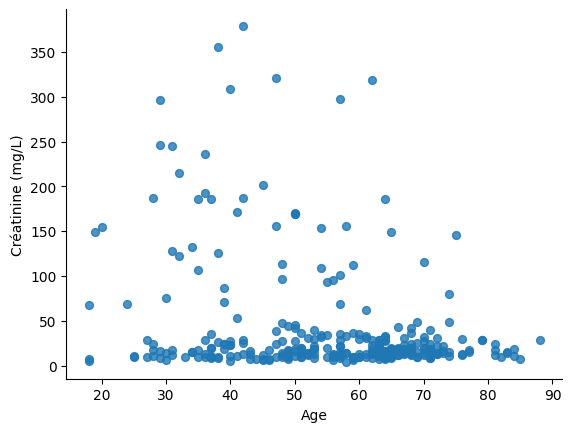

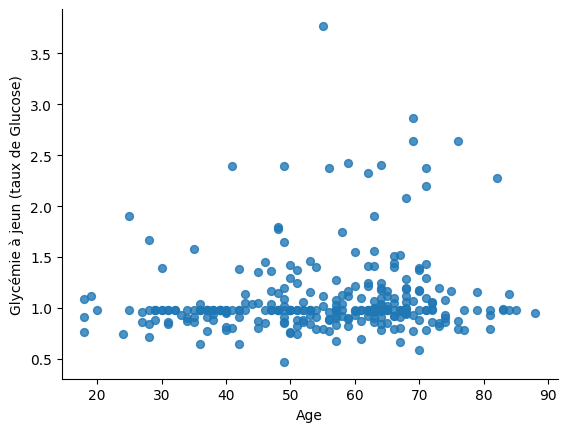

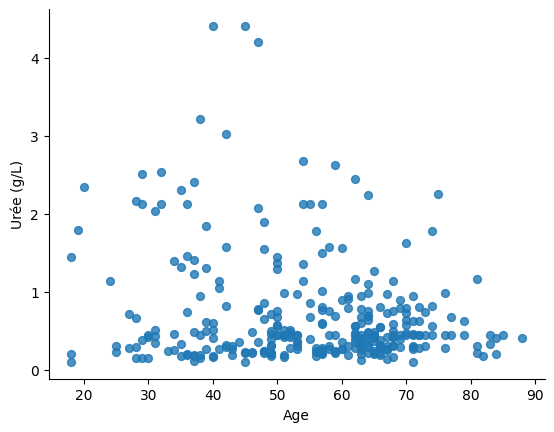

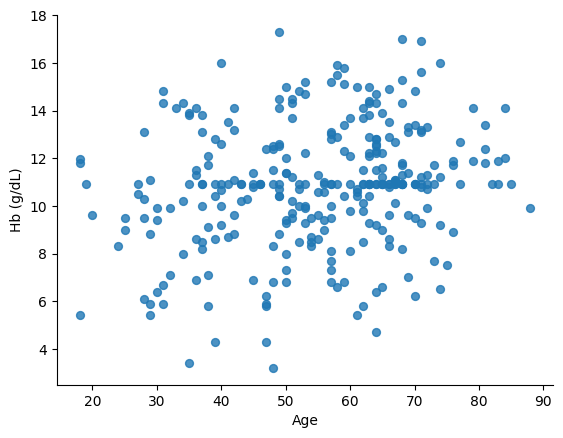

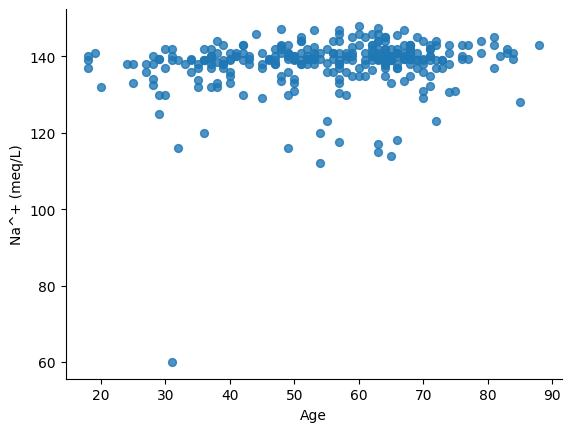

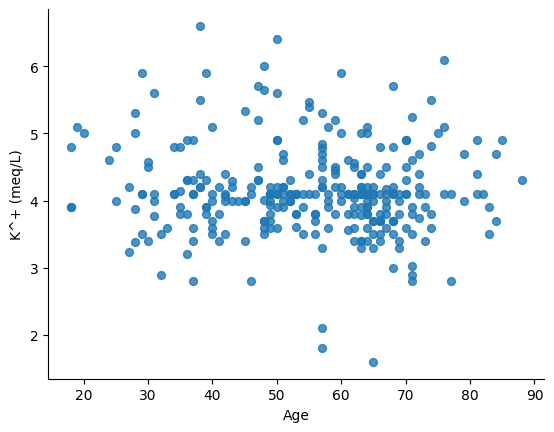

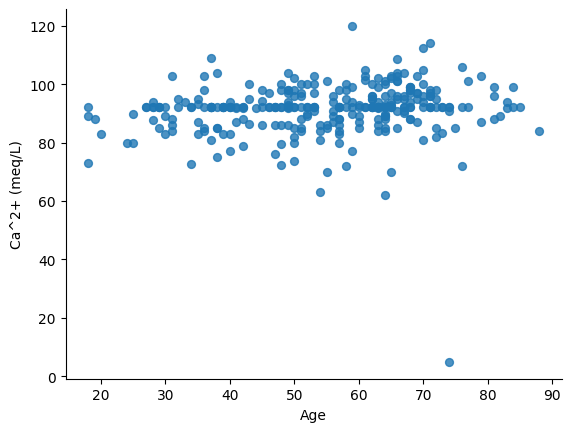

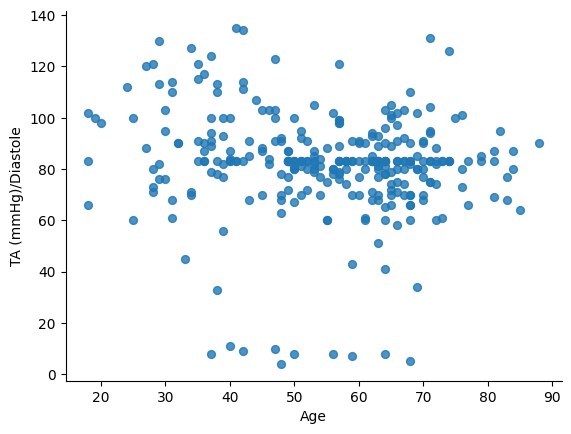

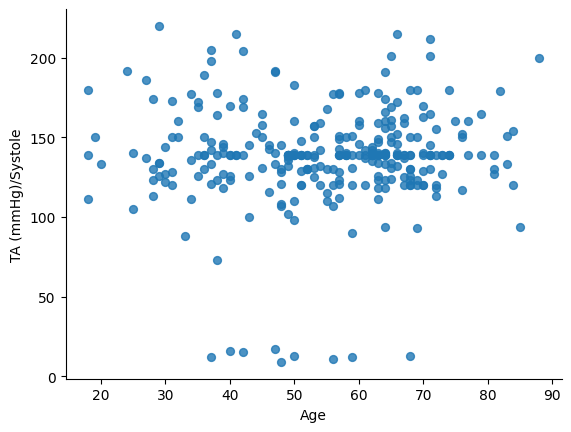

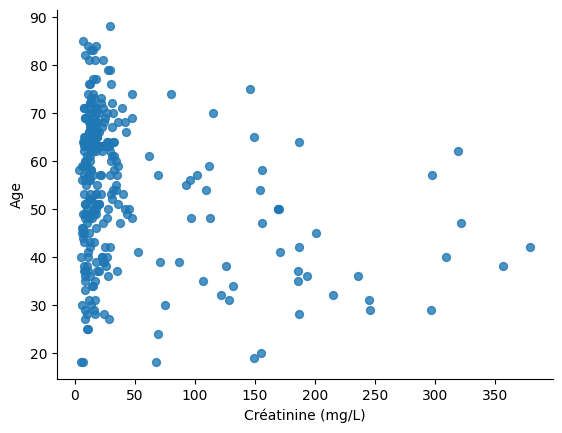

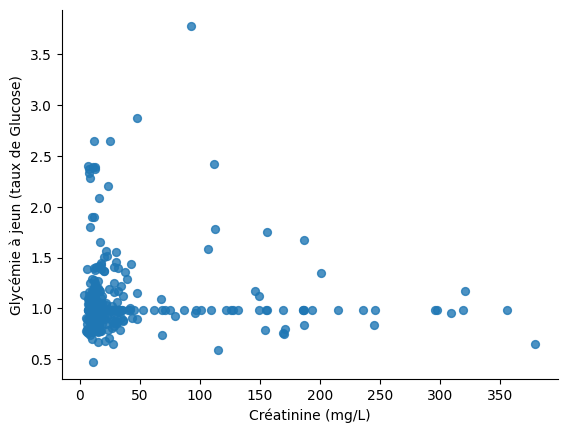

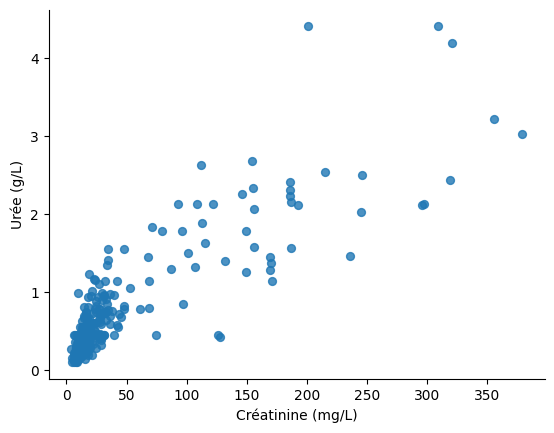

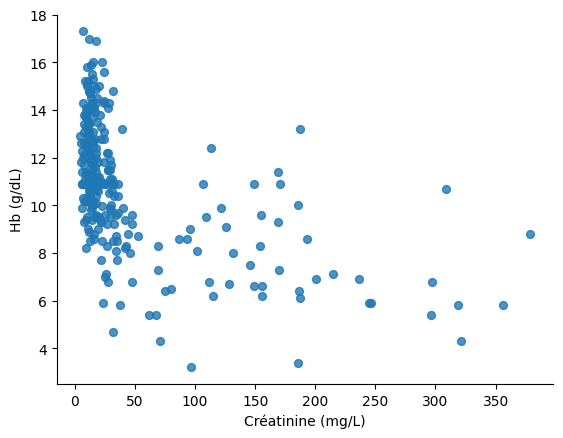

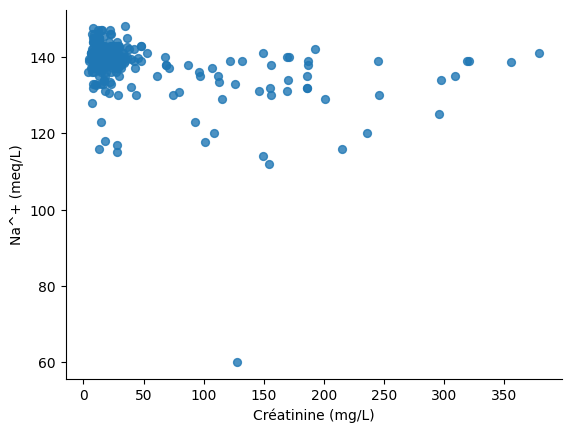

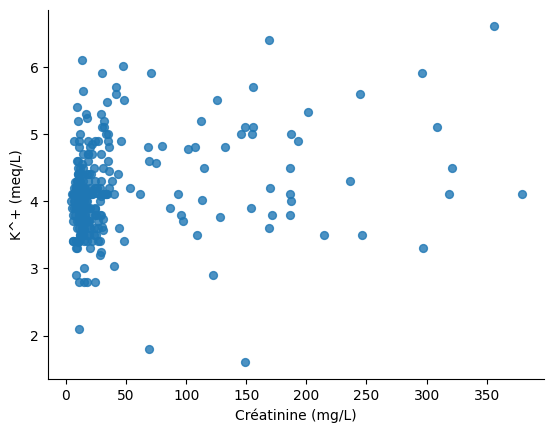

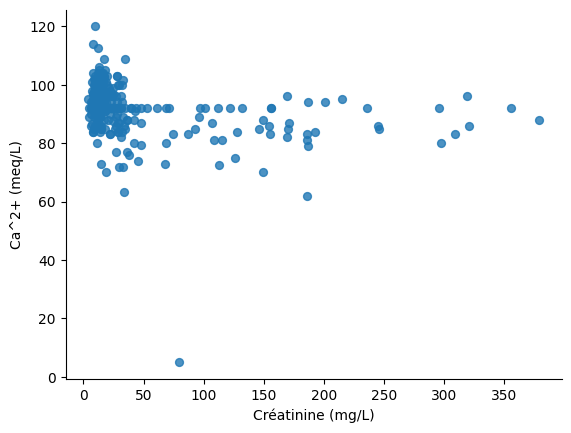

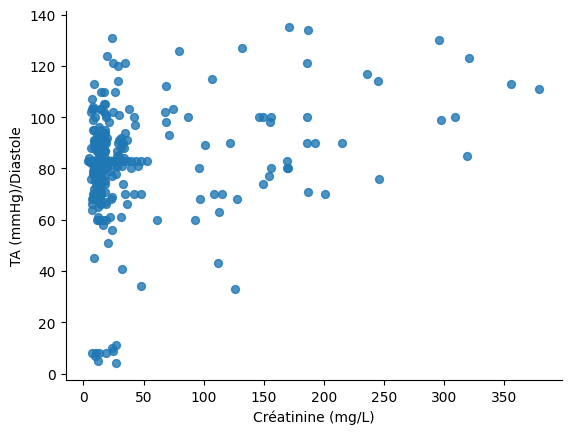

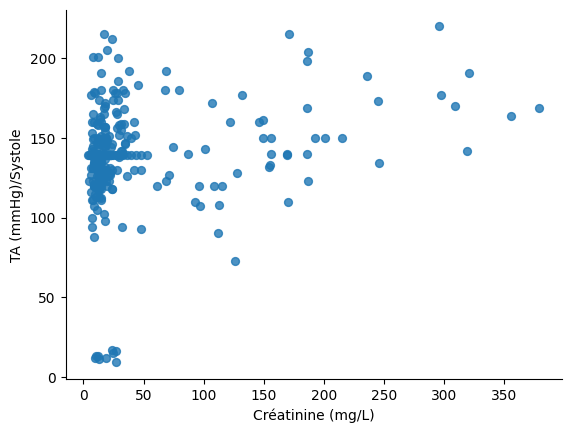

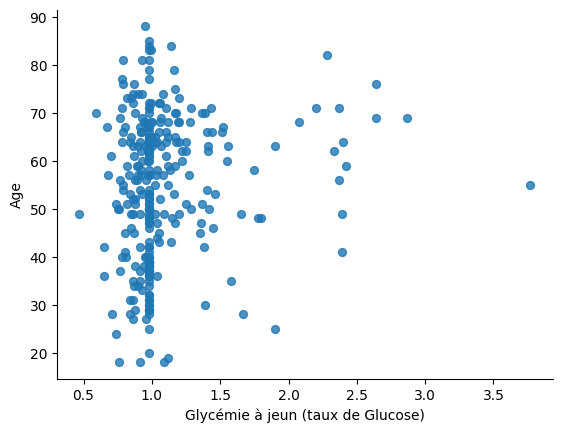

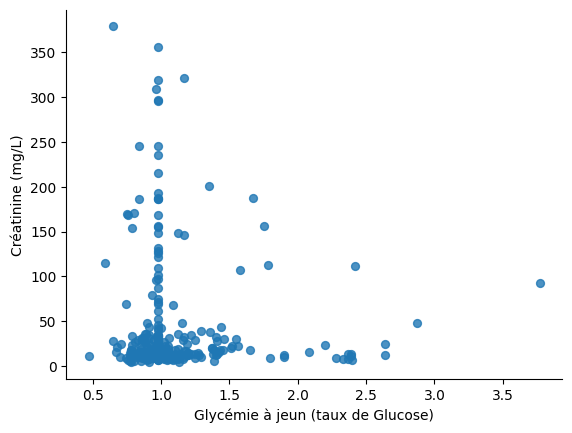

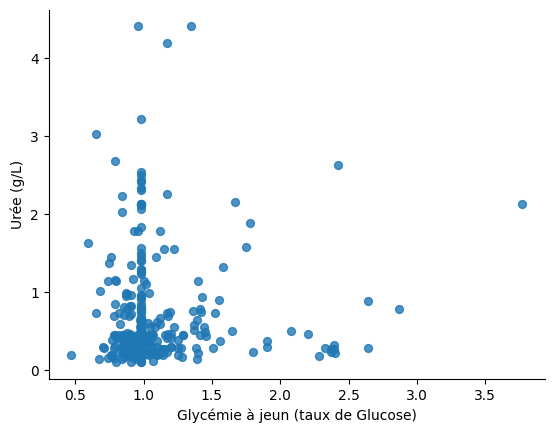

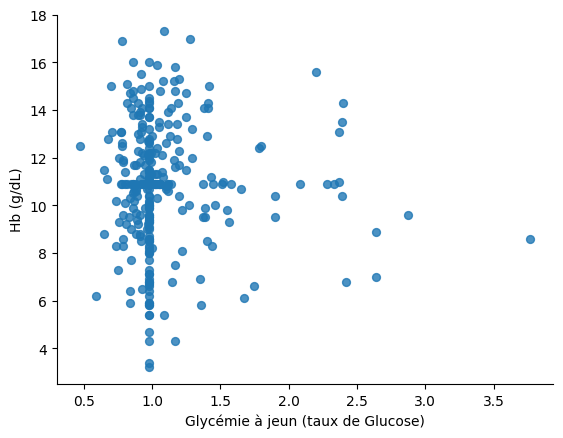

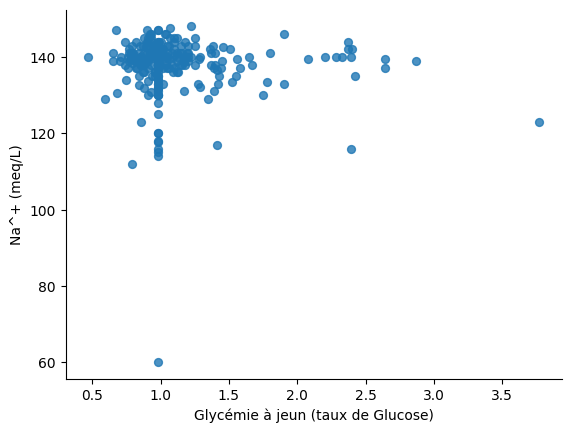

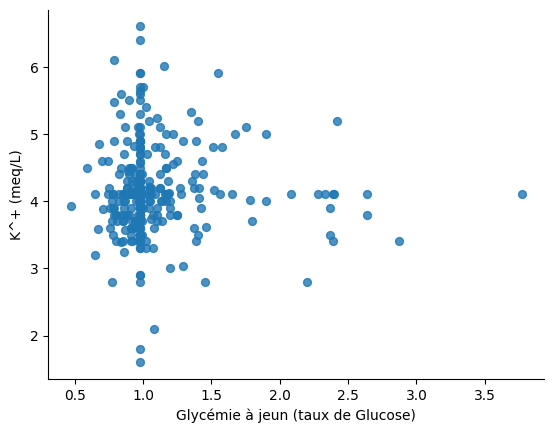

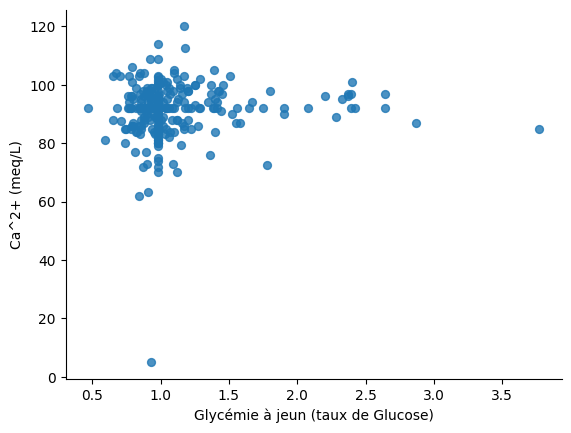

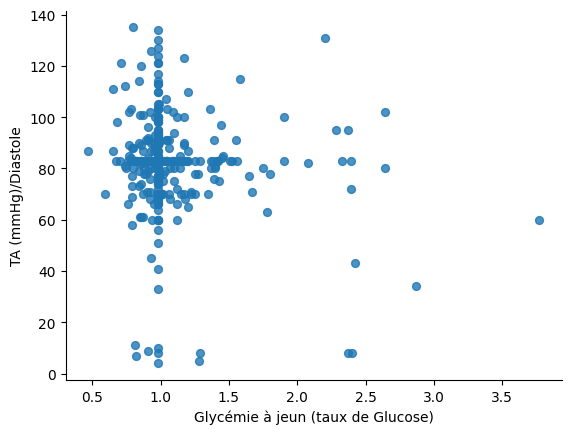

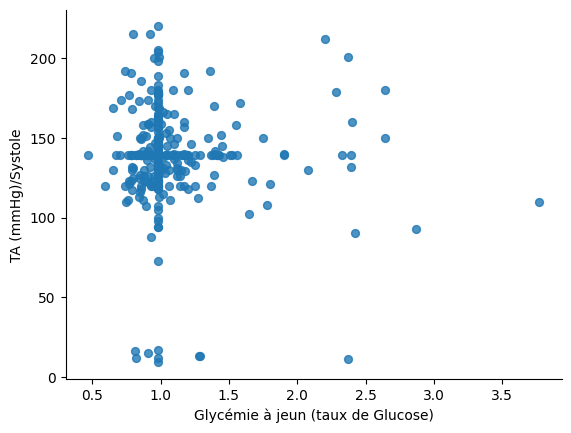

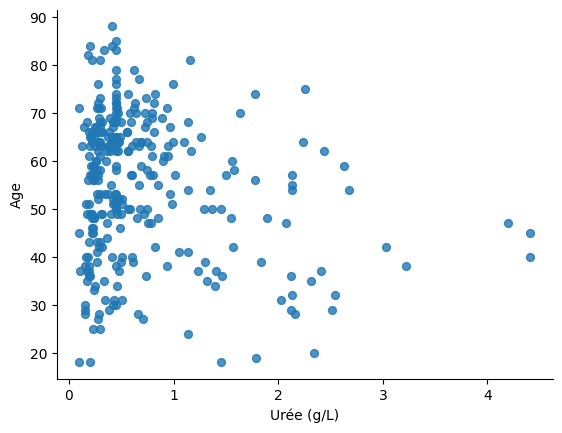

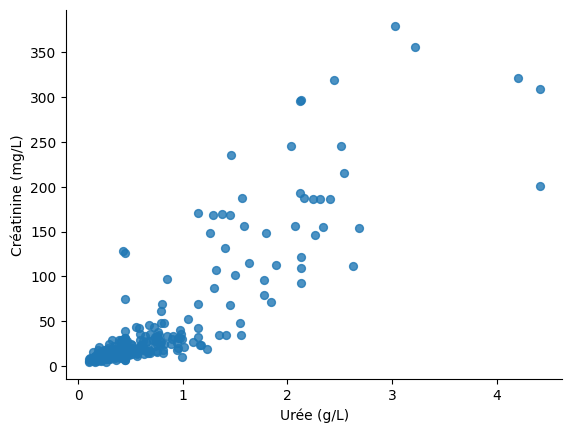

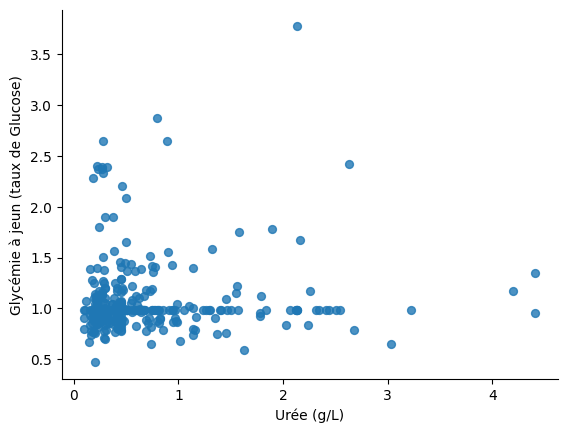

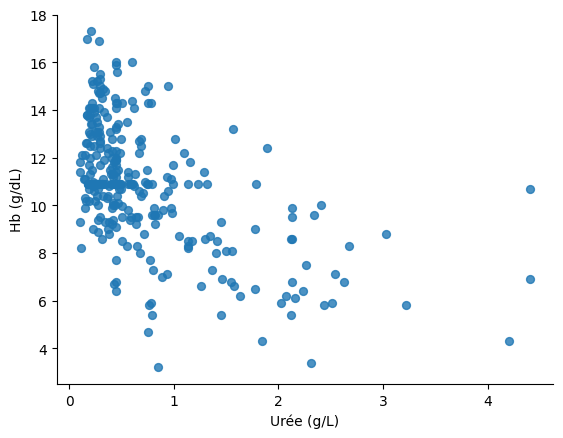

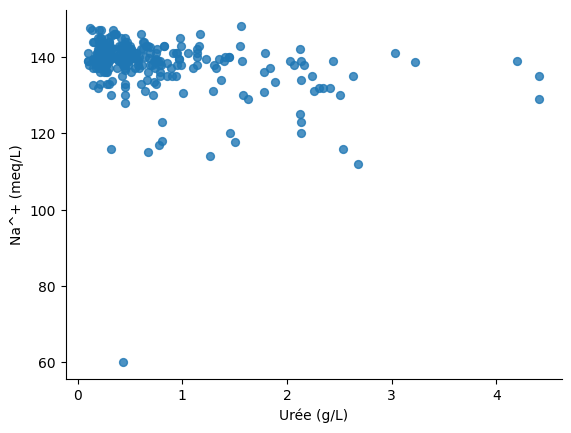

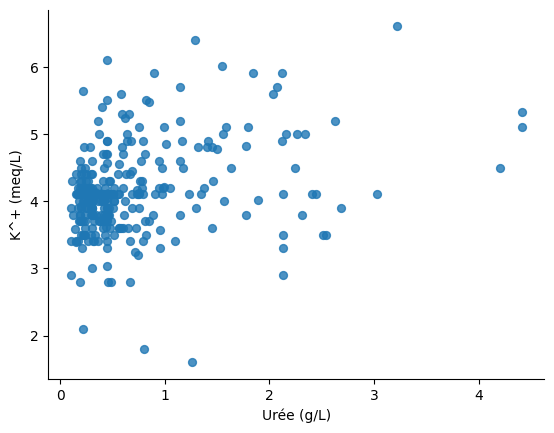

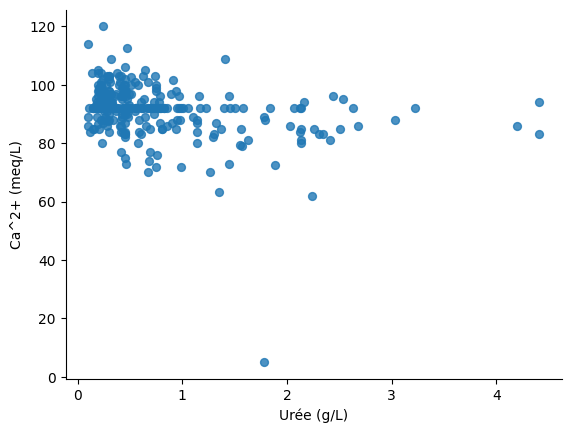

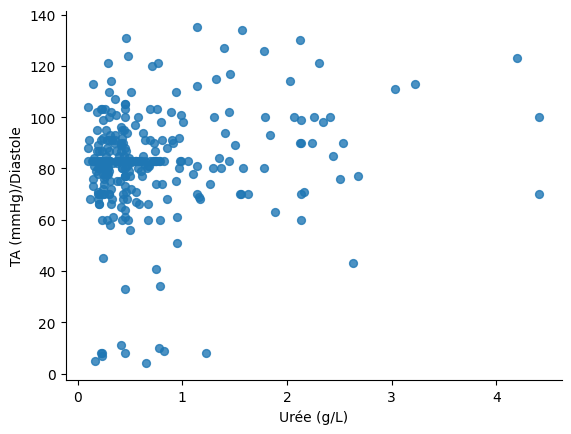

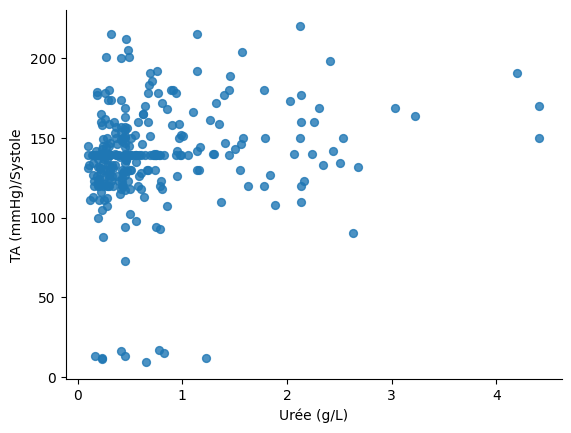

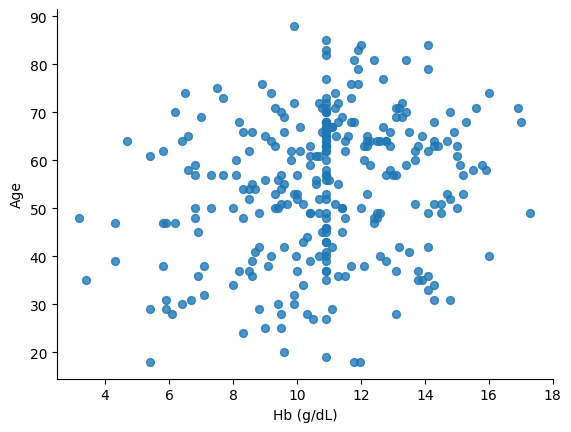

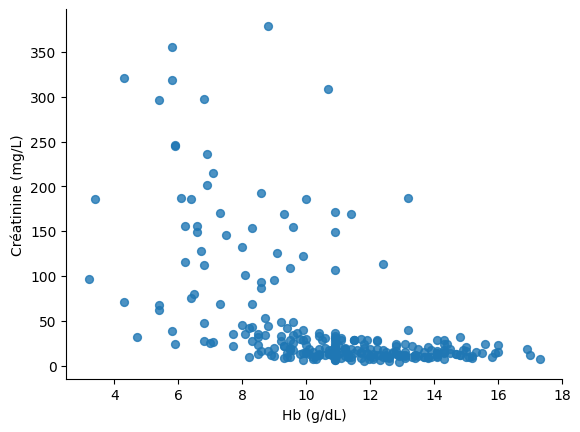

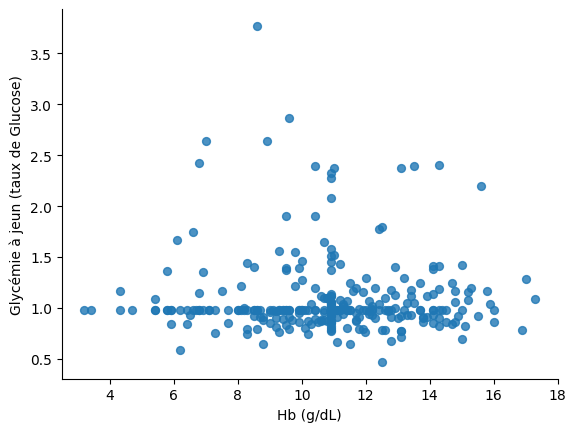

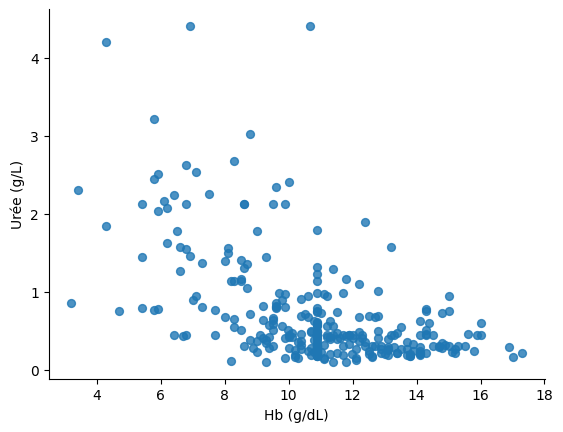

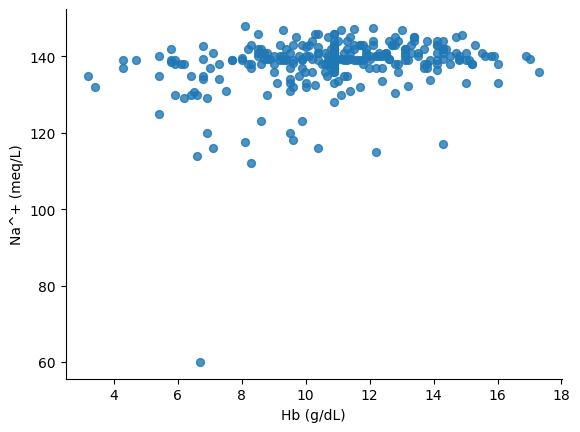

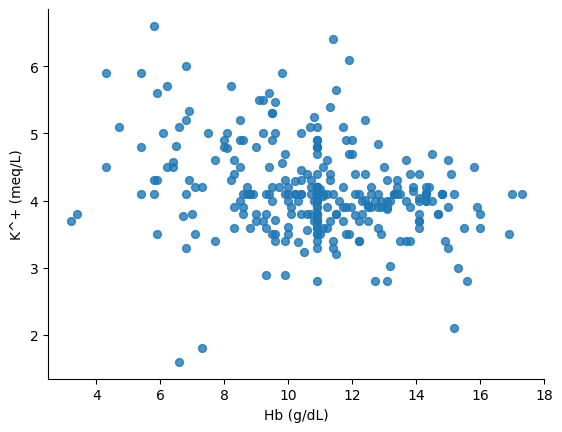

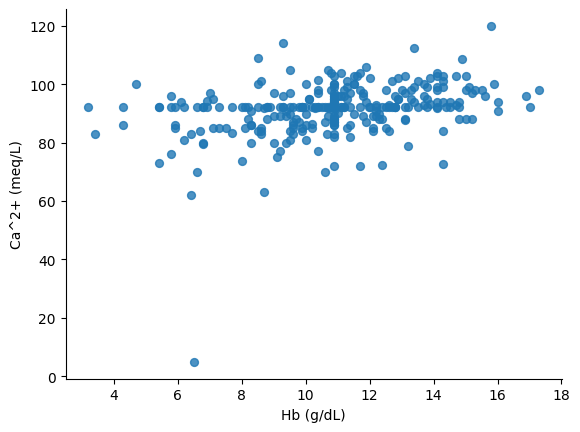

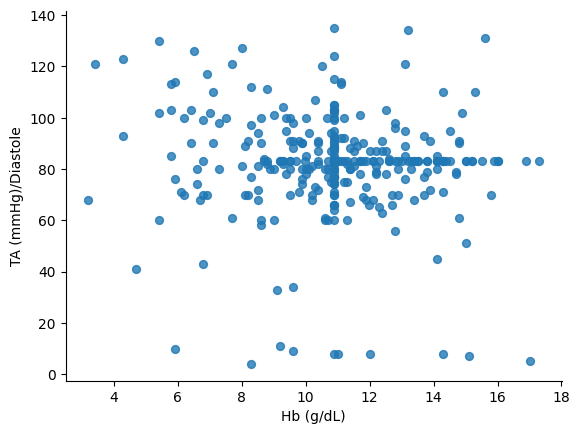

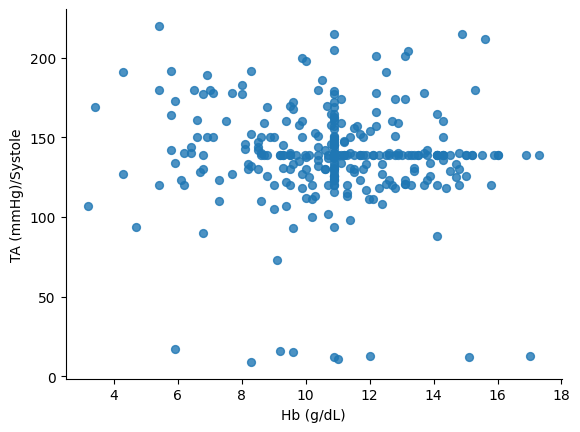

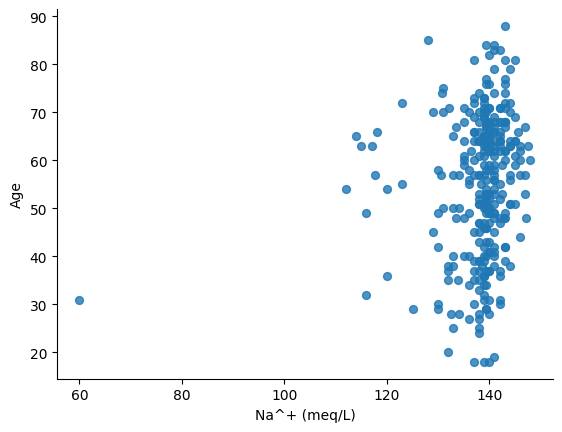

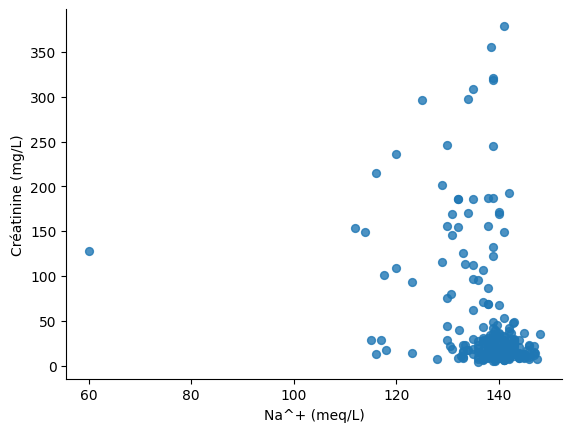

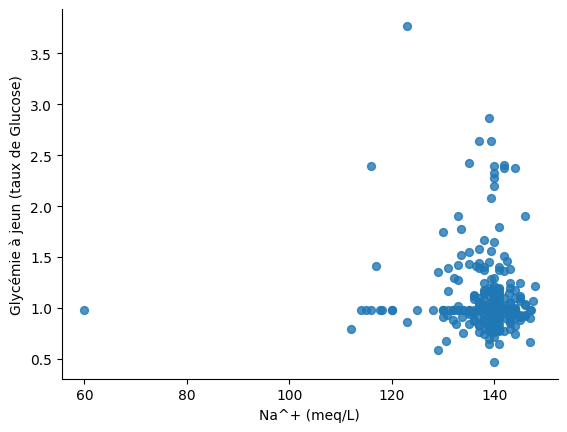

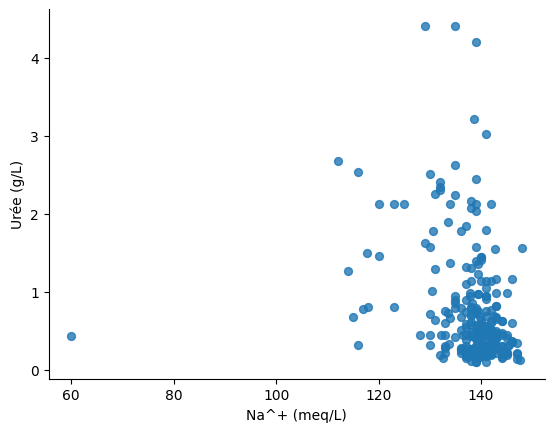

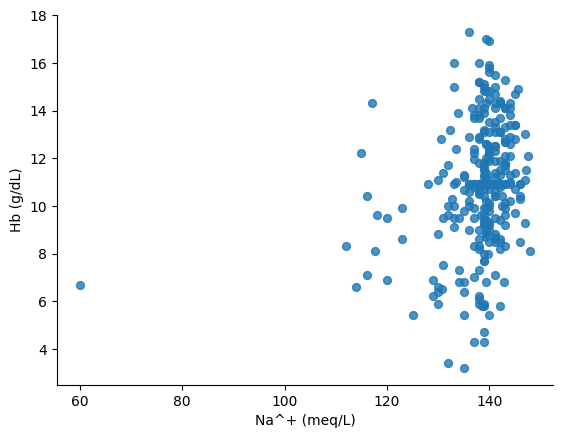

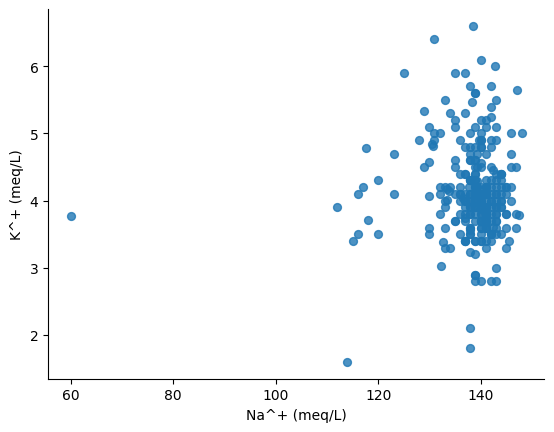

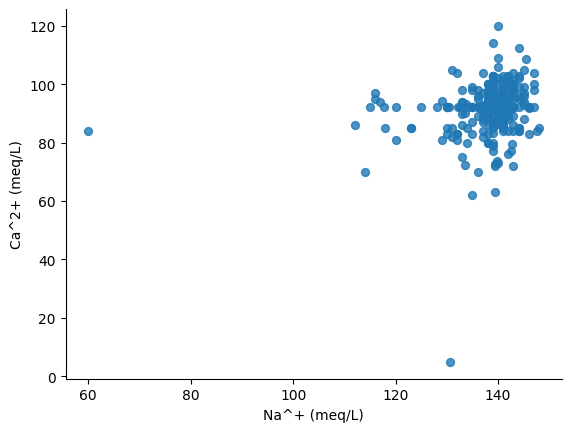

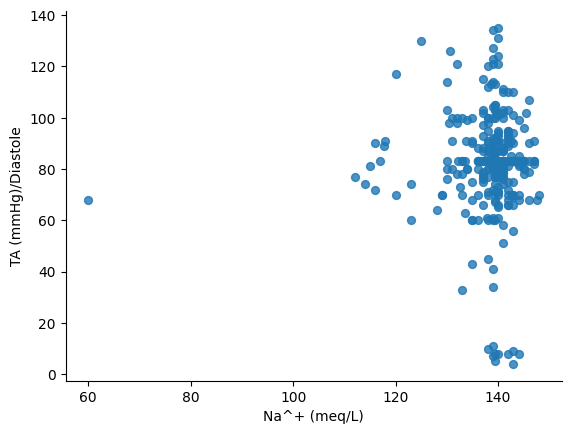

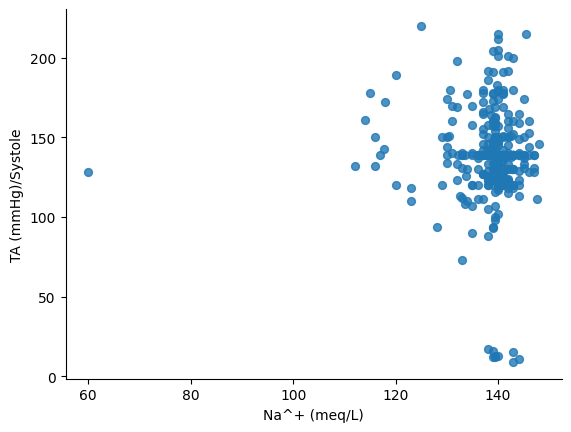

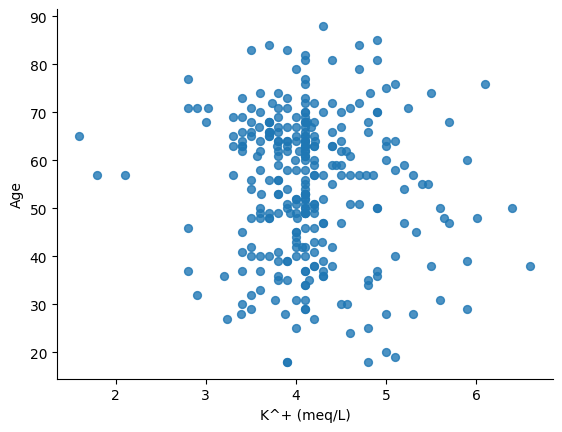

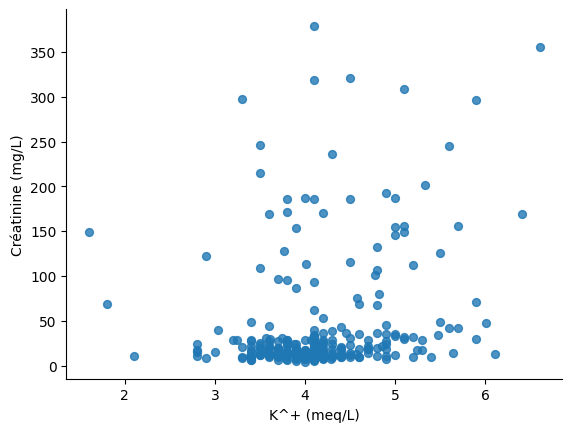

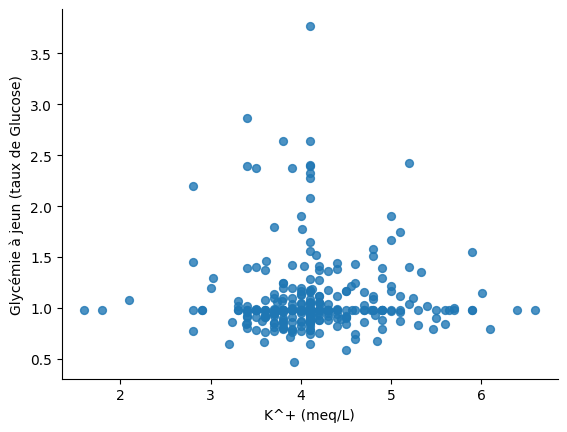

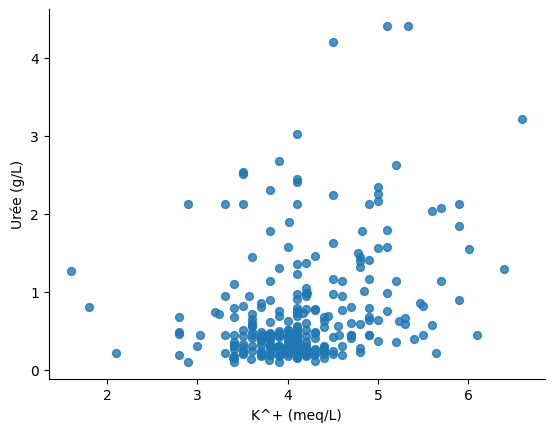

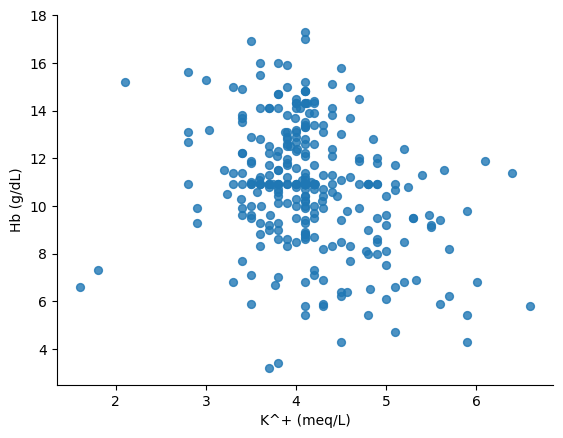

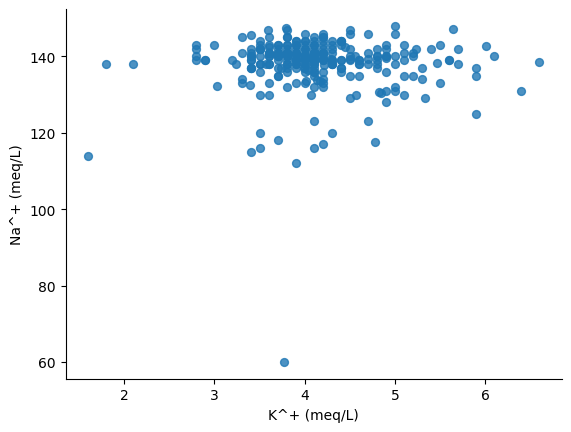

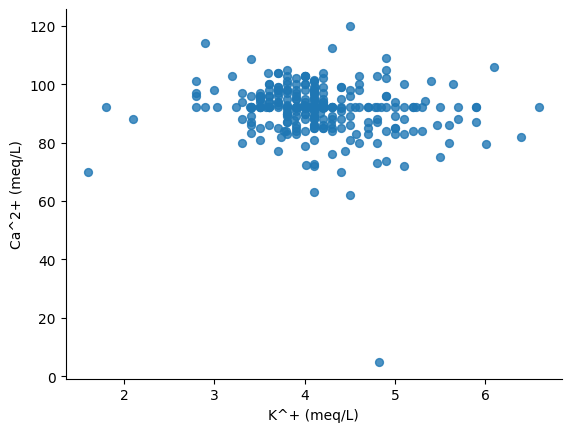

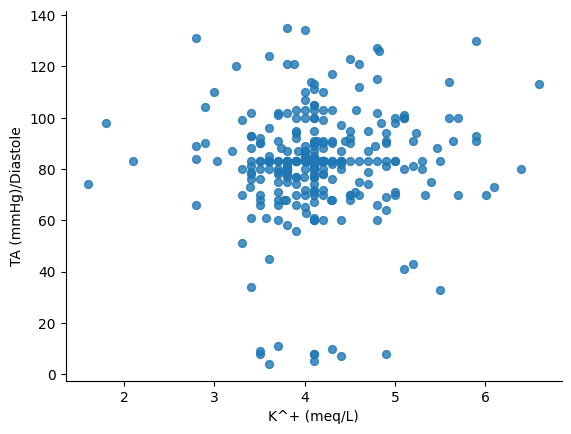

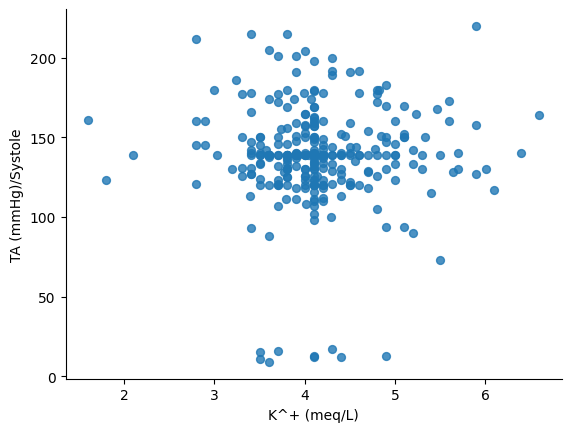

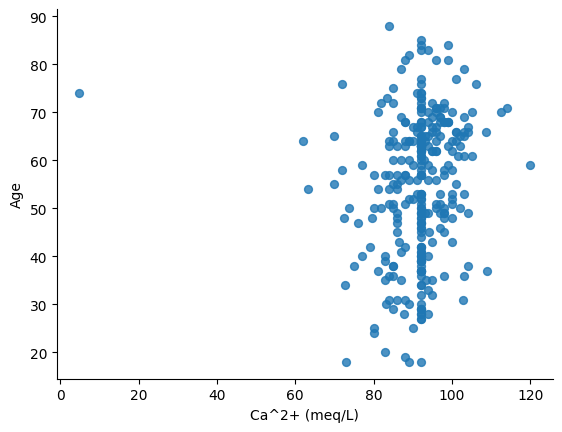

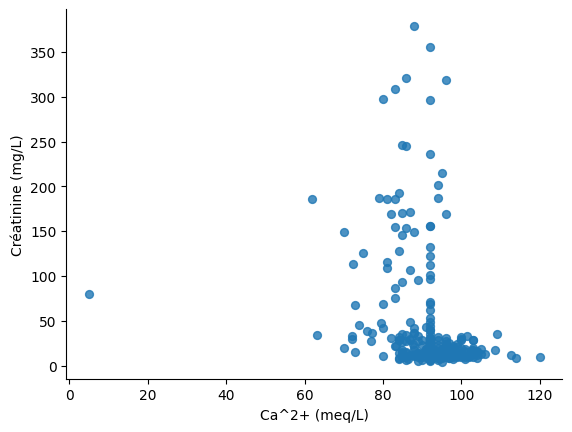

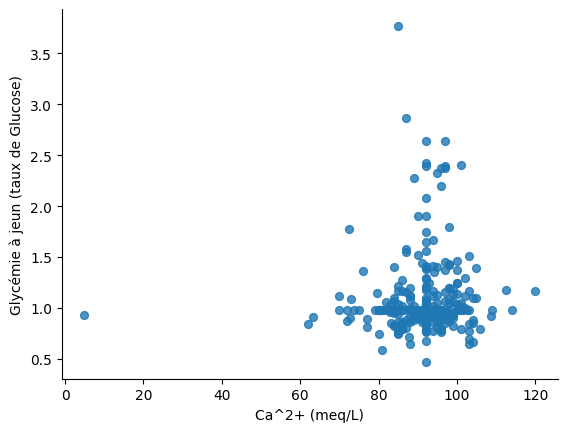

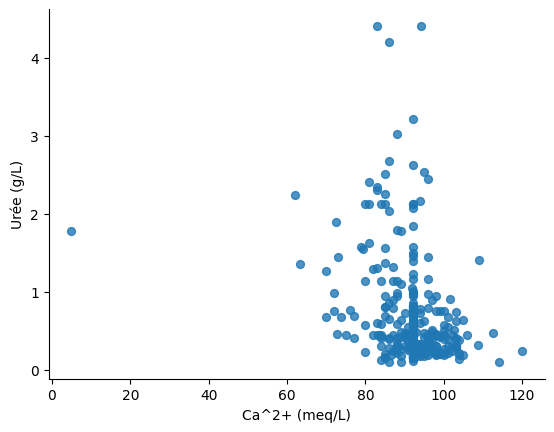

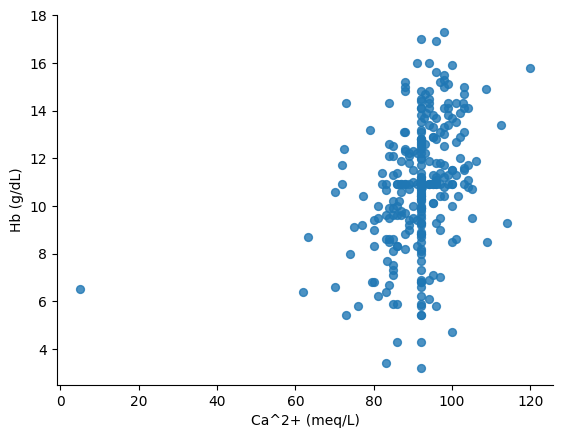

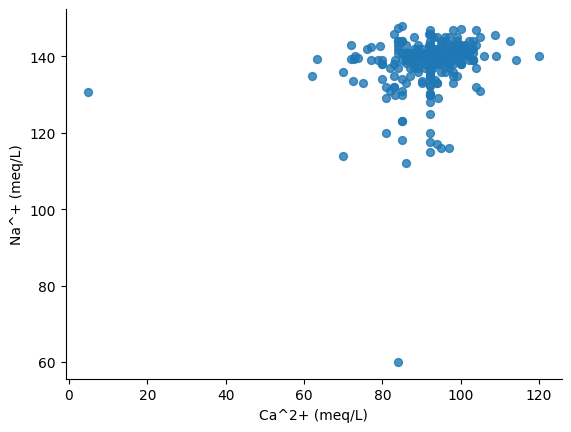

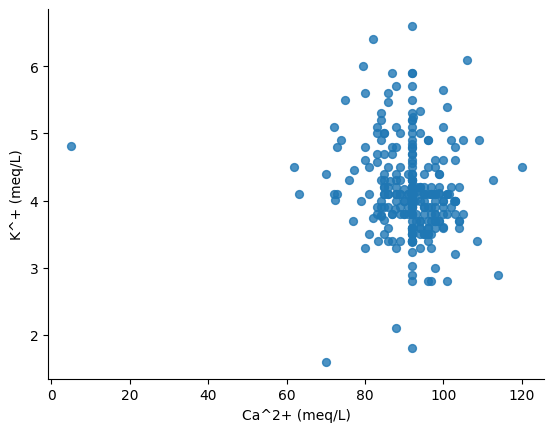

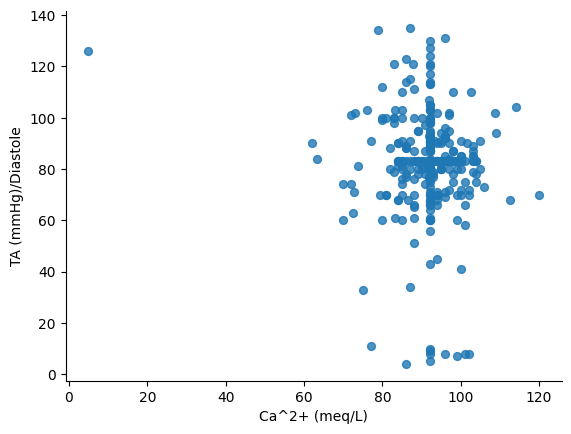

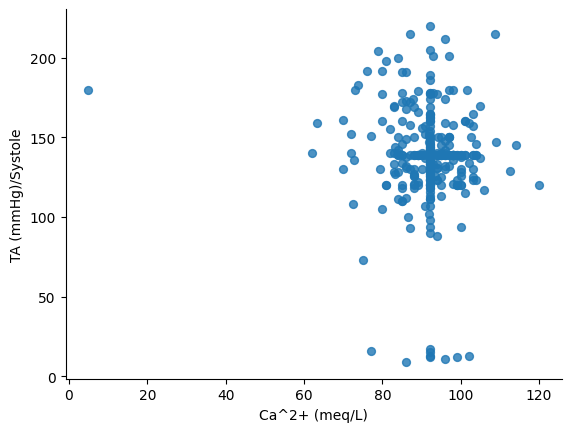

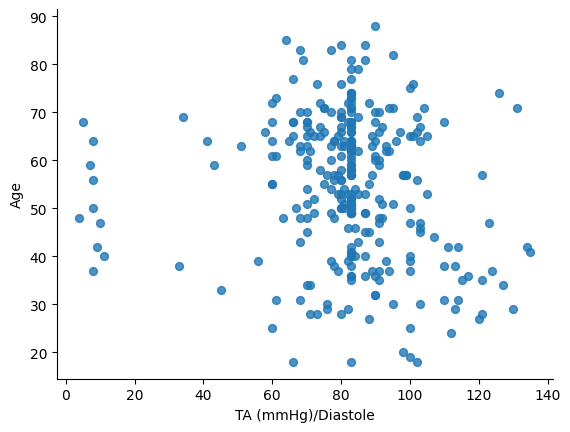

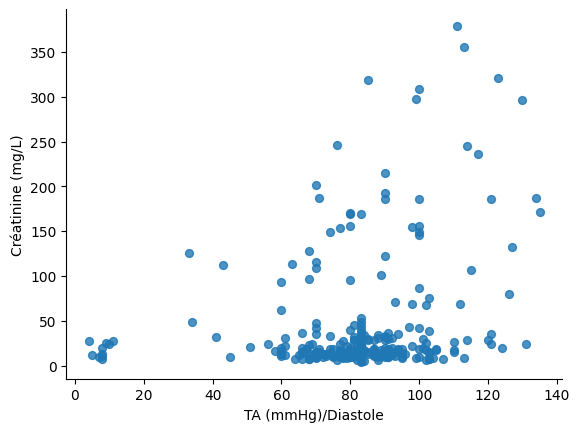

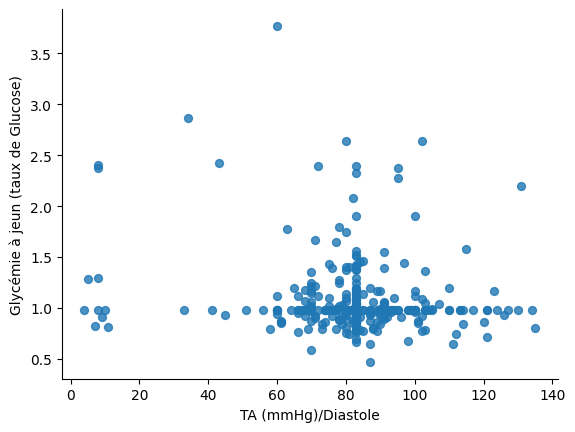

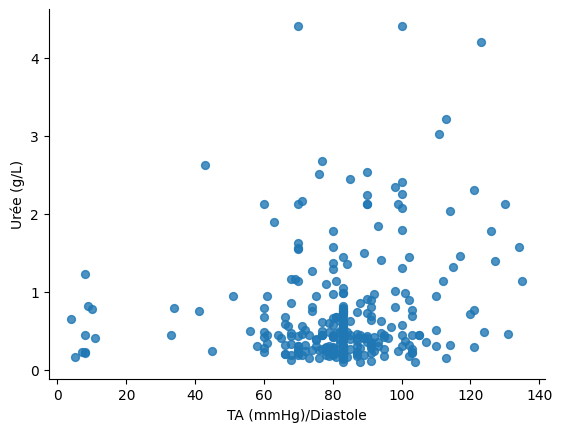

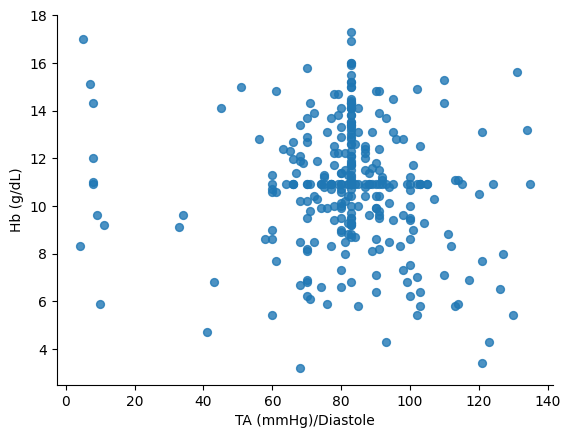

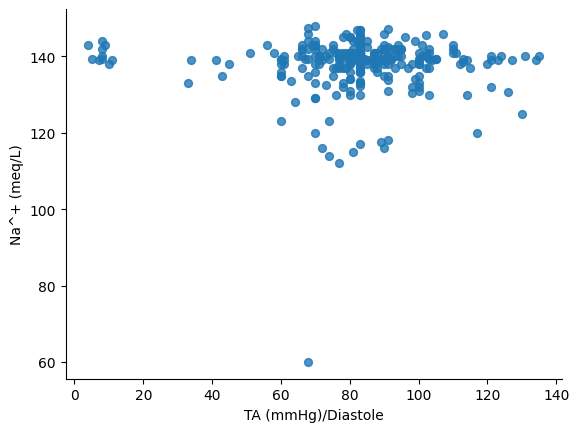

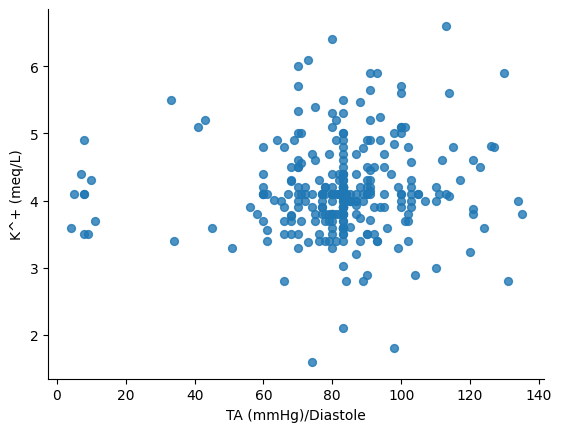

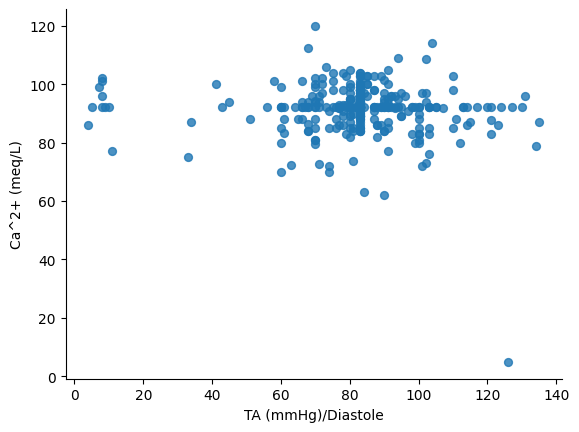

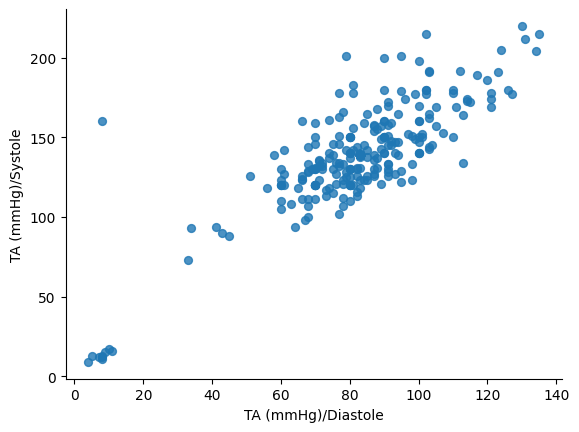

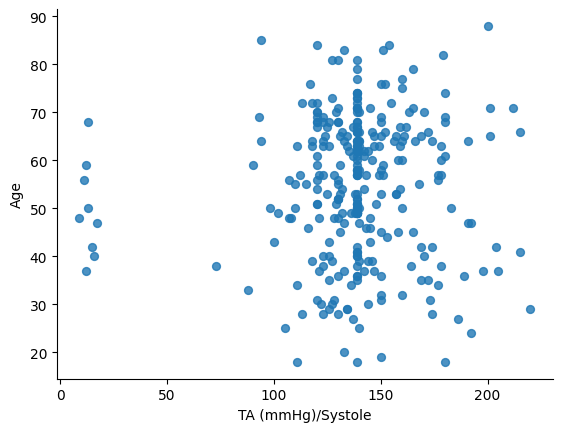

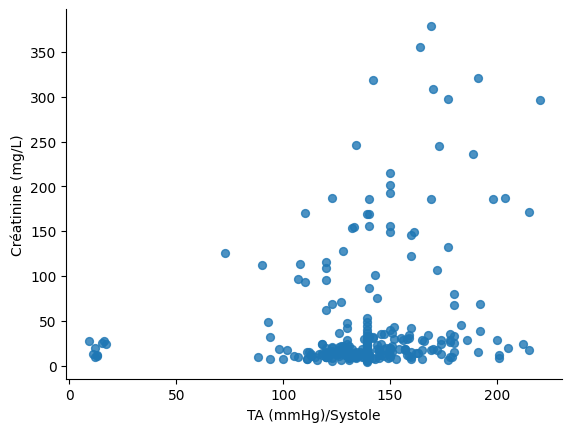

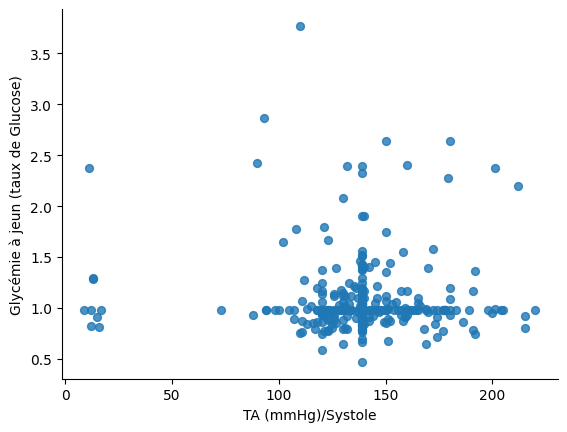

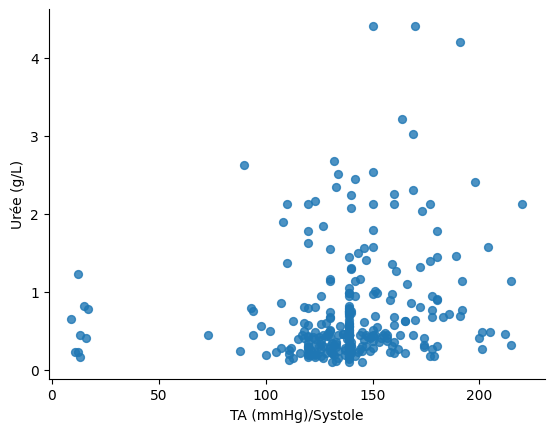

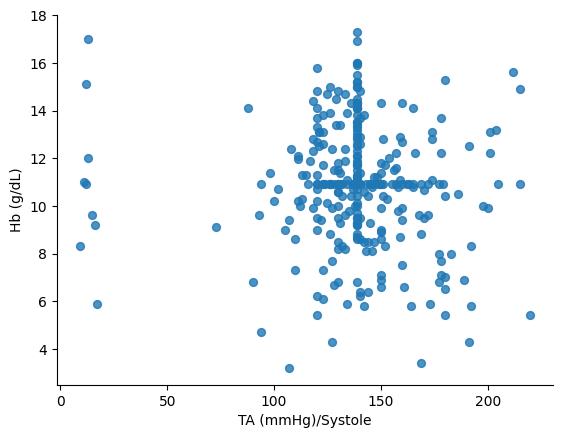

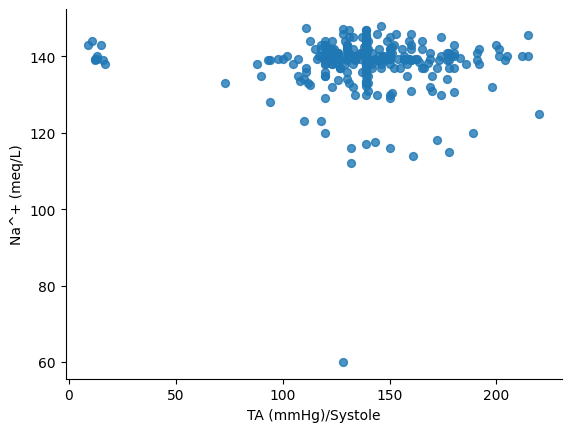

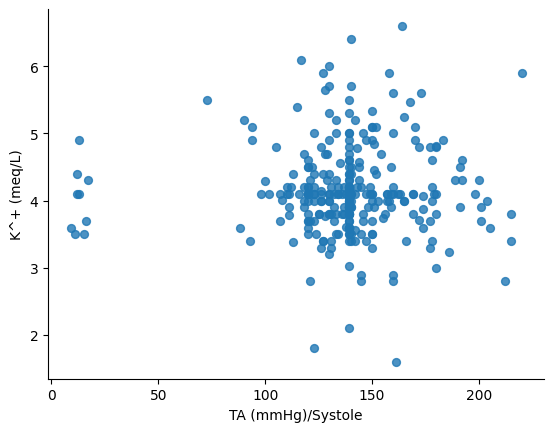

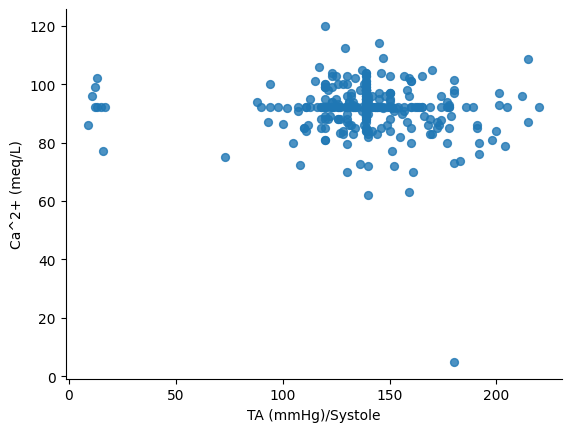

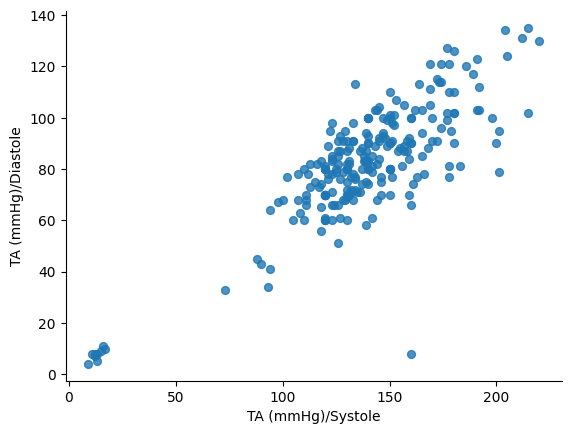

In [116]:
for i in variables_numeriques:
  for j in variables_numeriques:
    if i != j:
      df.plot(kind='scatter', x=i, y=j, s=32, alpha=.8)
      plt.gca().spines[['top', 'right',]].set_visible(False)


# **Sélection des k meilleures caractéristiques**

In [117]:
from sklearn.feature_selection import SelectKBest, f_classif

# Sélection des k meilleures caractéristiques
k = 20  # Vous pouvez ajuster ce nombre
selector = SelectKBest(score_func=f_classif, k=k)
Y = df['Stage de l\'IRC']
X = df.drop('Stage de l\'IRC', axis=1)
# Application du sélecteur
X_new = selector.fit_transform(X, Y)

# Obtenir les scores et les noms des caractéristiques sélectionnées
scores = selector.scores_
features = X.columns

# Créer un DataFrame pour visualiser les résultats
feature_scores = pd.DataFrame({'Feature': features, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

print(f"Top {k} features:")
print(feature_scores.head(k))

Top 20 features:
                                Feature       Score
1                     Créatinine (mg/L)  134.510599
3                            Urée (g/L)  114.278872
5                             Hb (g/dL)   50.410324
12                   Symptômes/Asthénie   30.593422
4       Etat Général (EG) à l'Admission   15.773764
0                                   Age   15.754992
8                         Ca^2+ (meq/L)   14.711049
6                          Na^+ (meq/L)   13.519360
11                     Symptômes/Anémie   11.096545
15                   Symptômes/Oligurie    8.166346
7                           K^+ (meq/L)    6.400077
14                        Symptômes/OMI    5.784281
16                   TA (mmHg)/Diastole    2.827778
17                    TA (mmHg)/Systole    2.429101
13                        Symptômes/HTA    1.488208
9   Pathologies/Rétinopathie diabétique    1.311270
2     Glycémie à jeun (taux de Glucose)    0.537884
10                                 Sexe    0.04

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=18. All the features will be returned.
  warnings.warn(


**Symptômes/Anémie** : Redondant avec Hb

**Symptômes/OMI** : Faible apport en plus de TA & Oligurie

**Symptômes/HTA** :	Déjà couvert par TA

**Sexe** : Non pertinent

**Glycémie à jeun** :	Pas discriminant ici

**Pathologies/Rétinopathie** : Corrélation très faible



In [118]:

features_to_keep = [
    "Stage de l'IRC",
    "Urée (g/L)",
    "Créatinine (mg/L)",
    "Hb (g/dL)",
    "Na^+ (meq/L)",
    "K^+ (meq/L)",
    "Ca^2+ (meq/L)",
    "Age",
    "Sexe",
    "Symptômes/Asthénie",
    # "Symptômes/Oligurie",
    "TA (mmHg)/Systole",
    "Etat Général (EG) à l'Admission"
]


In [119]:
# créé dataset avec features_to_keep
df = df[features_to_keep]

In [120]:
df.head()

Stage de l'IRC  Urée (g/L)  Créatinine (mg/L)  Hb (g/dL)  Na^+ (meq/L)  \
0               5        1.29              169.0       11.4         131.0   
1               5        0.66               17.0        9.5         134.0   
2               5        0.79               48.0        9.6         139.0   
3               5        1.14               42.0        8.2         142.0   
5               5        1.58              156.0        6.6         130.0   

   K^+ (meq/L)  Ca^2+ (meq/L)   Age  Sexe  Symptômes/Asthénie  \
0          6.4          82.00  50.0   0.0                   0   
1          5.3          92.15  28.0   1.0                   1   
2          3.4          87.00  69.0   0.0                   1   
3          5.7          88.00  68.0   1.0                   0   
5          5.1          92.15  58.0   1.0                   1   

   TA (mmHg)/Systole  Etat Général (EG) à l'Admission  
0              140.0                              0.0  
1              130.0                              0.0  
2               93.0                              0.0  
3              130.0                              0.0  
5              150.0                              0.5

# **Modèle**

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


# 8. Préparation des données pour le modèle

# Séparation des caractéristiques (X) et de la variable cible (y)
X = df.drop('Stage de l\'IRC', axis=1)
y = df['Stage de l\'IRC']


# Gestion des valeurs manquantes (imputation simple avec la médiane)
for col in X.columns:  # Select only numeric columns
    if X[col].dtype in ['int64', 'float64']:
        X[col] = X[col].fillna(X[col].median())

# Normalisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encodage de la variable cible (si nécessaire)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 9. Construction et entraînement du modèle
# Modèles :
models = {
    'Logistic Regression': LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='macro')
    }




/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

In [122]:
# 10. Évaluation des modèles
print("\nPerformance des modèles:\n")
for name, result in results.items():
    print(f"Modèle: {name}\n")
    print(f"Accuracy: {result['Accuracy']:.4f}\n")
    print("Classification Report:\n", result['Classification Report'])
    print("Confusion Matrix:\n", result['Confusion Matrix'])
    print("ROC AUC:\n", result['ROC AUC'])
    print("-" * 50)


Performance des modèles:

Modèle: Logistic Regression

Accuracy: 0.5500

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.25      0.25         8
           1       0.00      0.00      0.00        11
           2       0.49      0.85      0.62        20
           3       0.50      0.33      0.40         9
           4       1.00      0.92      0.96        12

    accuracy                           0.55        60
   macro avg       0.45      0.47      0.44        60
weighted avg       0.47      0.55      0.49        60

Confusion Matrix:
 [[ 2  0  6  0  0]
 [ 5  0  6  0  0]
 [ 1  0 17  2  0]
 [ 0  0  6  3  0]
 [ 0  0  0  1 11]]
ROC AUC:
 0.7842906570942285
--------------------------------------------------
Modèle: Decision Tree

Accuracy: 0.7333

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.70      0.64      0.67      


Feature Importance (Random Forest):

| Feature                         | Importance   |
|:--------------------------------|:-------------|
| Créatinine (mg/L)               | 0.357542     |
| Urée (g/L)                      | 0.16149      |
| Hb (g/dL)                       | 0.0921936    |
| Age                             | 0.0737024    |
| K^+ (meq/L)                     | 0.0671039    |
| Ca^2+ (meq/L)                   | 0.0655865    |
| Na^+ (meq/L)                    | 0.0648907    |
| TA (mmHg)/Systole               | 0.0514719    |
| Etat Général (EG) à l'Admission | 0.0263354    |
| Symptômes/Asthénie              | 0.0217827    |
| Sexe                            | 0.0179011    |


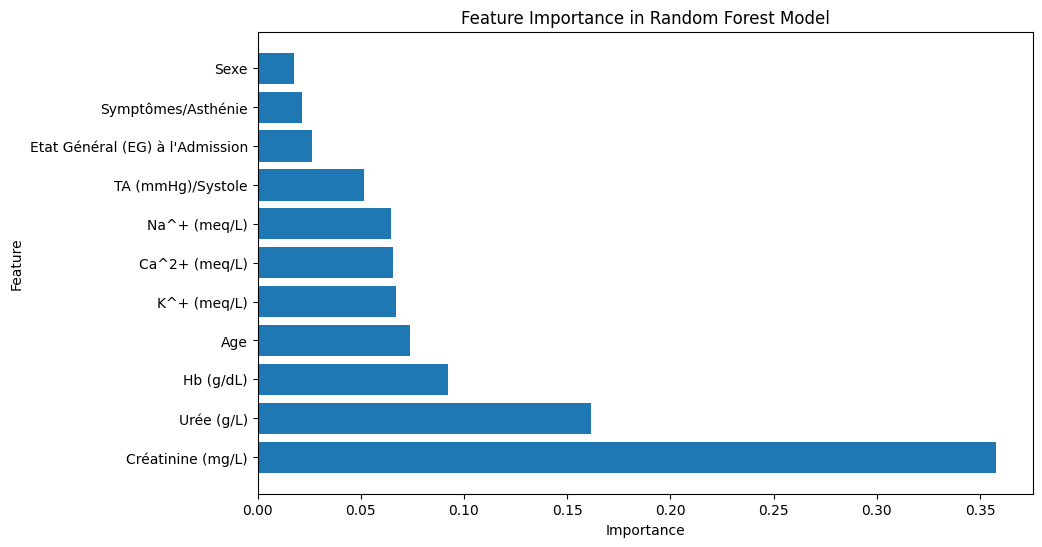

In [123]:
# 11. Feature Importance (For Random Forest)
best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
best_model = models[best_model_name]

if best_model_name == 'Random Forest':
    feature_importances = best_model.feature_importances_
    # Get original column names from the DataFrame before scaling:
    features = df.drop('Stage de l\'IRC', axis=1).columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nFeature Importance (Random Forest):\n")
    print(feature_importance_df.to_markdown(index=False, numalign="left", stralign="left"))

    # Visualize Feature Importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in Random Forest Model')
    plt.show()
else:
    print(f"\nFeature importance is not available for the best model: {best_model_name}")

Distribution des classes avant SMOTE:
Classe 0: 35 échantillons
Classe 1: 42 échantillons
Classe 2: 77 échantillons
Classe 3: 40 échantillons
Classe 4: 46 échantillons

Distribution des classes après SMOTE:
Classe 0: 77 échantillons
Classe 1: 77 échantillons
Classe 2: 77 échantillons
Classe 3: 77 échantillons
Classe 4: 77 échantillons


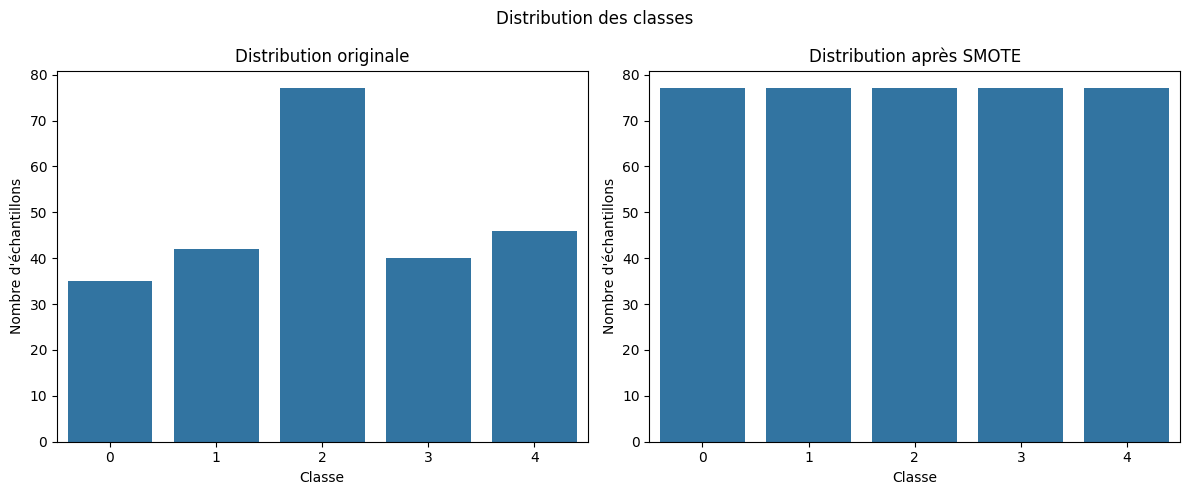


##################################################
Optimisation du modèle: Logistic Regression avec SMOTE
##################################################
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Modèle: LogisticRegression avec SMOTE
Temps d'exécution: 830.08 secondes
Meilleurs paramètres: {'model__C': np.float64(1000.0), 'model__class_weight': 'balanced', 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Meilleur score (f1_weighted): 0.6050

Top 5 configurations:
                                                params  mean_test_f1_weighted  \
866  {'model__C': 1000.0, 'model__class_weight': 'b...               0.605024   
846  {'model__C': 1000.0, 'model__class_weight': 'b...               0.605024   
886  {'model__C': 1000.0, 'model__class_weight': 'b...               0.605024   
885  {'model__C': 1000.0, 'model__class_weight': 'b...               0.604210   
845  {'model__C': 1000.0, 'model__class_weight': 'b...               0.604

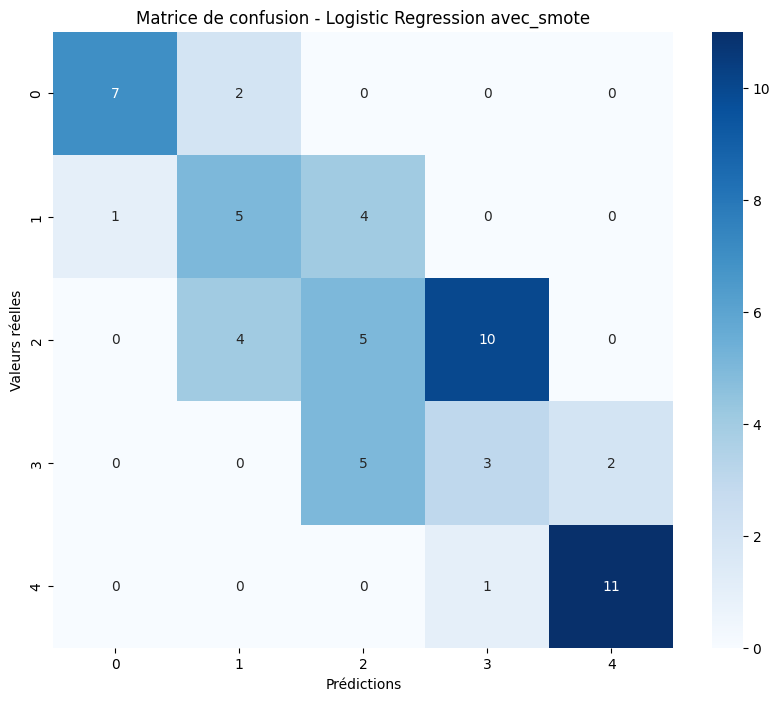

Modèle sauvegardé à: final_avec_smote_logistic_regression.pkl

##################################################
Optimisation du modèle: Decision Tree avec SMOTE
##################################################
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Modèle: DecisionTreeClassifier avec SMOTE
Temps d'exécution: 41.88 secondes
Meilleurs paramètres: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Meilleur score (f1_weighted): 0.7633

Top 5 configurations:
                                                params  mean_test_f1_weighted  \
269  {'model__criterion': 'entropy', 'model__max_de...               0.763292   
268  {'model__criterion': 'entropy', 'model__max_de...               0.763292   
267  {'model__criterion': 'entropy', 'model__max_de...               0.763292   
214  {'model__criterion': 'entropy', 'model__max_de...               0.763292   
215  {'mode

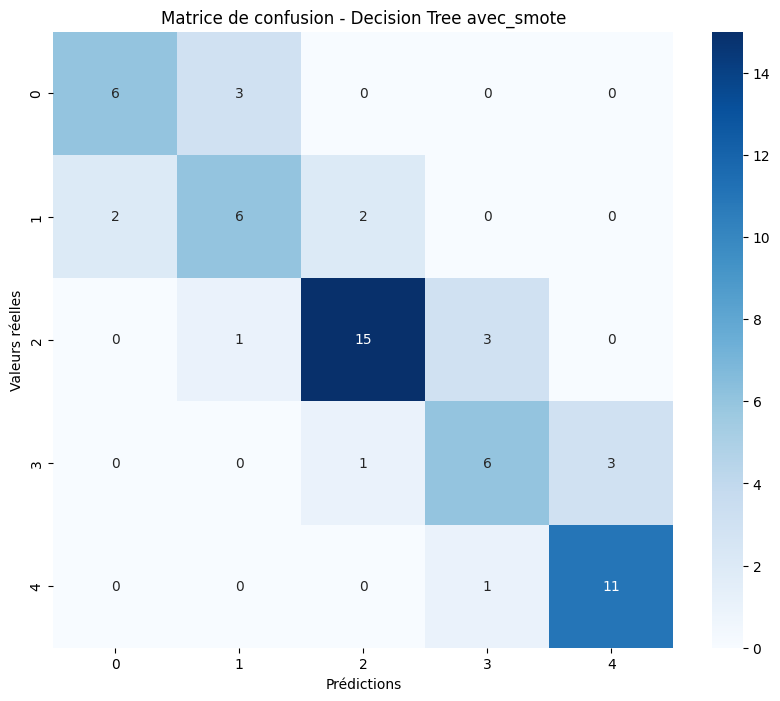

Modèle sauvegardé à: final_avec_smote_decision_tree.pkl

##################################################
Optimisation du modèle: Random Forest avec SMOTE
##################################################
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Modèle: RandomForestClassifier avec SMOTE
Temps d'exécution: 97.42 secondes
Meilleurs paramètres: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 30, 'model__bootstrap': True}
Meilleur score (f1_weighted): 0.8018

Top 5 configurations:
                                               params  mean_test_f1_weighted  \
27  {'model__n_estimators': 200, 'model__min_sampl...               0.801755   
31  {'model__n_estimators': 200, 'model__min_sampl...               0.801755   
23  {'model__n_estimators': 100, 'model__min_sampl...               0.792311   
44  {'model__n_estimators': 200, 'model__min_sampl...               0.788902   
45 

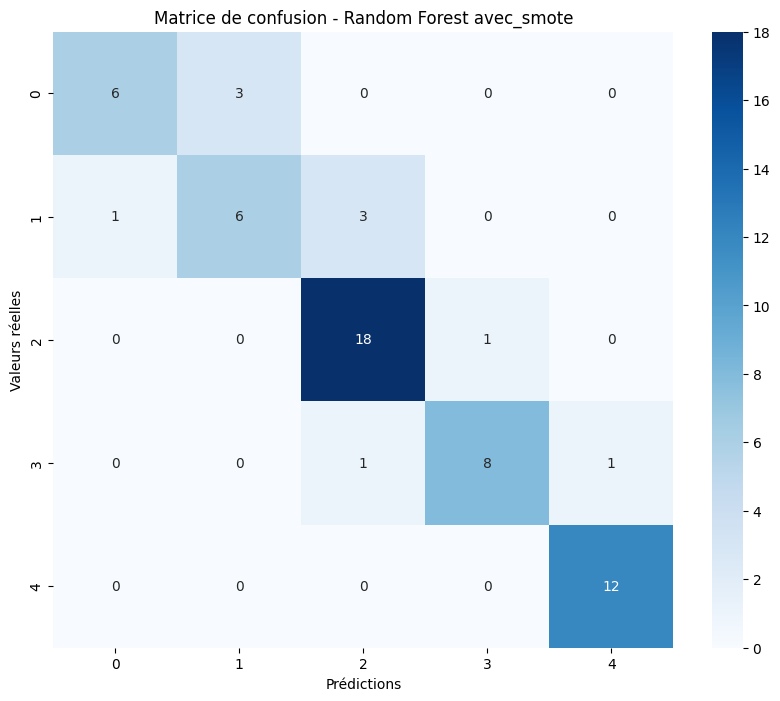

Modèle sauvegardé à: final_avec_smote_random_forest.pkl

##################################################
Optimisation du modèle: Gradient Boosting avec SMOTE
##################################################
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Modèle: GradientBoostingClassifier avec SMOTE
Temps d'exécution: 440.83 secondes
Meilleurs paramètres: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 5, 'model__learning_rate': 0.01}
Meilleur score (f1_weighted): 0.8307

Top 5 configurations:
                                               params  mean_test_f1_weighted  \
28  {'model__subsample': 0.8, 'model__n_estimators...               0.830666   
37  {'model__subsample': 0.8, 'model__n_estimators...               0.825161   
43  {'model__subsample': 0.8, 'model__n_estimators...               0.820822   
44  {'model__subsample': 0.8, 'model__n_estimators...               0.82070

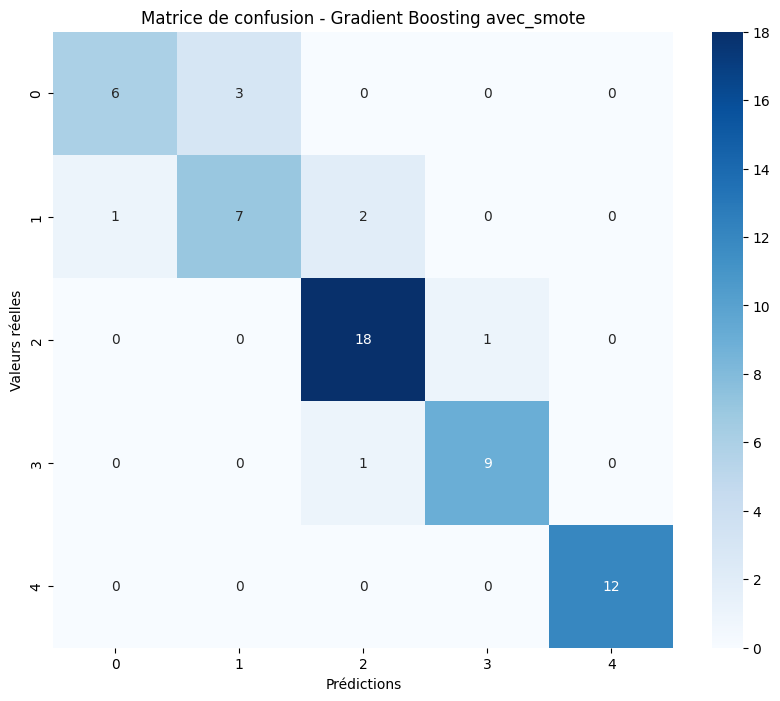

Modèle sauvegardé à: final_avec_smote_gradient_boosting.pkl

##################################################
Optimisation du modèle: SVM avec SMOTE
##################################################
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Modèle: SVC avec SMOTE
Temps d'exécution: 52.20 secondes
Meilleurs paramètres: {'model__C': 100, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'linear'}
Meilleur score (f1_weighted): 0.7623

Top 5 configurations:
                                               params  mean_test_f1_weighted  \
82  {'model__C': 100, 'model__class_weight': 'bala...               0.762299   
85  {'model__C': 100, 'model__class_weight': None,...               0.762299   
91  {'model__C': 100, 'model__class_weight': None,...               0.762299   
88  {'model__C': 100, 'model__class_weight': None,...               0.762299   
94  {'model__C': 100, 'model__class_weight': None,...               0.762299   

    std_tes

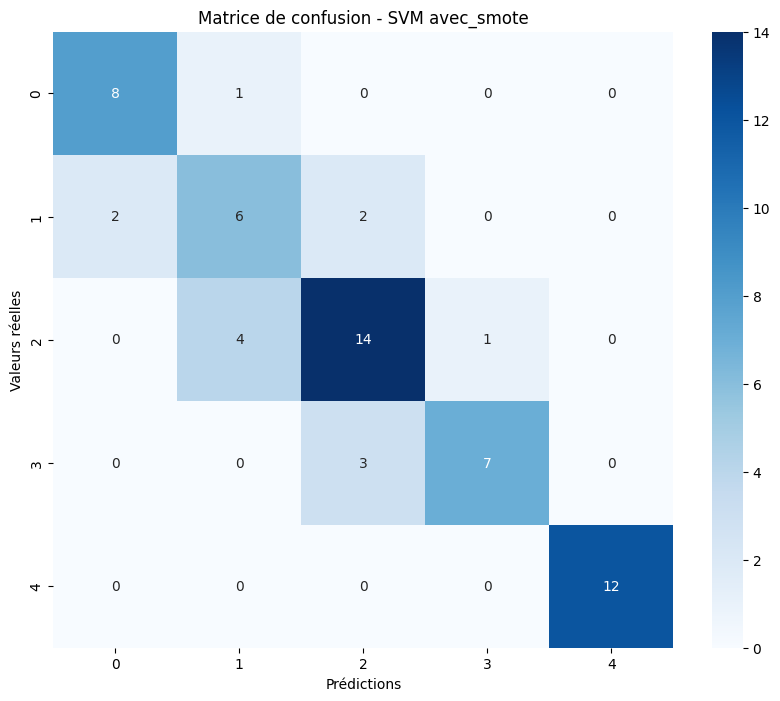

Modèle sauvegardé à: final_avec_smote_svm.pkl

##################################################
Optimisation du modèle: XGBoost avec SMOTE
##################################################
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Modèle: XGBClassifier avec SMOTE
Temps d'exécution: 53.20 secondes
Meilleurs paramètres: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0.1, 'model__colsample_bytree': 0.8}
Meilleur score (f1_weighted): 0.8061

Top 5 configurations:
                                               params  mean_test_f1_weighted  \
38  {'model__subsample': 0.8, 'model__n_estimators...               0.806104   
42  {'model__subsample': 0.8, 'model__n_estimators...               0.802879   
32  {'model__subsample': 0.8, 'model__n_estimators...               0.801712   
10  {'model__subsample': 0.9, 'model__n_estimators...               0.798735   
2   {'mo

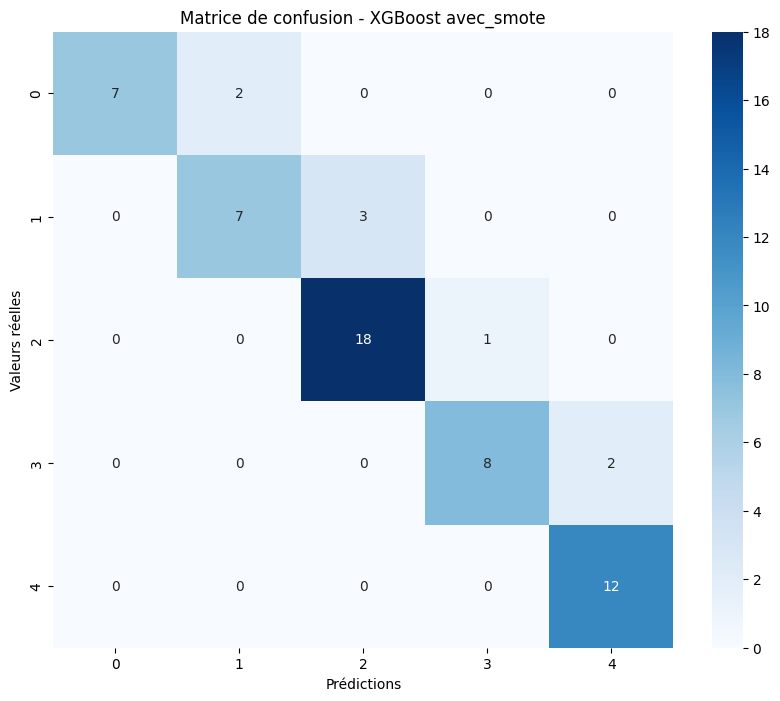

Modèle sauvegardé à: final_avec_smote_xgboost.pkl

--- Tableau comparatif des modèles ---
                     accuracy  f1_weighted  precision_weighted  \
model                                                            
Logistic Regression  0.516667     0.516521            0.525048   
Decision Tree        0.733333     0.731870            0.733532   
Random Forest        0.833333     0.828163            0.831537   
Gradient Boosting    0.866667     0.864167            0.866667   
SVM                  0.783333     0.784517            0.790076   
XGBoost              0.866667     0.864023            0.870635   

                     recall_weighted  
model                                 
Logistic Regression         0.516667  
Decision Tree               0.733333  
Random Forest               0.833333  
Gradient Boosting           0.866667  
SVM                         0.783333  
XGBoost                     0.866667  


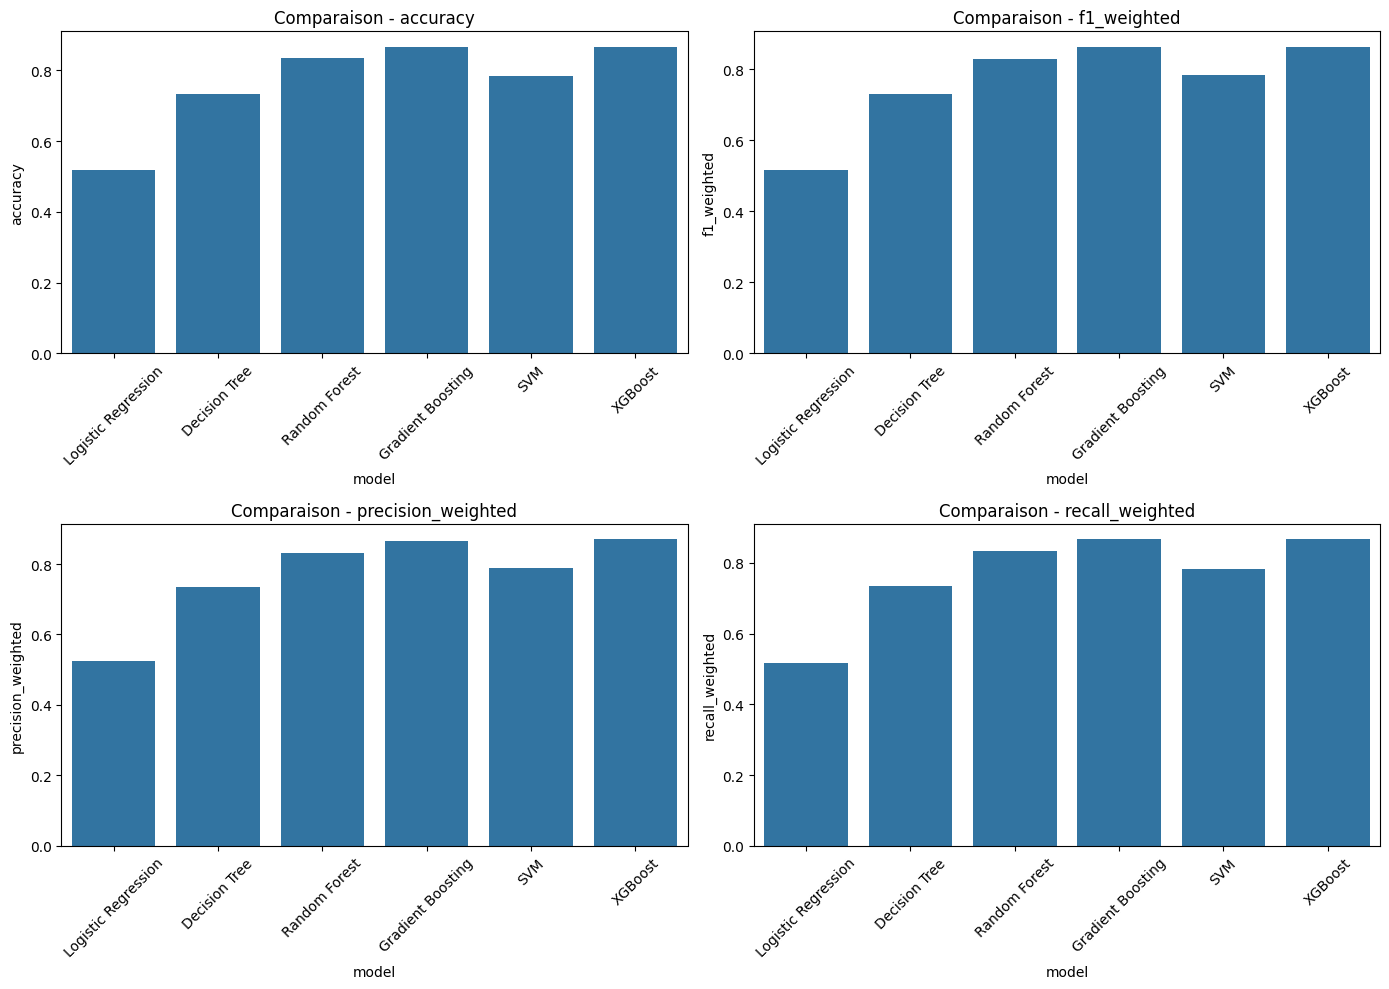


Le meilleur modèle est Gradient Boosting avec un F1 score pondéré de 0.8642


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            roc_auc_score, make_scorer, f1_score, precision_score, recall_score)
from sklearn.pipeline import Pipeline
import joblib
from time import time
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Intégration de SMOTE pour le rééquilibrage des classes
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration de la validation croisée avec stratification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Définition des métriques d'évaluation complètes
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}

# Fonction pour visualiser la distribution des classes avant et après SMOTE
def plot_class_distribution(y_original, y_resampled, title="Distribution des classes"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x=y_original)
    plt.title('Distribution originale')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title('Distribution après SMOTE')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Fonction pour l'optimisation des hyperparamètres avec SMOTE
def optimize_hyperparameters_with_smote(model, param_grid, X_train, y_train, cv=cv,
                                      scoring=scoring, search_type='grid', n_iter=100,
                                      refit_metric='f1_weighted', save_path=None):
    """
    Optimisation des hyperparamètres avec SMOTE intégré
    """
    start_time = time()

    # Création d'un pipeline avec SMOTE
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Modification des noms des paramètres pour le pipeline
    pipeline_param_grid = {}
    for param, values in param_grid.items():
        pipeline_param_grid[f'model__{param}'] = values

    # Sélection de la méthode de recherche
    if search_type == 'grid':
        search = GridSearchCV(
            estimator=pipeline,
            param_grid=pipeline_param_grid,
            cv=cv,
            scoring=scoring,
            refit=refit_metric,
            n_jobs=-1,
            verbose=1,
            return_train_score=True
        )
    else:  # RandomizedSearchCV
        from sklearn.model_selection import RandomizedSearchCV
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=pipeline_param_grid,
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            refit=refit_metric,
            n_jobs=-1,
            random_state=42,
            verbose=1,
            return_train_score=True
        )

    # Ajustement du modèle
    search.fit(X_train, y_train)

    # Temps d'exécution
    elapsed_time = time() - start_time

    # Affichage des résultats
    print(f"Modèle: {model.__class__.__name__} avec SMOTE")
    print(f"Temps d'exécution: {elapsed_time:.2f} secondes")
    print(f"Meilleurs paramètres: {search.best_params_}")
    print(f"Meilleur score ({refit_metric}): {search.best_score_:.4f}")

    # Créer un DataFrame avec les résultats
    cv_results = pd.DataFrame(search.cv_results_)

    # Déterminer le nom de la colonne de rang
    rank_col = f'rank_test_{refit_metric}'
    cv_results = cv_results.sort_values(by=rank_col)

    # Afficher les meilleurs résultats
    print("\nTop 5 configurations:")
    cols_to_display = ['params',
                       f'mean_test_{refit_metric}', f'std_test_{refit_metric}',
                       'mean_test_accuracy', 'mean_test_precision_weighted',
                       'mean_test_recall_weighted', rank_col,
                       f'mean_train_{refit_metric}']

    # Calculer l'écart entre les scores d'entraînement et de test pour détecter l'overfitting
    cv_results['overfitting_gap'] = cv_results[f'mean_train_{refit_metric}'] - cv_results[f'mean_test_{refit_metric}']
    cols_to_display.append('overfitting_gap')

    print(cv_results[cols_to_display].head())

    # Sauvegarder le modèle si demandé
    if save_path:
        joblib.dump(search.best_estimator_, save_path)
        print(f"Meilleur modèle sauvegardé à: {save_path}")

    return search.best_estimator_, search.best_params_, cv_results

# Évaluation du modèle avec matrice de confusion
def evaluate_model_with_smote(model, X_test, y_test, model_name, save_path=None):
    """
    Évaluation complète d'un modèle avec matrice de confusion et métriques
    """
    # Prédictions
    start_time = time()
    y_pred = model.predict(X_test)
    inference_time = time() - start_time

    # Probabilités si disponibles
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')

    # Rapport de classification
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Affichage des résultats
    print(f"\n{'='*20} Évaluation du modèle {model_name} {'='*20}")
    print(f"Temps d'inférence: {inference_time:.4f} secondes")
    print(f"Exactitude: {accuracy:.4f}")
    print(f"F1 score pondéré: {weighted_f1:.4f}")
    print(f"Précision pondérée: {weighted_precision:.4f}")
    print(f"Rappel pondéré: {weighted_recall:.4f}")
    print("\nRapport de classification détaillé:")
    print(classification_report(y_test, y_pred))

    # Matrice de confusion
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.show()

    # Sauvegarder le modèle si demandé
    if save_path:
        joblib.dump(model, save_path)
        print(f"Modèle sauvegardé à: {save_path}")

    return {
        'accuracy': accuracy,
        'f1_weighted': weighted_f1,
        'precision_weighted': weighted_precision,
        'recall_weighted': weighted_recall,
        'report': report_df,
        'inference_time': inference_time,
        'confusion_matrix': cm
    }

# Fonction pour comparer visuellement les modèles
def compare_models(results):
    """
    Création de visualisations comparatives des performances des modèles
    """
    metrics = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']

    # Création du DataFrame de comparaison
    comparison_data = {
        metric: [results[model][metric] for model in results]
        for metric in metrics
    }
    comparison_data['model'] = list(results.keys())
    comparison_df = pd.DataFrame(comparison_data)

    # Affichage du tableau
    print("\n--- Tableau comparatif des modèles ---")
    print(comparison_df.set_index('model'))

    # Visualisation
    plt.figure(figsize=(14, 10))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.barplot(x='model', y=metric, data=comparison_df)
        plt.title(f'Comparaison - {metric}')
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.show()

    # Retourner le DataFrame de comparaison
    return comparison_df

# Pipeline complet avec SMOTE
def run_complete_pipeline(X, y, test_size=0.2, random_state=42, models_to_try=None, use_smote=True):
    """
    Pipeline complet, de la préparation des données à l'évaluation
    """
    # Division des données en train/test avec stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    if use_smote:
        # Affichage de la distribution des classes avant SMOTE
        print("Distribution des classes avant SMOTE:")
        unique, counts = np.unique(y_train, return_counts=True)
        for cls, count in zip(unique, counts):
            print(f"Classe {cls}: {count} échantillons")

        # Application de SMOTE sur le jeu d'entraînement pour visualisation
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Affichage de la distribution après SMOTE
        print("\nDistribution des classes après SMOTE:")
        unique, counts = np.unique(y_train_resampled, return_counts=True)
        for cls, count in zip(unique, counts):
            print(f"Classe {cls}: {count} échantillons")

        # Visualisation
        plot_class_distribution(y_train, y_train_resampled)

    # Configuration des modèles et de leurs hyperparamètres à tester
    models = {
        'Logistic Regression': (
            LogisticRegression(multi_class='ovr', random_state=42),
            {
                'C': np.logspace(-4, 4, 9),
                'penalty': ['l1', 'l2', 'elasticnet', None],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'class_weight': ['balanced', None],
                'max_iter': [1000, 2000, 5000]
            }
        ),
        'Decision Tree': (
            DecisionTreeClassifier(random_state=42),
            {
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'criterion': ['gini', 'entropy'],
                'max_features': ['sqrt', 'log2', None]
            }
        ),
        'Random Forest': (
            RandomForestClassifier(random_state=42),
            {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None],
                'bootstrap': [True, False]
            }
        ),
        'Gradient Boosting': (
            GradientBoostingClassifier(random_state=42),
            {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.05, 0.1],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                'subsample': [0.8, 1.0]
            }
        ),
        'SVM': (
            SVC(probability=True, random_state=42),
            {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.1, 0.01],
                'kernel': ['rbf', 'linear', 'poly'],
                'class_weight': ['balanced', None]
            }
        ),
        'XGBoost': (
            XGBClassifier(random_state=42, objective='multi:softmax', eval_metric='mlogloss'),
            {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.05, 0.1],
                'max_depth': [3, 5, 7],
                'min_child_weight': [1, 3, 5],
                'gamma': [0, 0.1, 0.2],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 1.0]
            }
        )
    }

    # Filtrer les modèles si spécifié
    if models_to_try:
        models = {k: models[k] for k in models_to_try if k in models}

    # Optimiser et évaluer chaque modèle avec SMOTE
    results = {}
    best_models = {}

    for name, (model, param_grid) in models.items():
        print(f"\n{'#'*50}")
        print(f"Optimisation du modèle: {name}" + (" avec SMOTE" if use_smote else ""))
        print(f"{'#'*50}")

        # Choix du type de recherche
        search_type = 'randomized' if len(param_grid) > 5 else 'grid'
        n_iter = 50 if search_type == 'randomized' else None

        # Optimisation avec ou sans SMOTE
        if use_smote:
            best_model, best_params, cv_results = optimize_hyperparameters_with_smote(
                model, param_grid, X_train, y_train,
                search_type=search_type, n_iter=n_iter,
                save_path=f"best_smote_{name.lower().replace(' ', '_')}.pkl"
            )
        else:
            # Créer un pipeline sans SMOTE pour comparaison
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])

            # Modifier les noms des paramètres pour le pipeline
            pipeline_param_grid = {}
            for param, values in param_grid.items():
                pipeline_param_grid[f'model__{param}'] = values

            # Recherche d'hyperparamètres sans SMOTE
            if search_type == 'grid':
                search = GridSearchCV(
                    estimator=pipeline,
                    param_grid=pipeline_param_grid,
                    cv=cv,
                    scoring=scoring,
                    refit='f1_weighted',
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True
                )
            else:
                from sklearn.model_selection import RandomizedSearchCV
                search = RandomizedSearchCV(
                    estimator=pipeline,
                    param_distributions=pipeline_param_grid,
                    n_iter=n_iter,
                    cv=cv,
                    scoring=scoring,
                    refit='f1_weighted',
                    n_jobs=-1,
                    random_state=42,
                    verbose=1,
                    return_train_score=True
                )

            # Ajustement du modèle
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            best_params = search.best_params_
            cv_results = pd.DataFrame(search.cv_results_)

        # Évaluation
        suffix = "avec_smote" if use_smote else "sans_smote"
        eval_results = evaluate_model_with_smote(
            best_model, X_test, y_test, f"{name} {suffix}",
            save_path=f"final_{suffix}_{name.lower().replace(' ', '_')}.pkl"
        )

        # Stockage des résultats
        results[name] = eval_results
        best_models[name] = best_model

    # Comparaison des modèles
    compare_models(results)

    # Identification du meilleur modèle
    best_model_name = max(results.items(), key=lambda x: x[1]['f1_weighted'])[0]
    print(f"\nLe meilleur modèle est {best_model_name} avec un F1 score pondéré de {results[best_model_name]['f1_weighted']:.4f}")

    return results, best_models

# Chargement des données
df = pd.read_csv('/content/Data_AI4CKD_cleaned.csv')  # Ajustez le chemin selon vos besoins

# 8. Préparation des données pour le modèle
# Séparation des caractéristiques (X) et de la variable cible (y)


# Créer X avec uniquement les colonnes désirées, sauf la cible
X = df[features_to_keep].drop("Stage de l'IRC", axis=1)

# Et si tu veux aussi la variable cible dans une variable `y`
y = df["Stage de l'IRC"]


# Gestion des valeurs manquantes (imputation avec la médiane pour les colonnes numériques)
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        X[col] = X[col].fillna(X[col].median())
    else:
        # Pour les colonnes catégorielles, remplir avec le mode
        X[col] = X[col].fillna(X[col].mode()[0])

# Encodage des variables catégorielles si nécessaire
for col in X.columns:
    if X[col].dtype == 'object':
        label_encoder = LabelEncoder()
        X[col] = label_encoder.fit_transform(X[col])

# Encodage de la variable cible (si nécessaire)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Exécution du pipeline complet
# Pour tester tous les modèles avec SMOTE
results, best_models = run_complete_pipeline(X, y, use_smote=True)

# Pour tester seulement certains modèles
# results, best_models = run_complete_pipeline(X, y, models_to_try=['Random Forest', 'XGBoost'], use_smote=True)

# Pour tester sans SMOTE pour comparer l'impact du rééquilibrage
# results_without_smote, models_without_smote = run_complete_pipeline(X, y, use_smote=False)

# Utilisation du meilleur modèle pour faire des prédictions sur de nouvelles données
best_model_name = max(results.items(), key=lambda x: x[1]['f1_weighted'])[0]
best_model = best_models[best_model_name]

# Exemple: préparation de nouvelles données et prédiction
# X_new = preprocess_new_data(new_data)  # Prétraitement nécessaire (même que pour les données d'entraînement)
# predictions = best_model.predict(X_new)
# probabilities = best_model.predict_proba(X_new)